# Assessing Missingness

Single cell data is well known for a large amount of dropout resulting in very sparse data sets. While what I have shown so far appears to be very convincing, I am worried about what statistics to use for the X to Autosome question. Here I assess the missingness and illustrate some of the issues we have.

**Summary**
* Missingness replicates marginally and is cluster biased.
* There is not chromosomal bias

In [1]:
import os
import sys
import re
from pathlib import Path
from collections import defaultdict

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.config import memory

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')
pd.options.display.max_rows = 20

last updated: 2018-09-13 
Git hash: 42b50b2bae7773307f49194899ffbeb2475982b9


In [3]:
raw = nbconfig.seurat.get_raw()

clusters = nbconfig.seurat.get_clusters('res.0.6')
clusters = clusters.map(nbconfig.cluster_annot)
clusters = clusters[clusters.isin(nbconfig.sel_cluster_order)]
clusters = pd.Series(pd.Categorical(clusters, categories=nbconfig.sel_cluster_order, ordered=True), index=clusters.index)
clusters.name = 'cluster'

reps = raw.columns.str.extract('(?P<rep>rep\d)')
reps.index = raw.columns
meta = reps.join(clusters, how='inner')

raw_w_meta = pd.concat([raw.T, meta], join='inner', sort=True, axis=1)

## Overview

This heatmap shows the genes (y-axis) with >0 reads (white) compared to genes with 0 reads (black). Here I aggregated reads by summing all cells together for each cell type. We can see that replicate 1 tends to have fewer genes with coverage and that there are blocks of genes that commonly dropout.

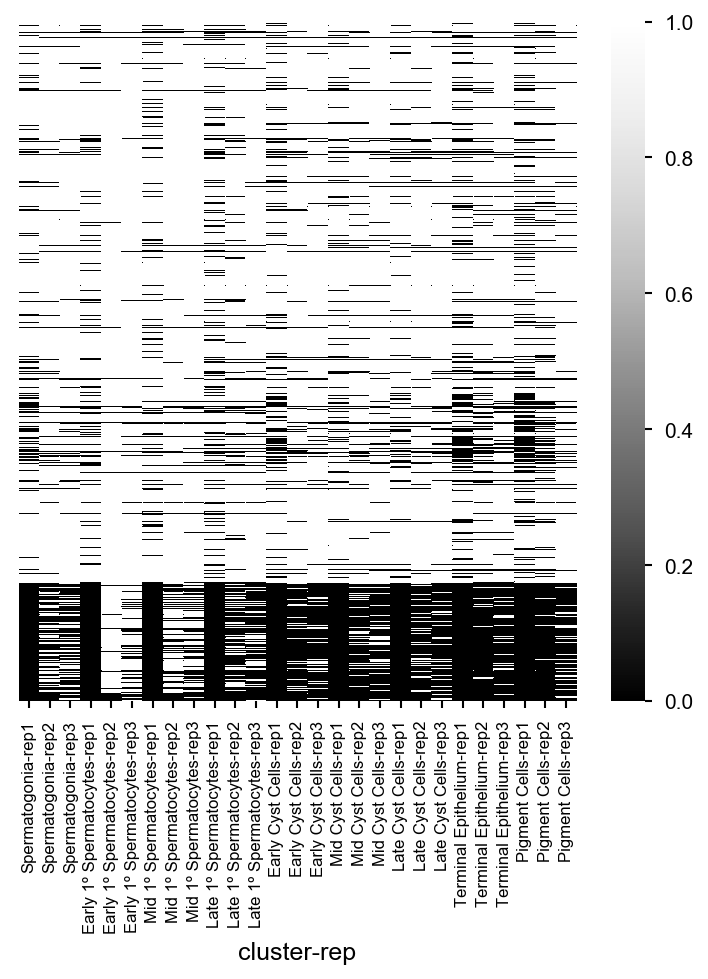

In [4]:
ax = sns.heatmap(raw_w_meta.groupby(['cluster', 'rep']).sum().T > 0, yticklabels=False, xticklabels=True, cmap='Greys_r')
plt.setp(ax.get_xticklabels(), fontsize=8);

## Distribution of read counts by cell by rep by cluster

There are large differences in total number of reads per cell by cluster by replicate.

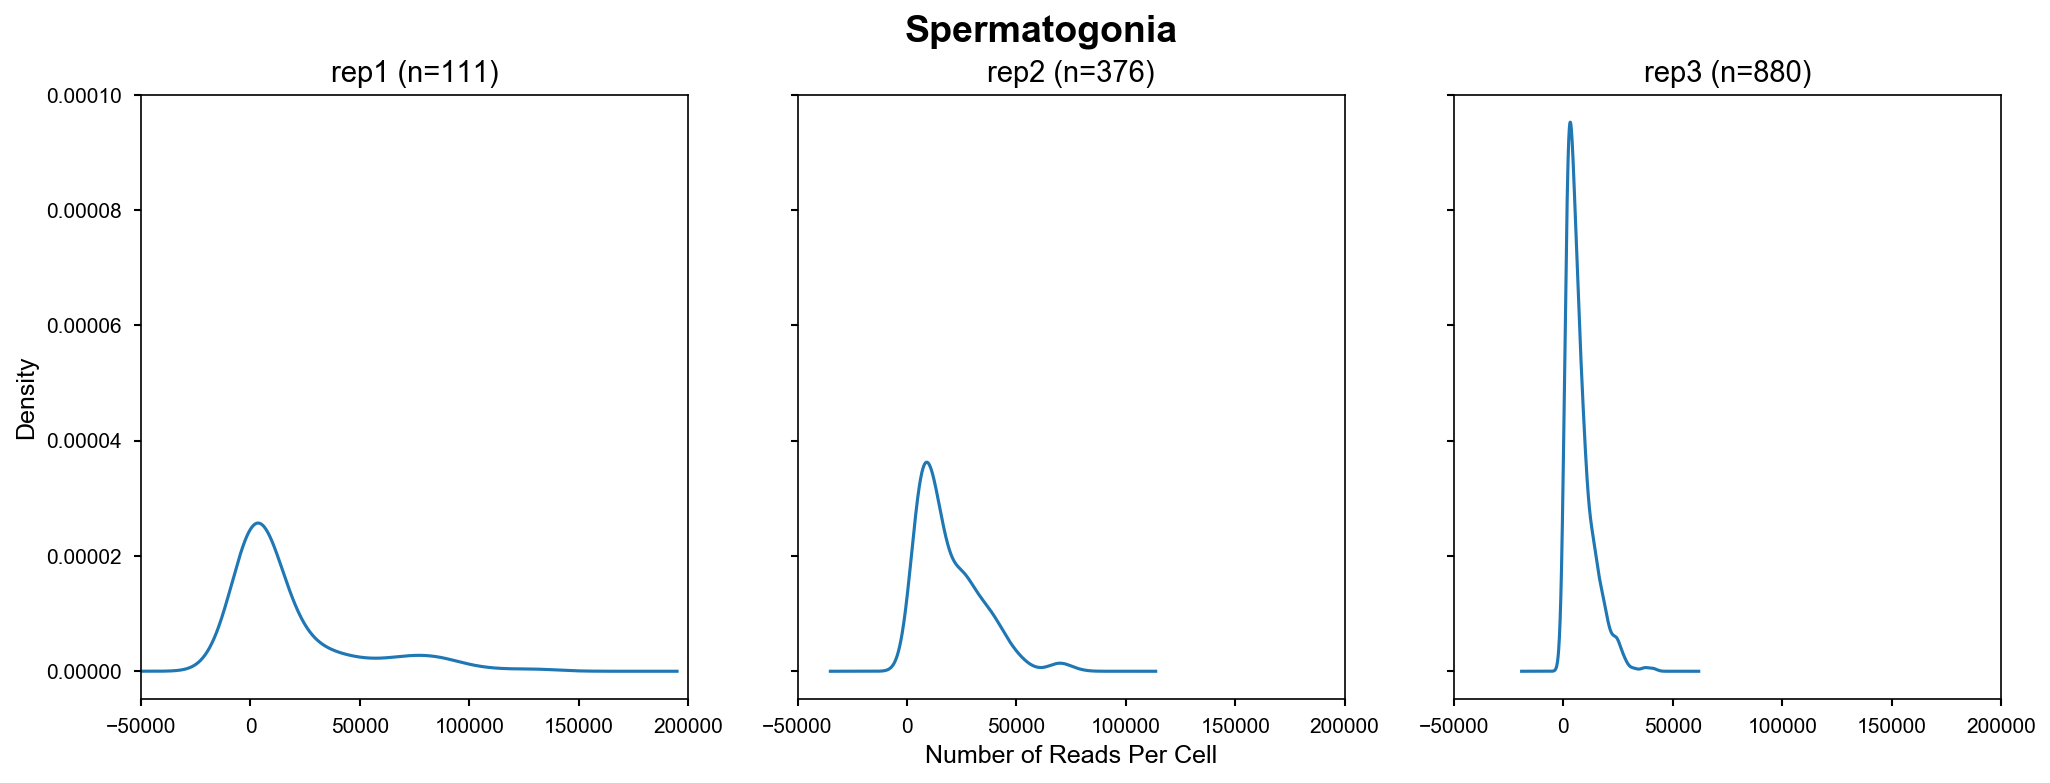

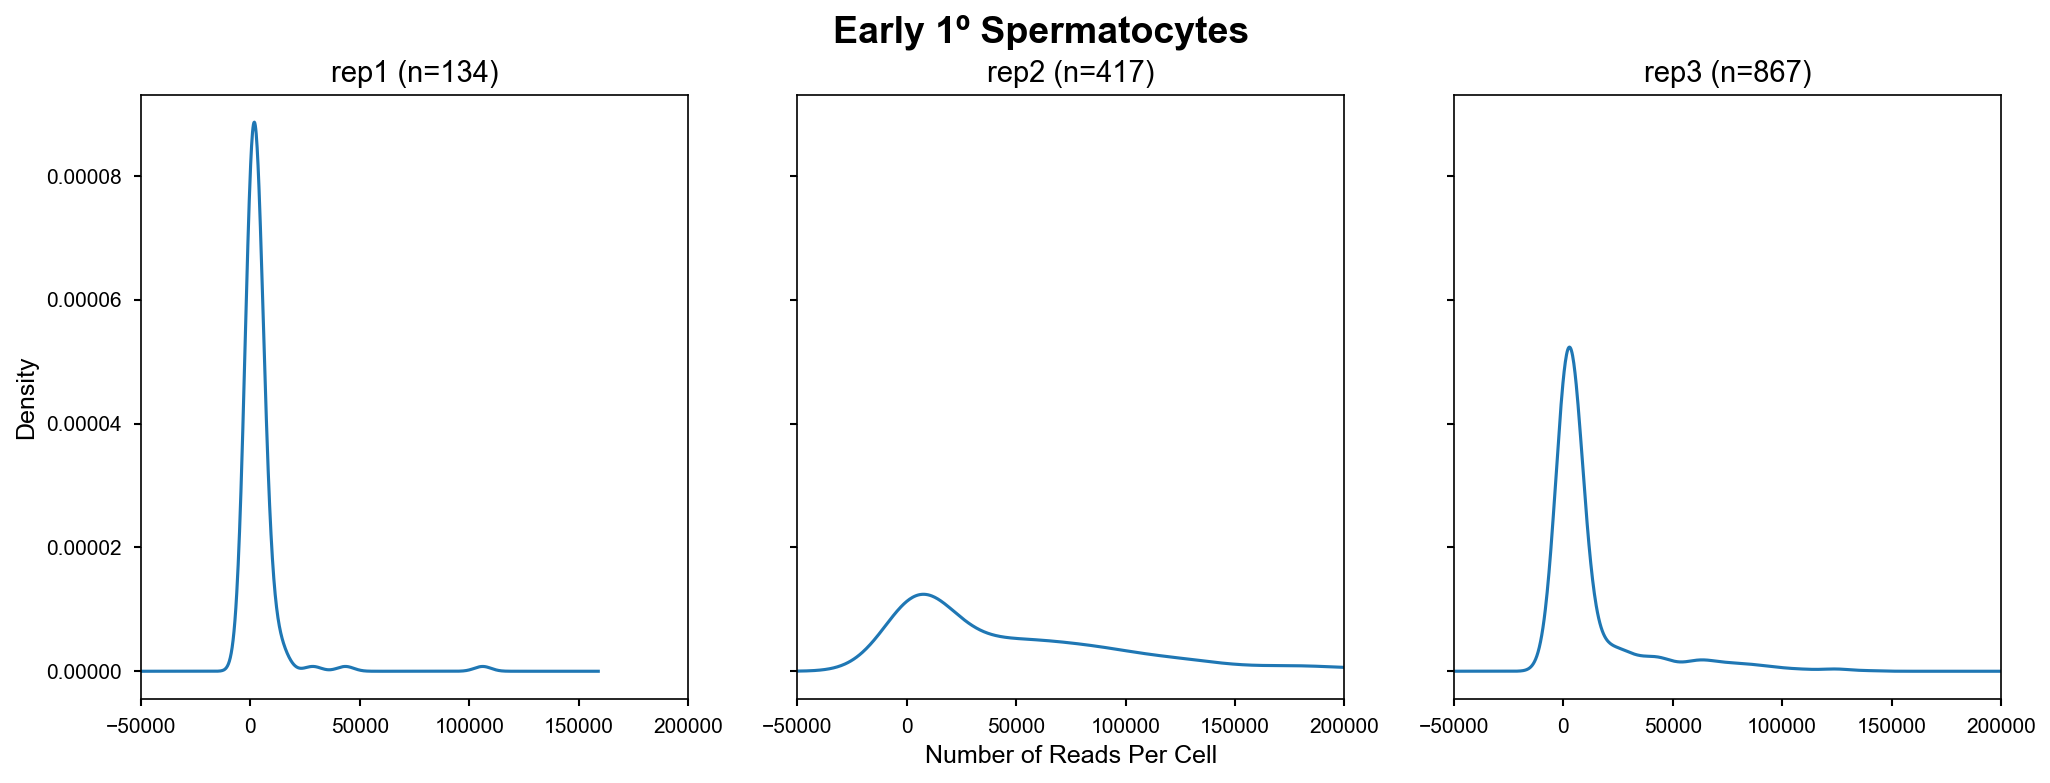

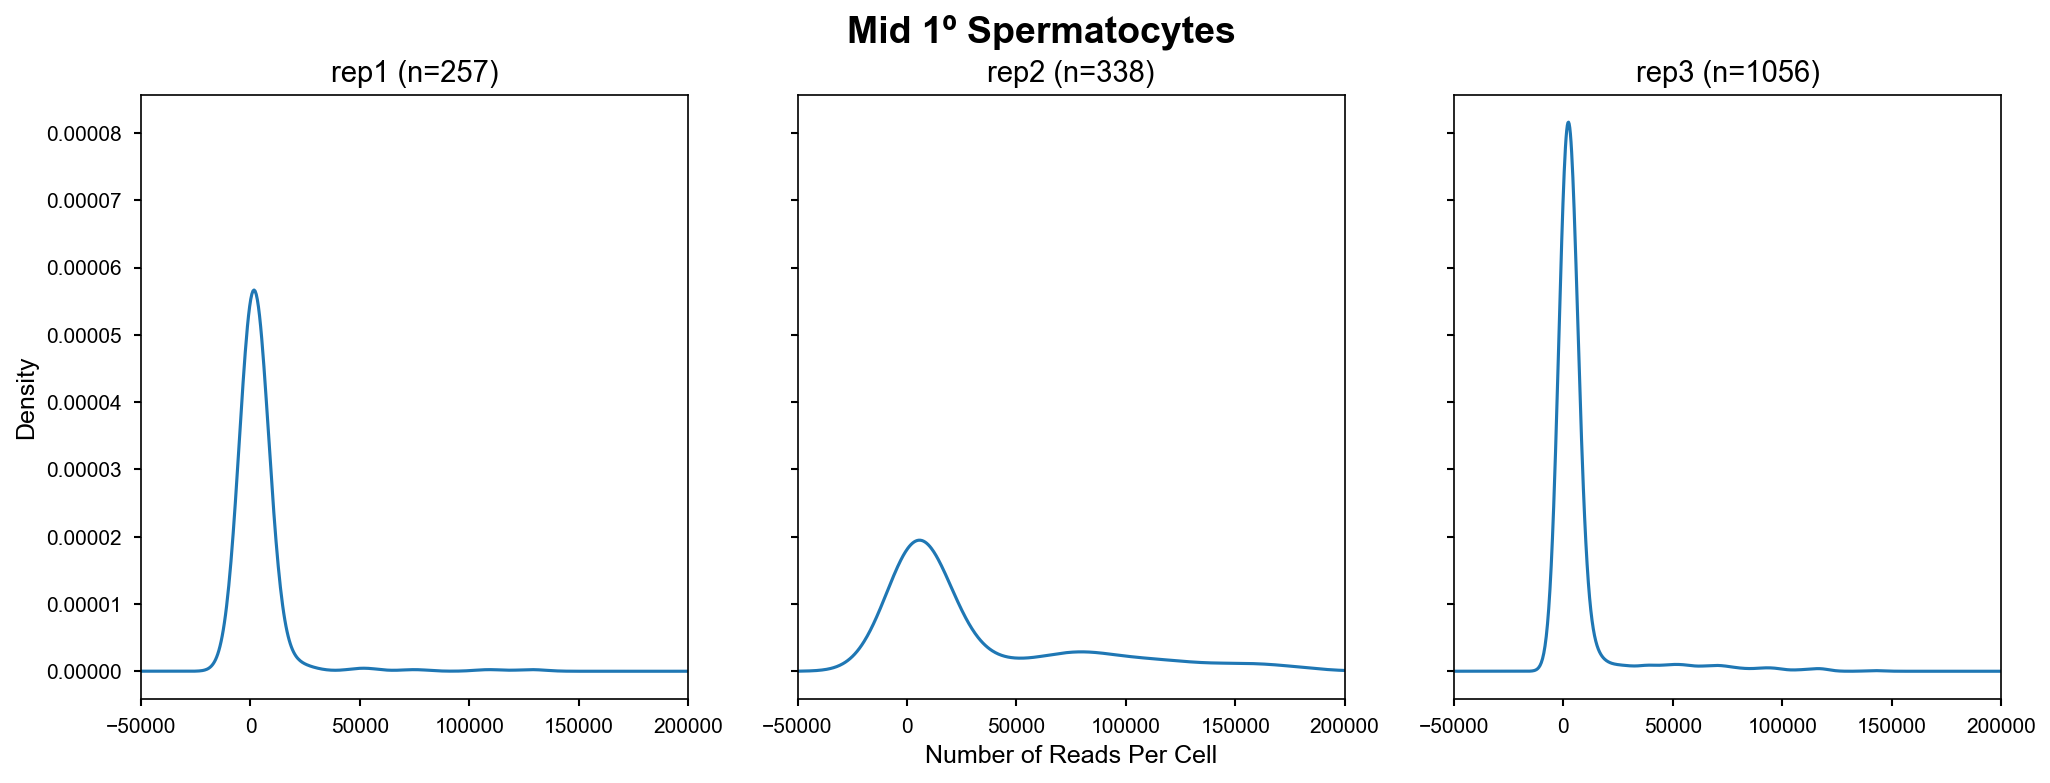

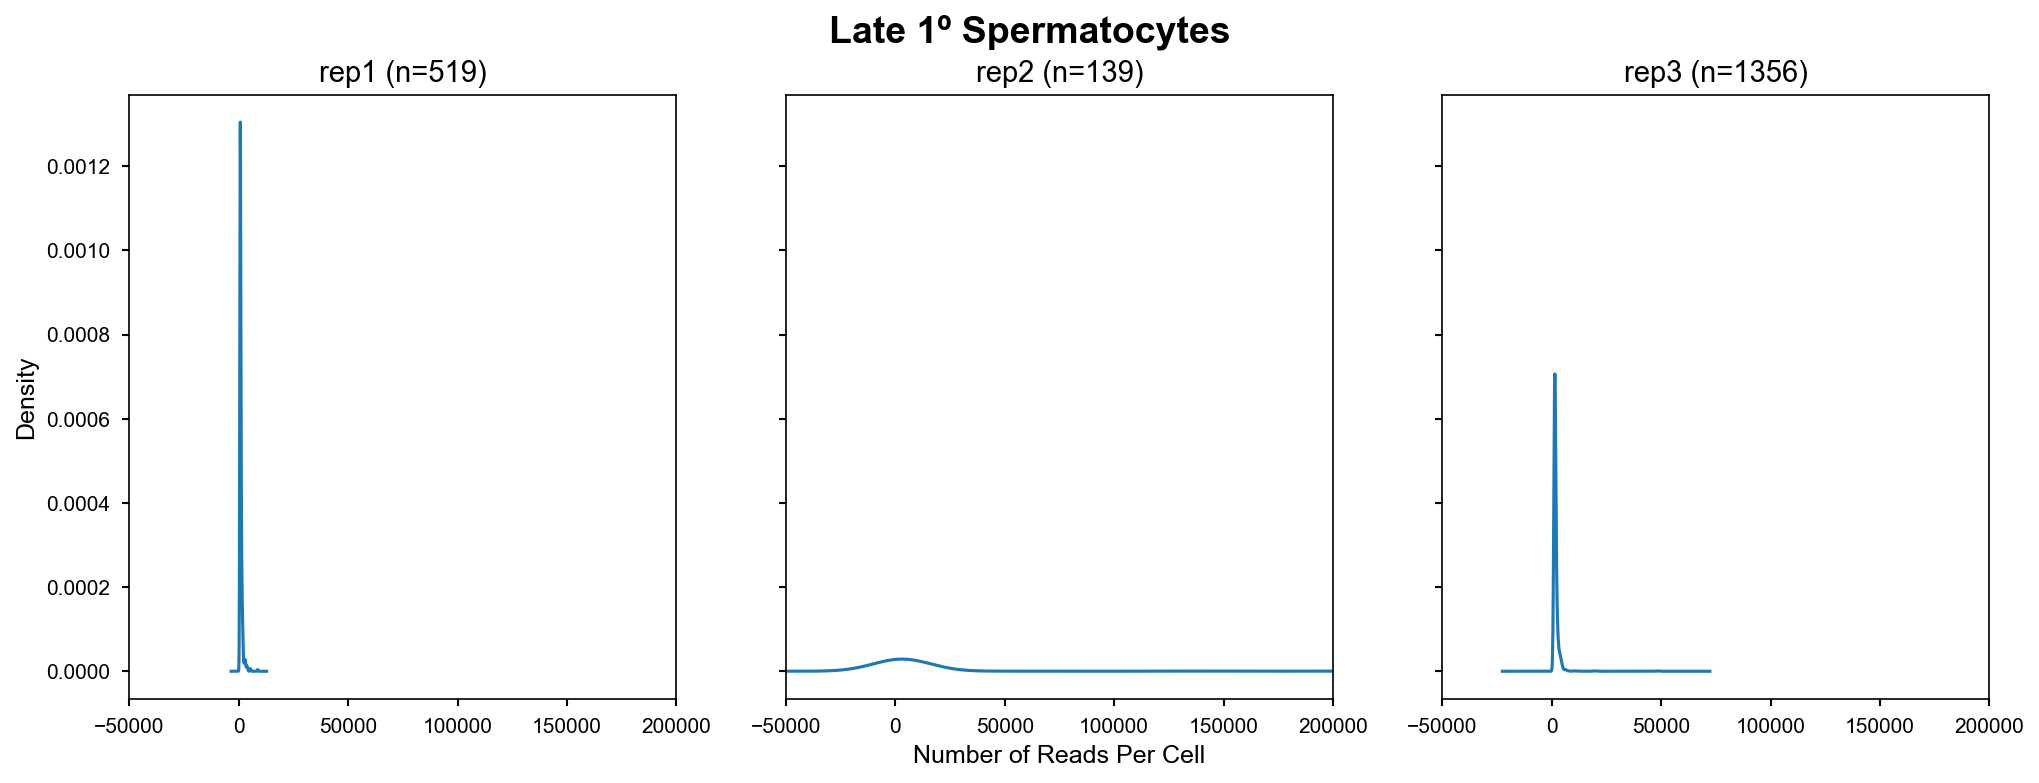

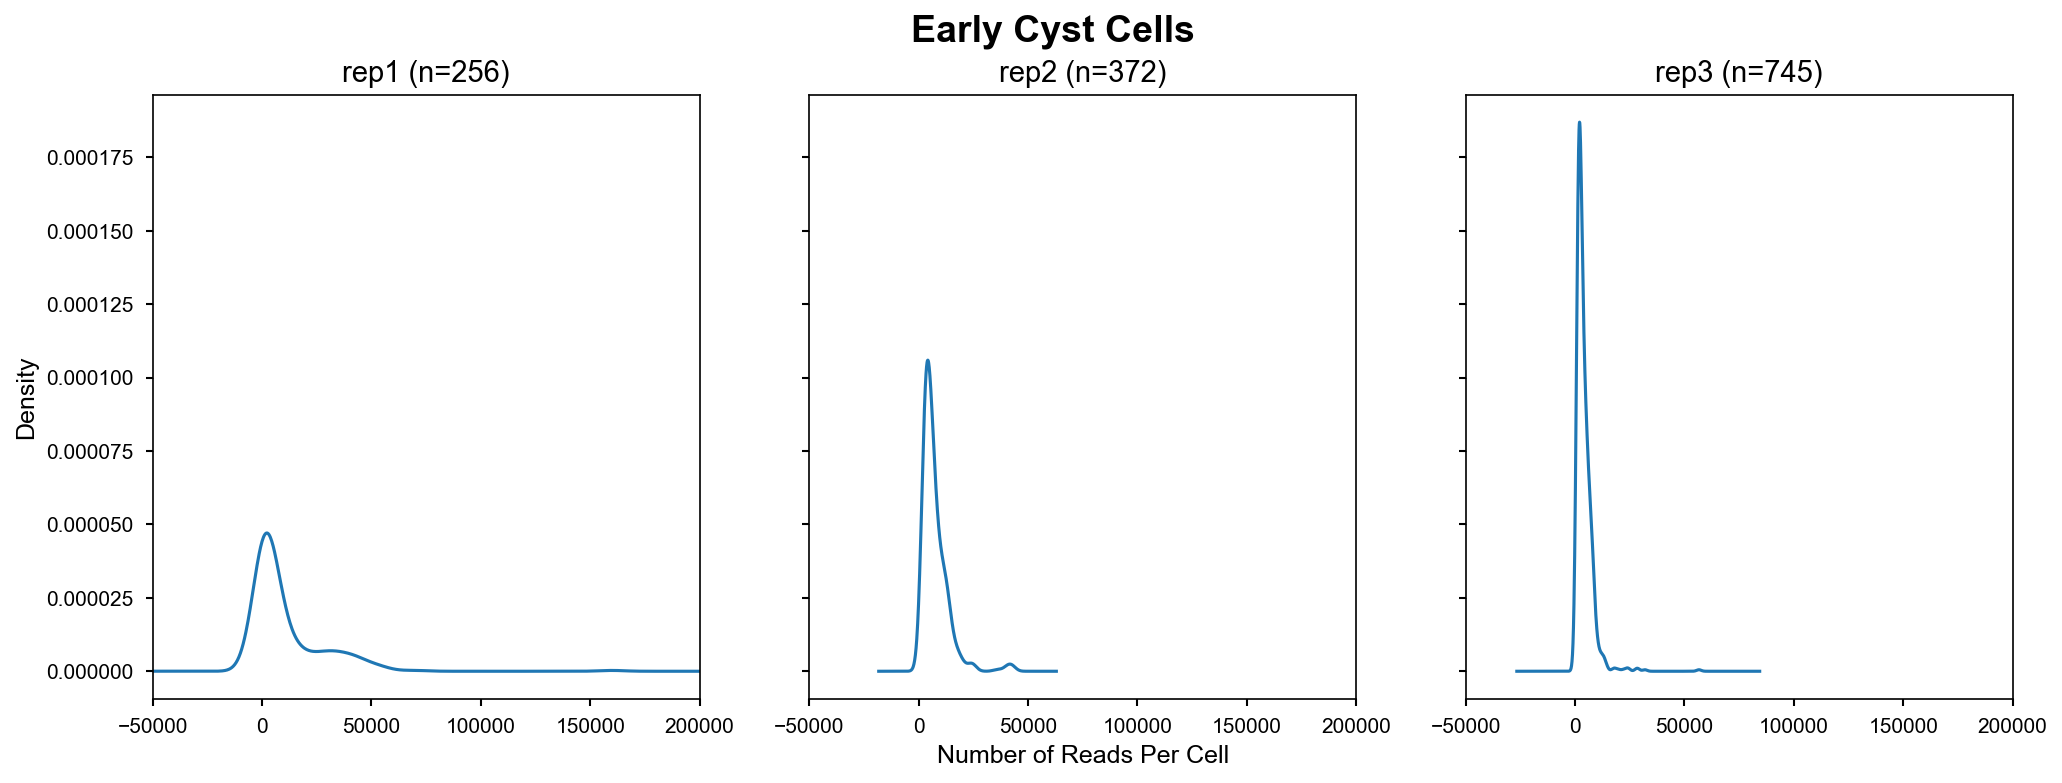

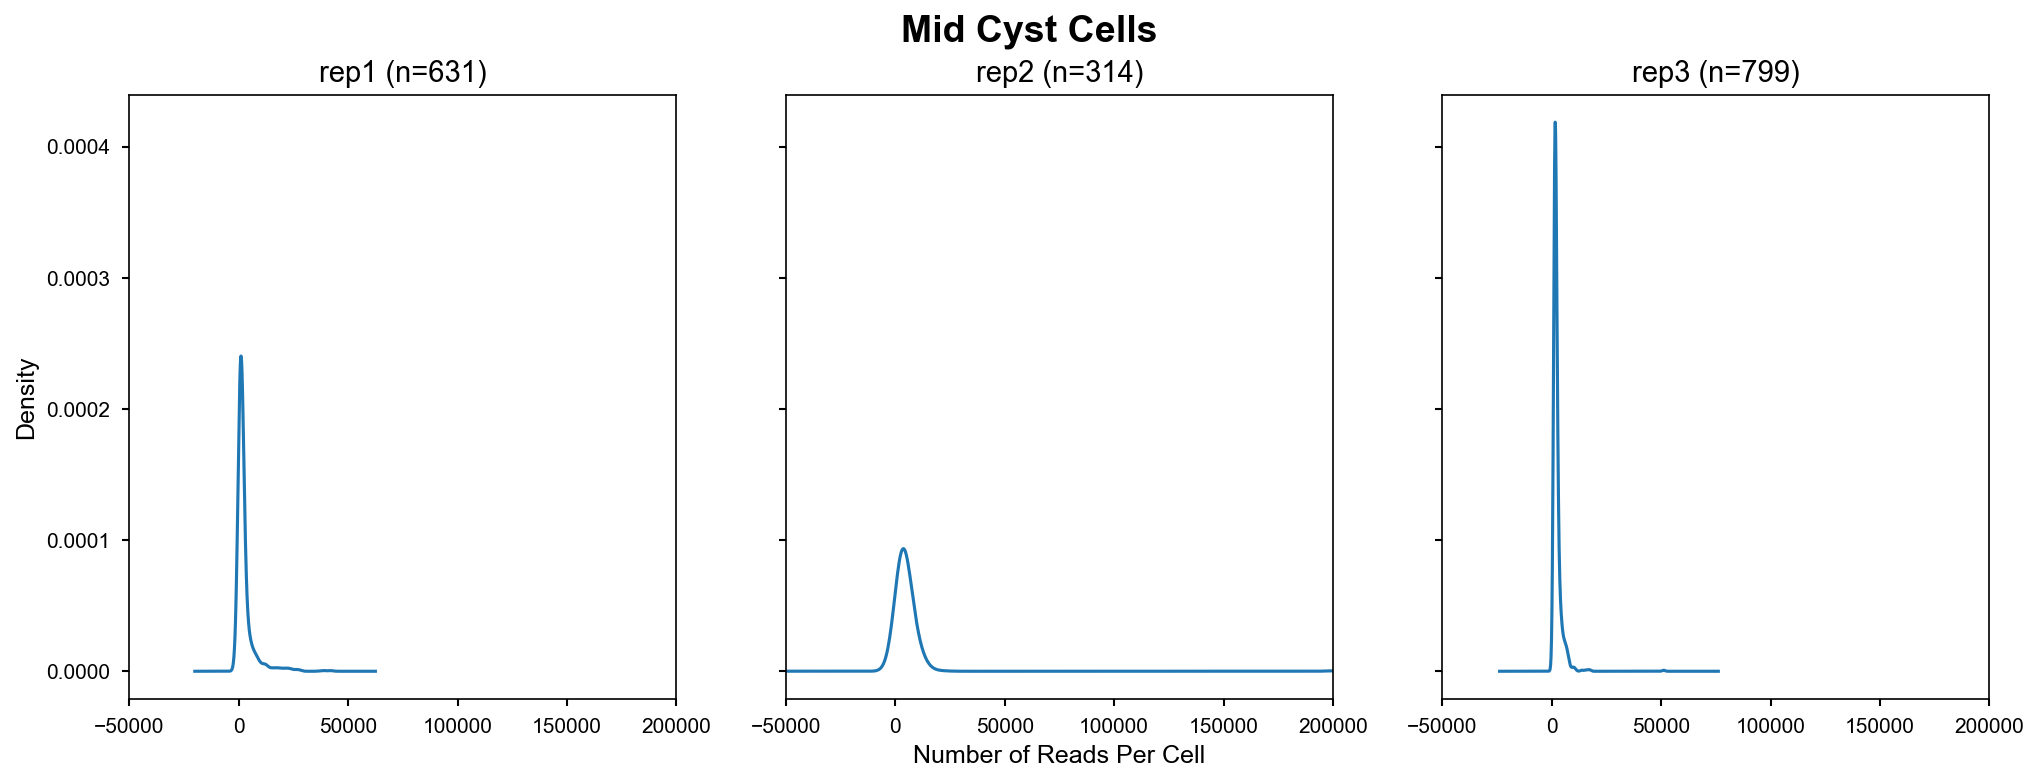

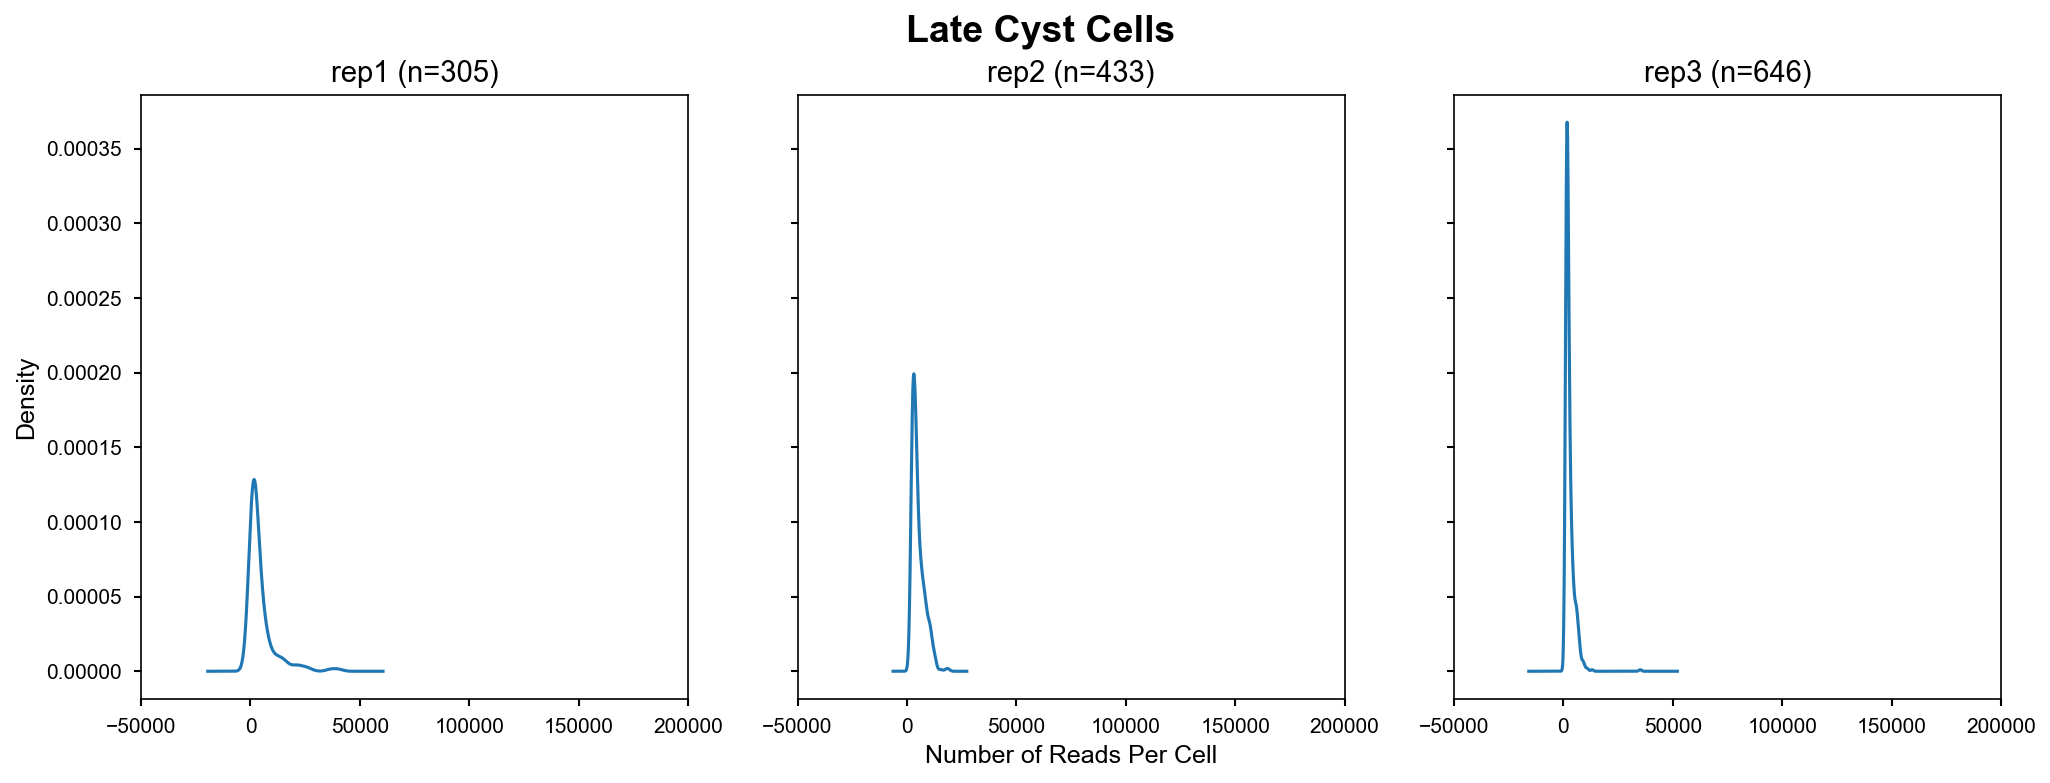

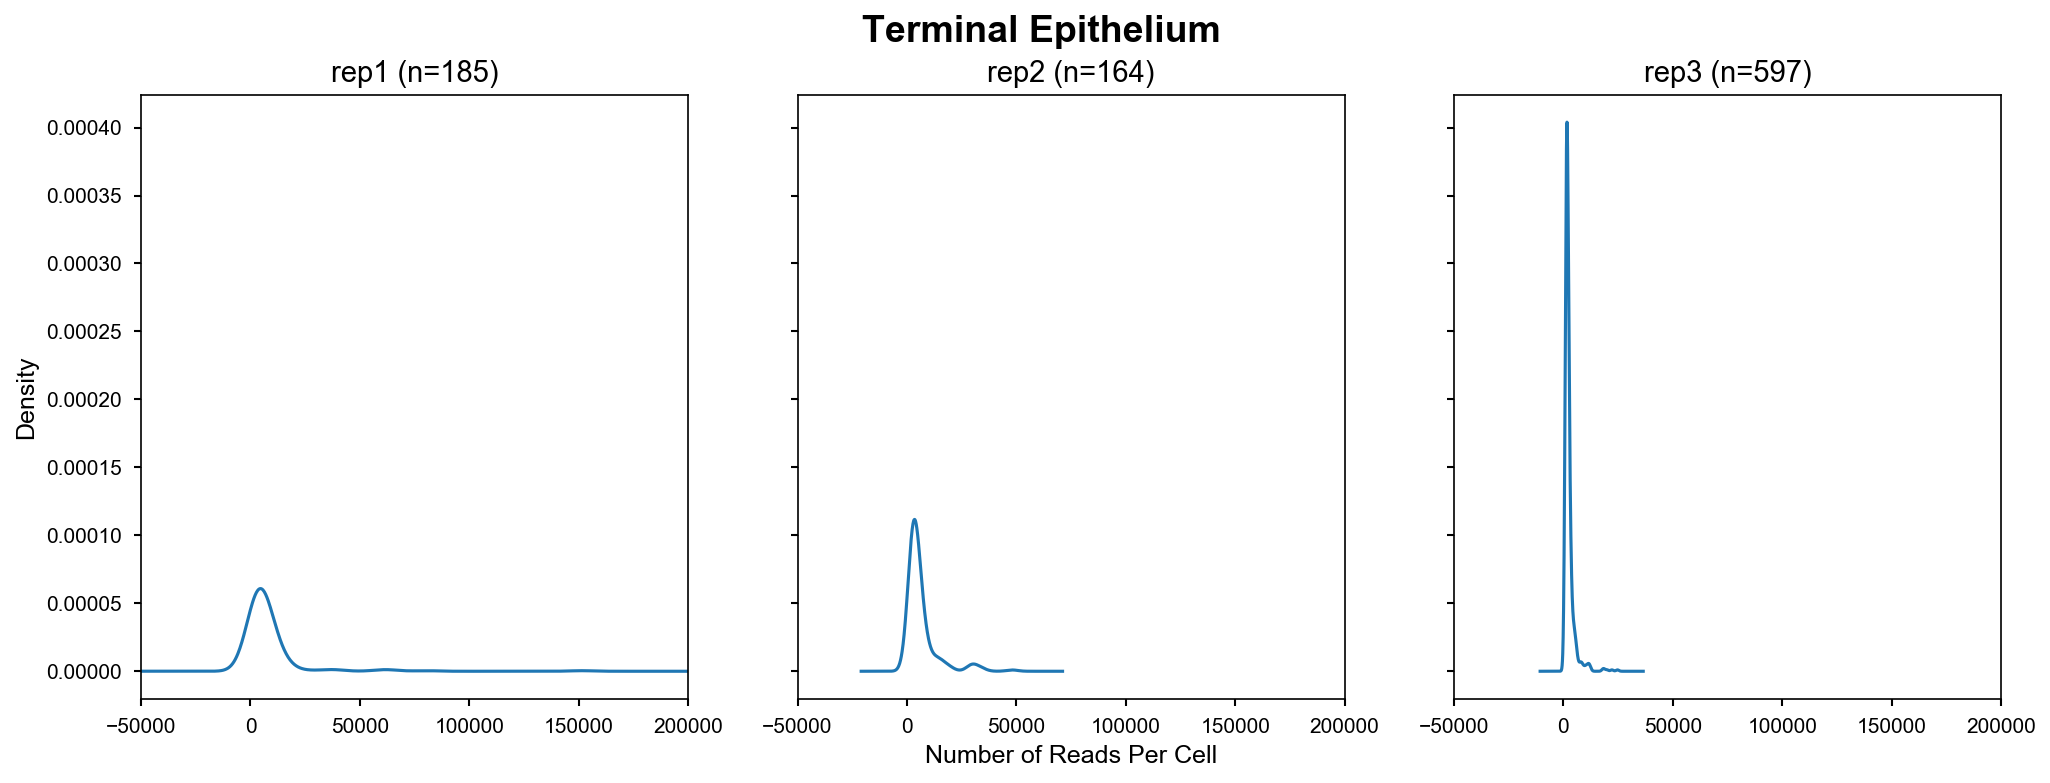

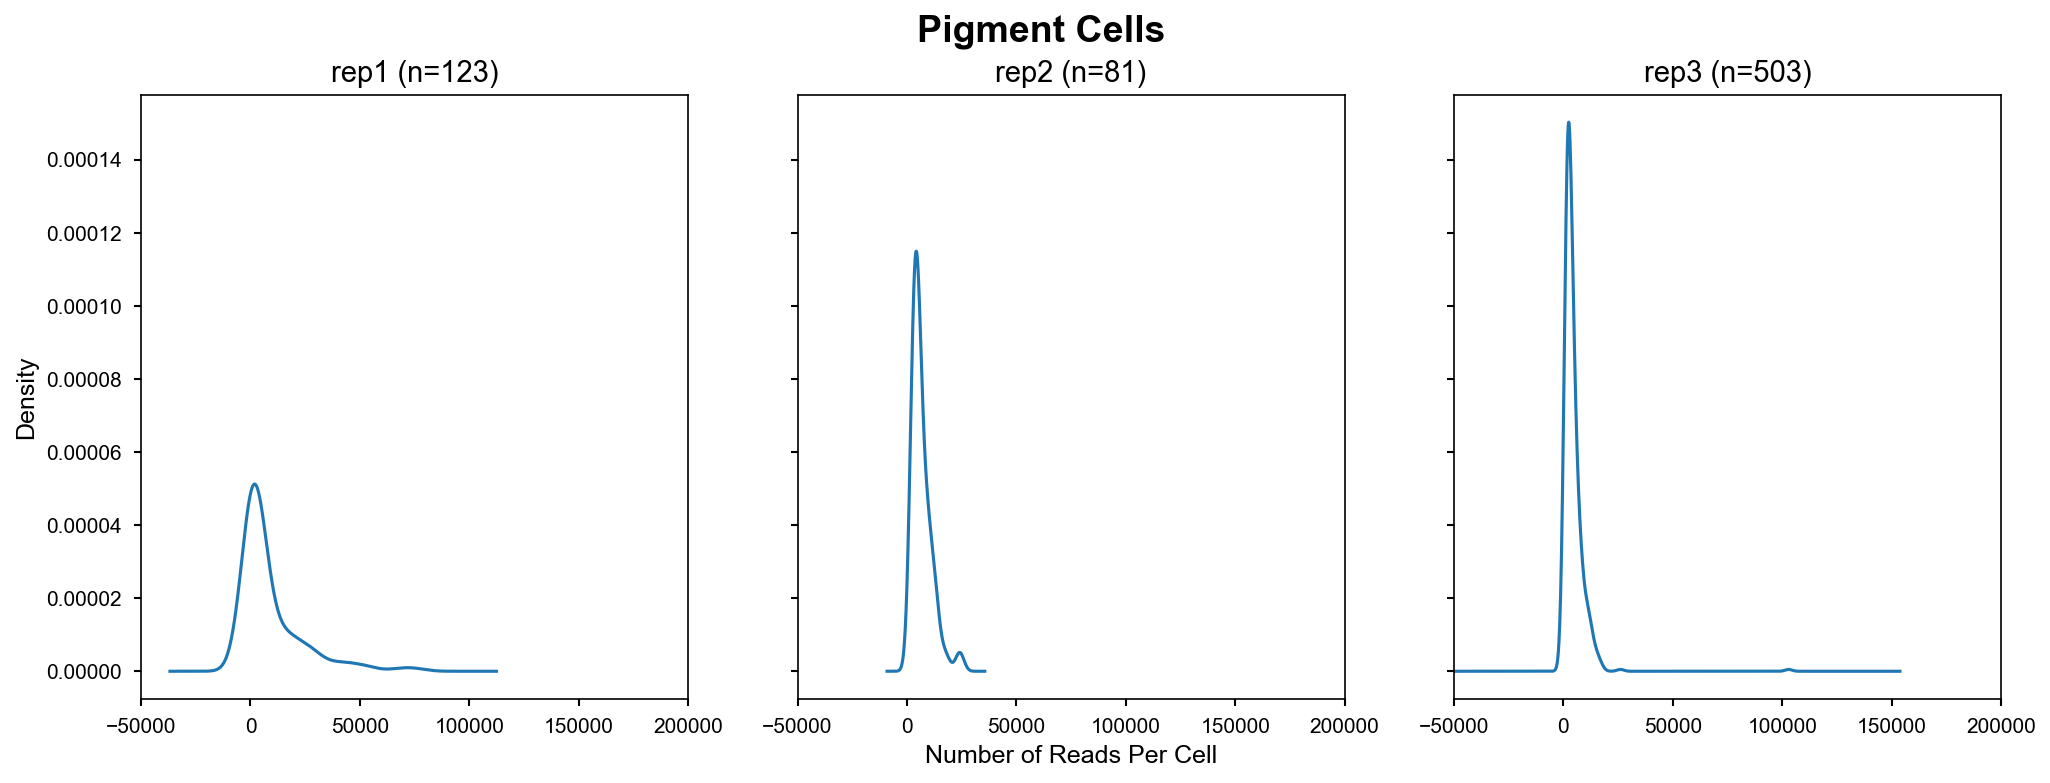

In [23]:
def reads_per_cell(cluster, rep, ax):
    _dat = raw_w_meta.query(f'cluster == "{cluster}" & rep == "{rep}"').drop(['cluster', 'rep'], axis=1)
    num_cells = _dat.shape[0]
    num_reads = _dat.sum(axis=1)
    
    num_reads.plot.kde(ax=ax, legend=False)
    ax.set_title(f'{rep} (n={num_cells})')

    
def _plot(cluster):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True, sharex=True)
    reads_per_cell(cluster, 'rep1', ax1)
    reads_per_cell(cluster, 'rep2', ax2)
    reads_per_cell(cluster, 'rep3', ax3)
    fig.suptitle(cluster);
    ax2.set_xlabel('Number of Reads Per Cell')
    ax1.set_xlim(-50_000, 200_000)
    
    
for cluster in nbconfig.sel_cluster_order:
    _plot(cluster)

## Missings within Cluster\*Replicate

First I look at the distribution of missingness within each cluster * replicate. To do this I count the number of genes off (0 reads) and the number of genes on (>0 reads) for each cell. I then plot the distribution of cells. We can see that for any given cell the majority of genes have 0 reads. Strangely replicate 2 distributions look rather different than replicates 1 and 3.

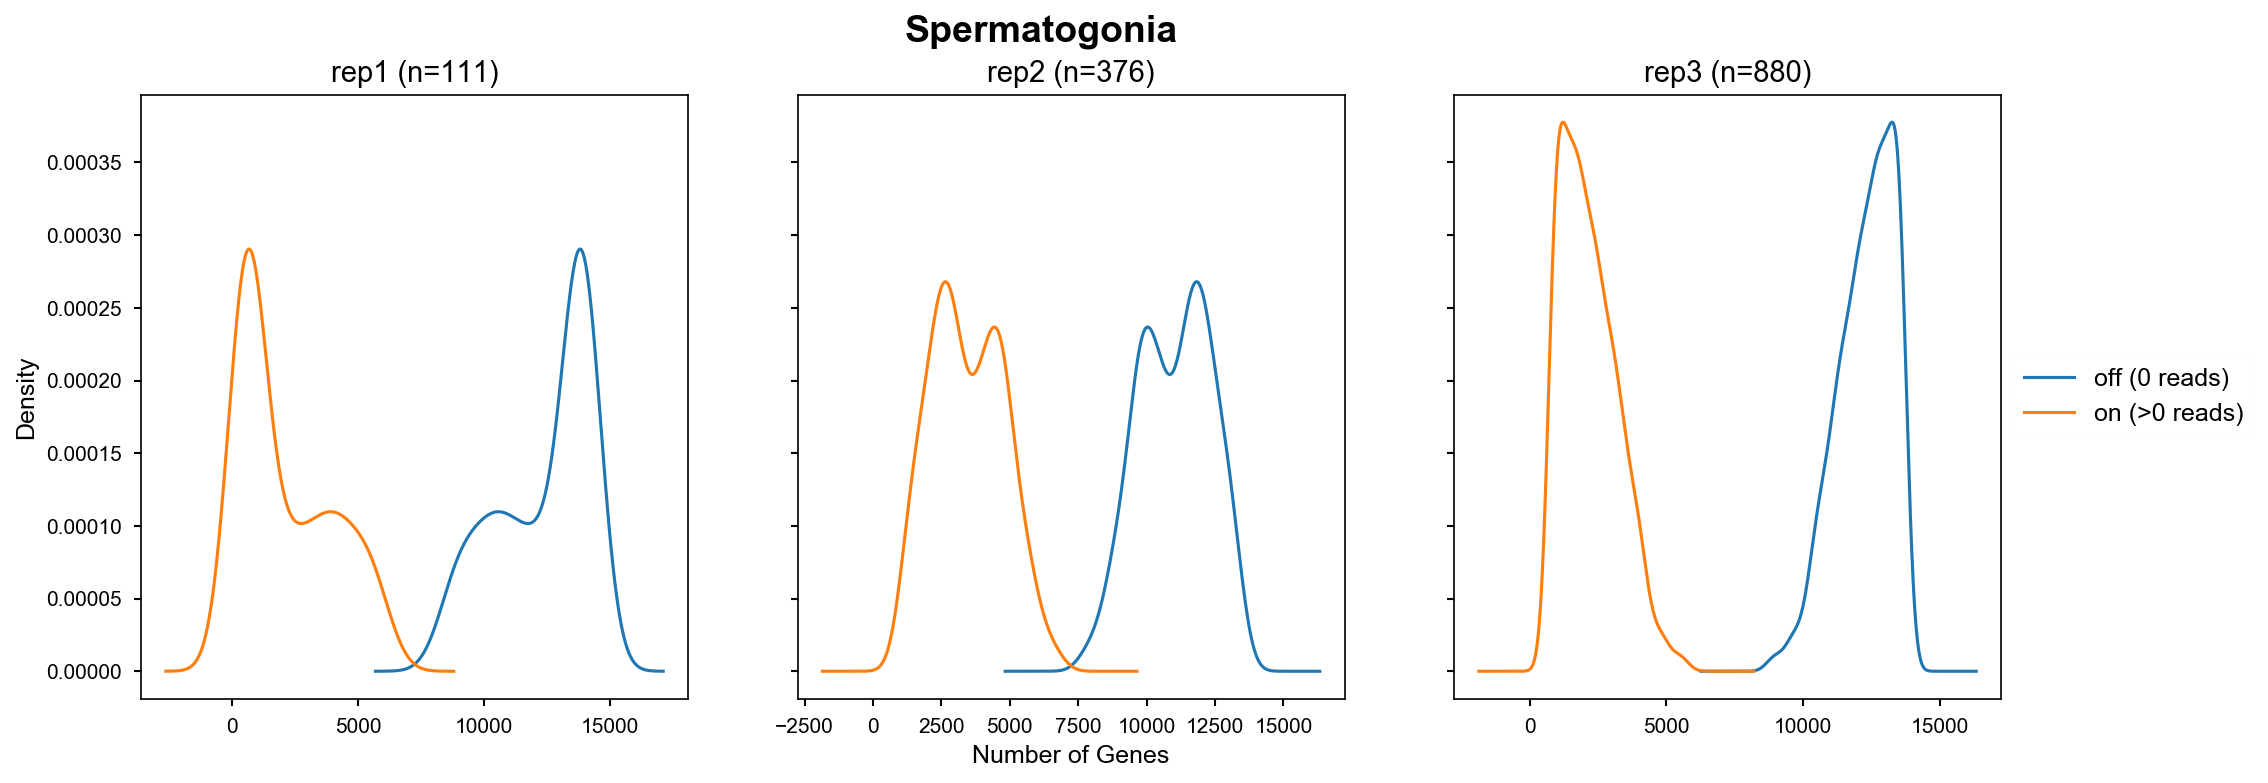

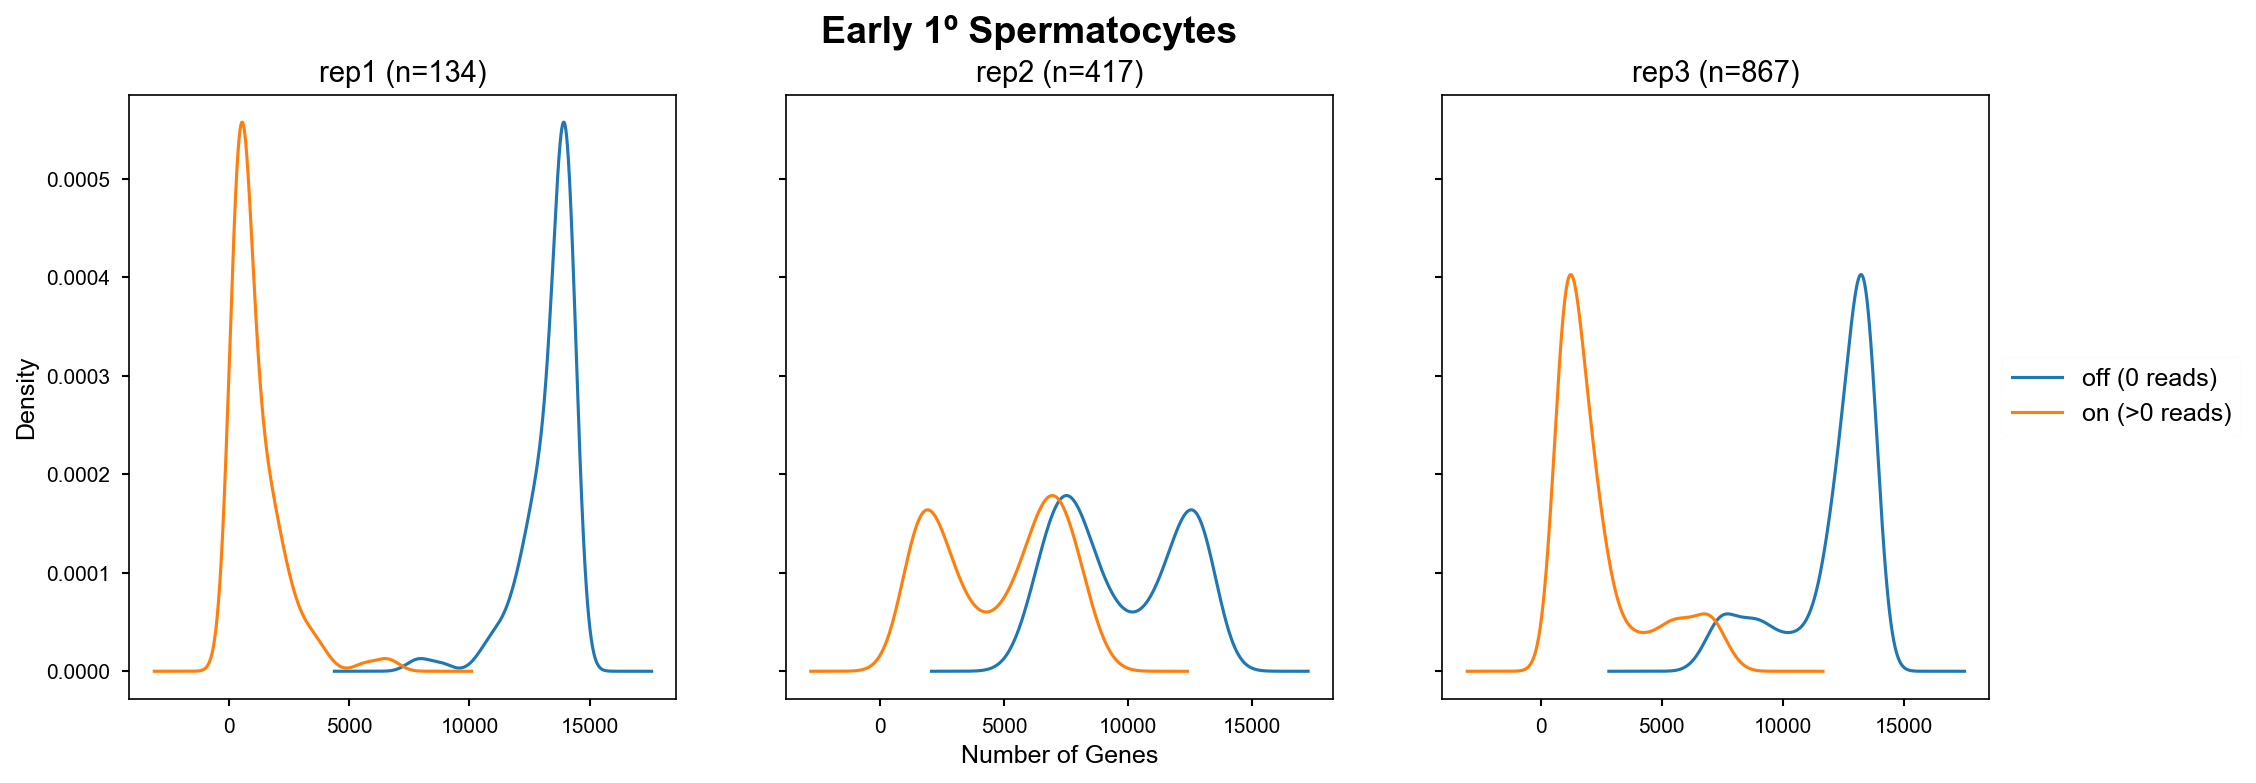

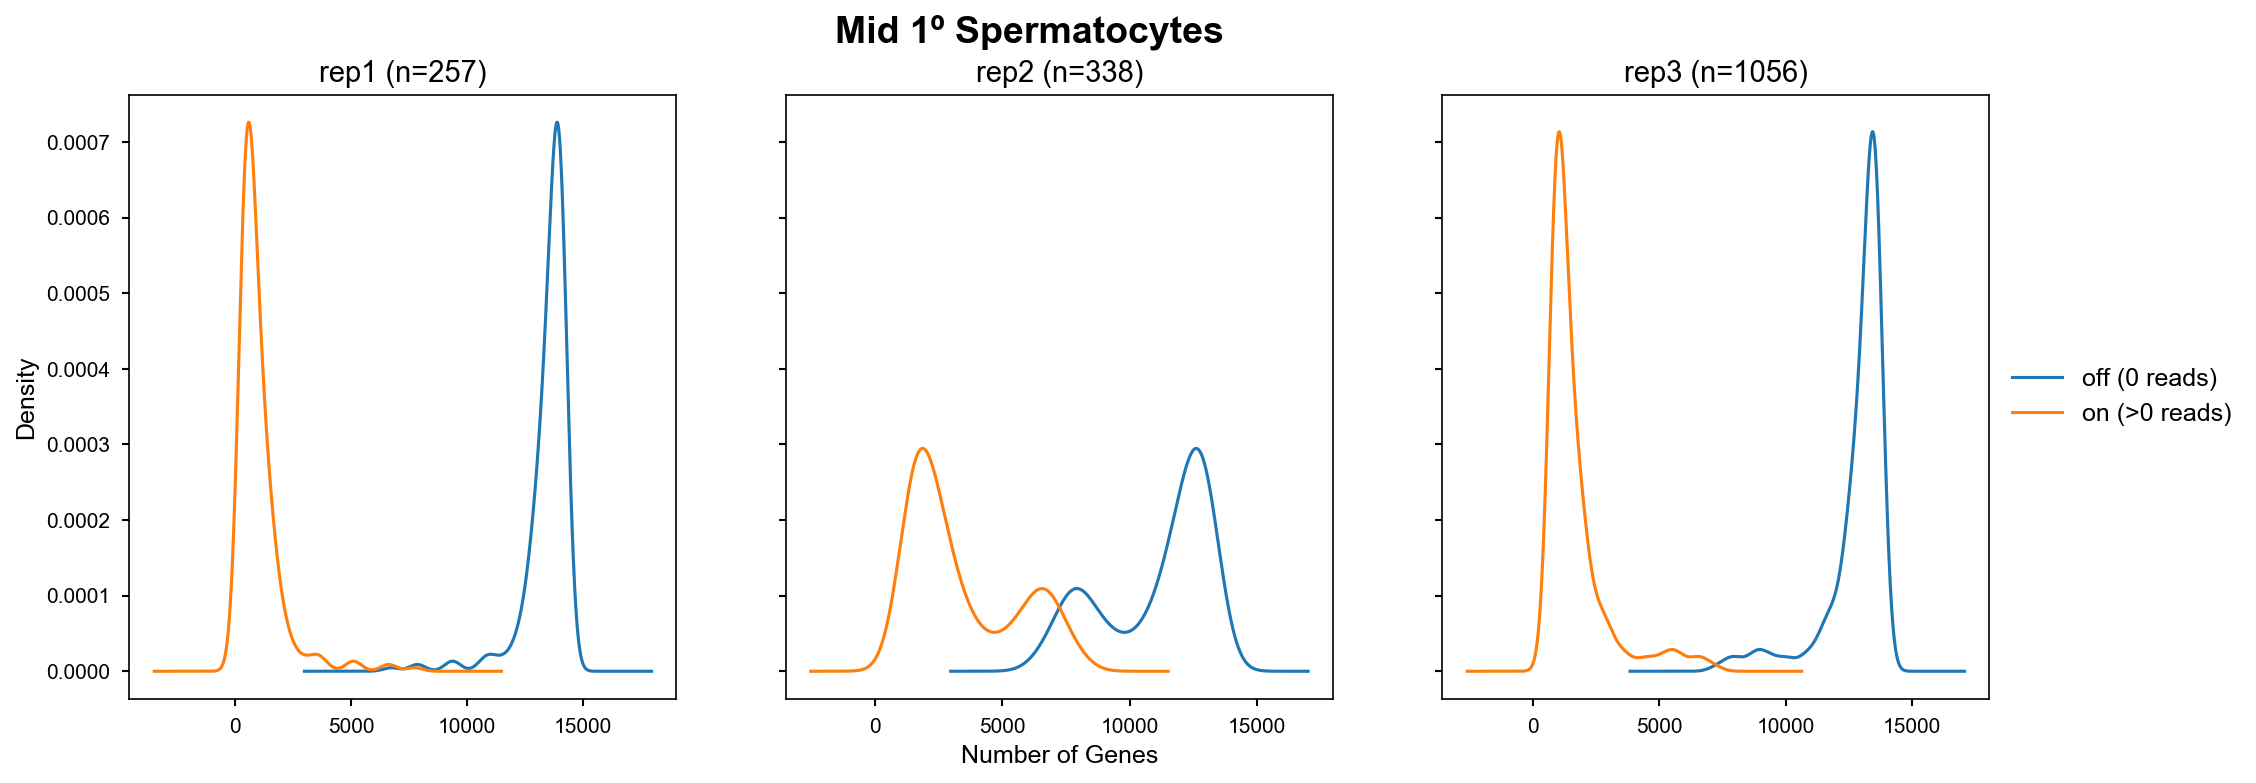

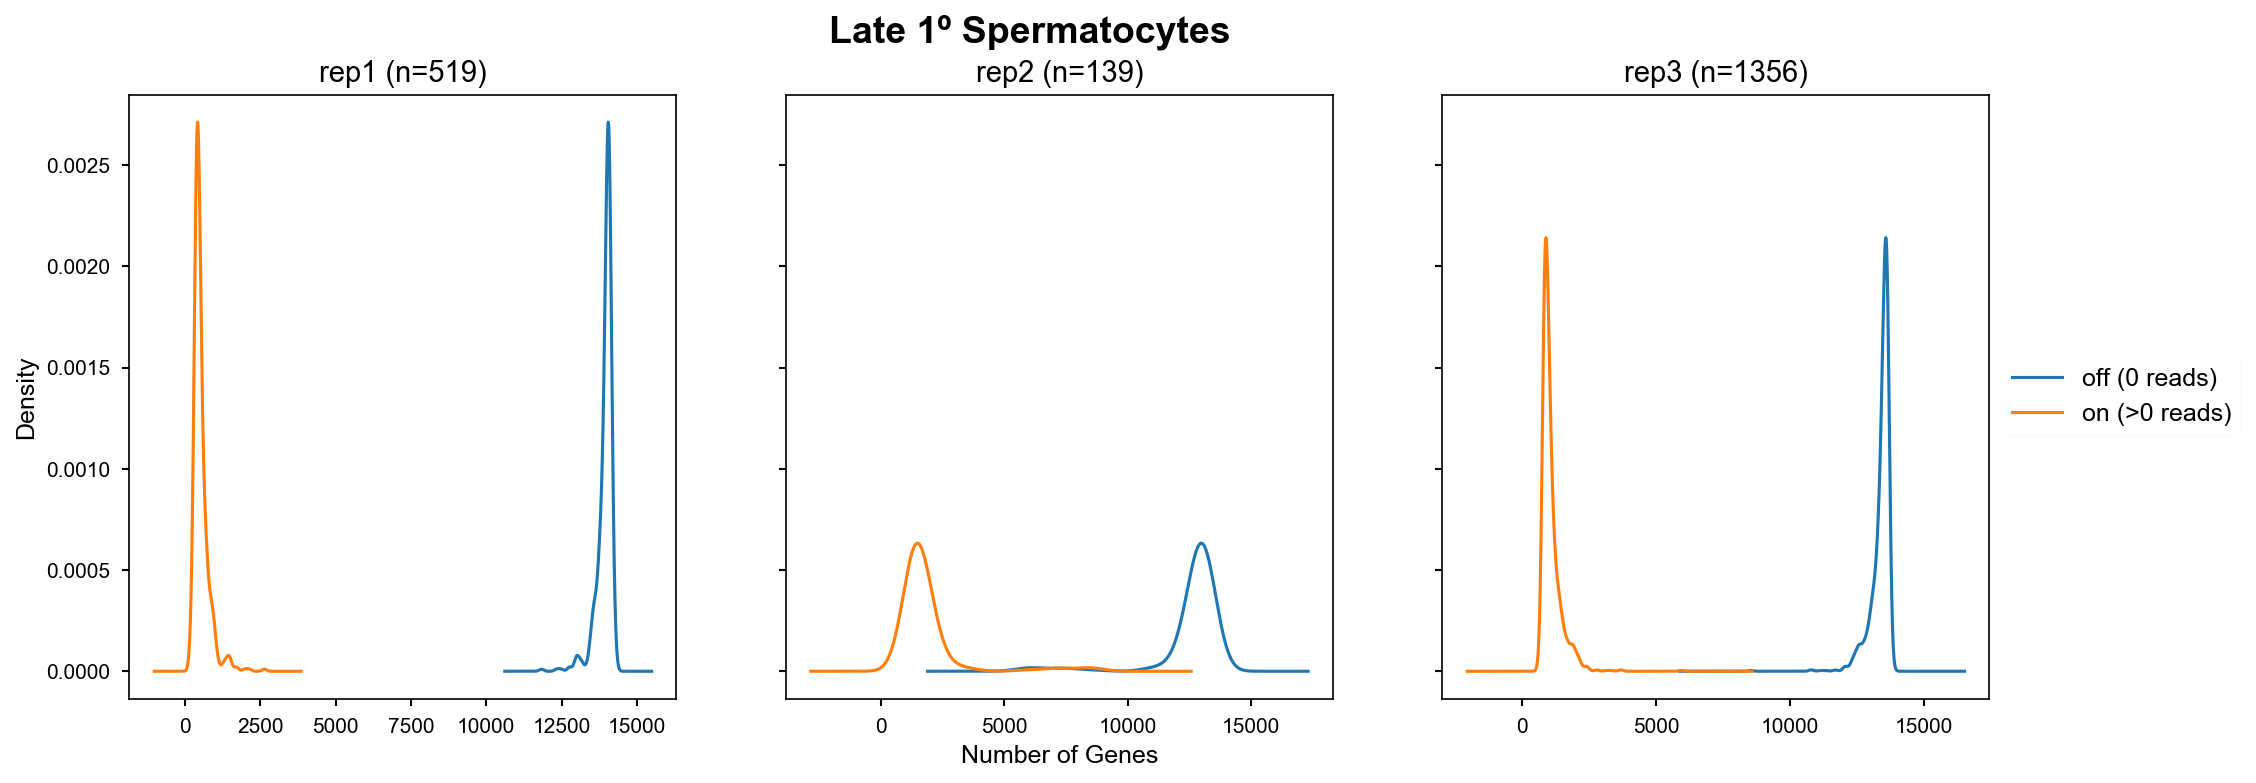

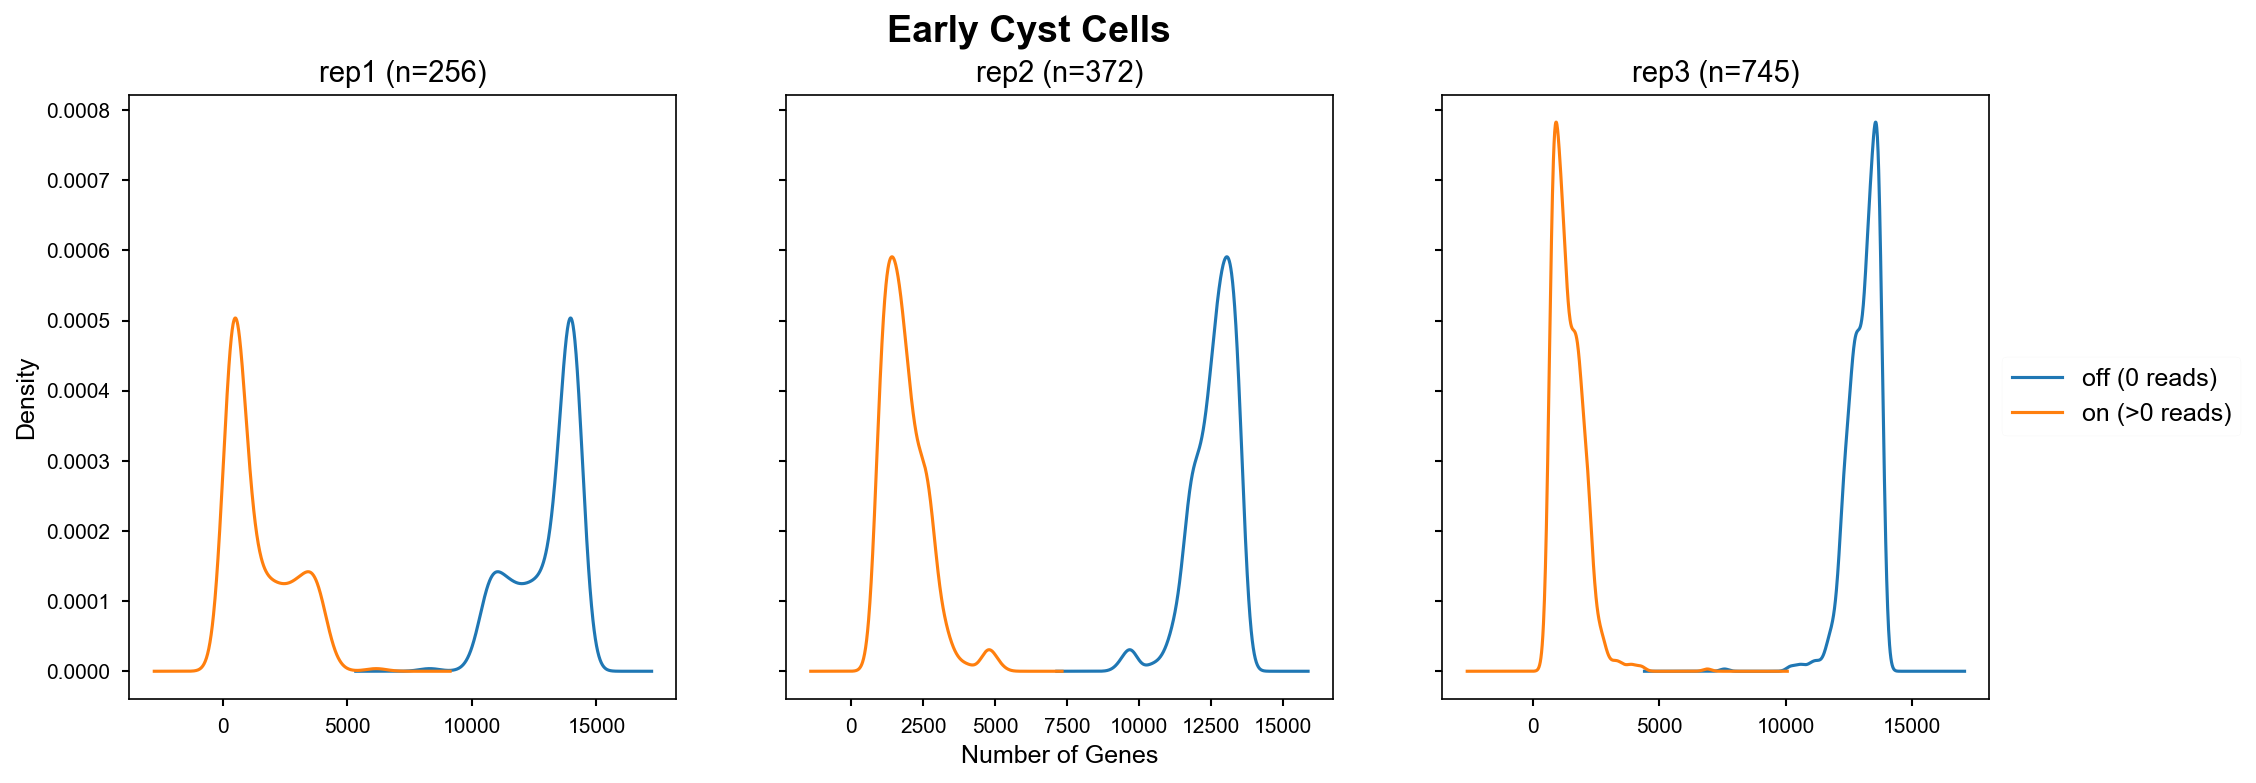

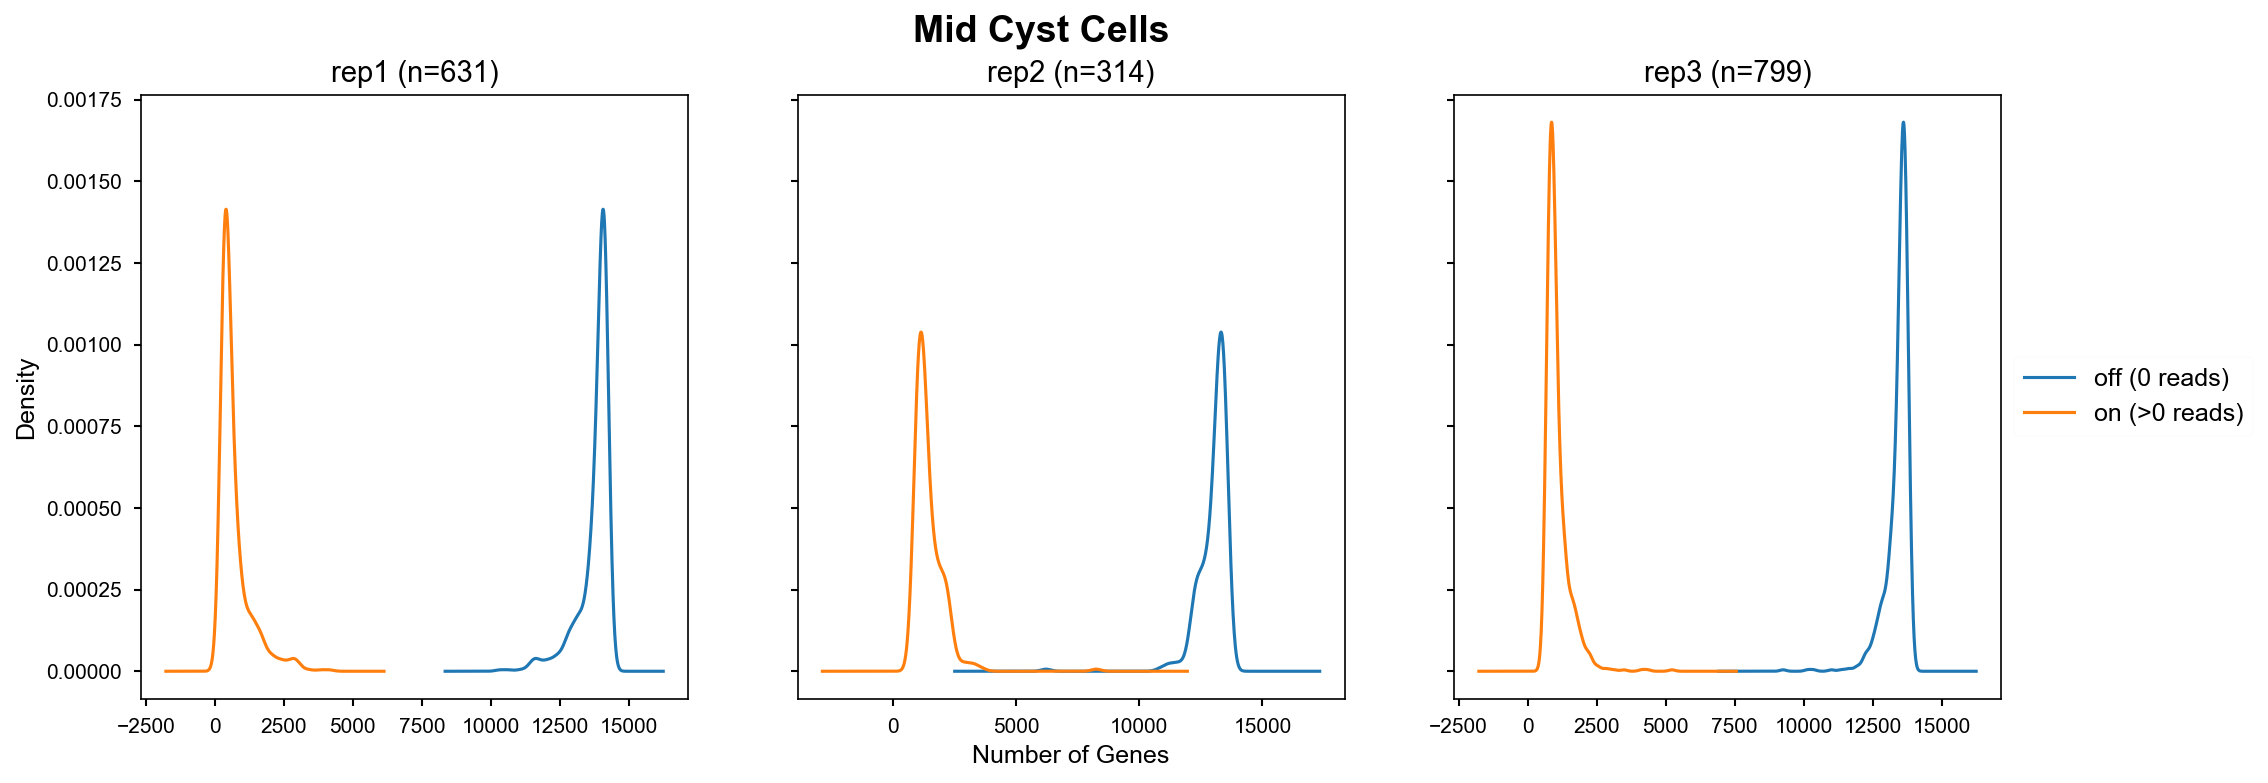

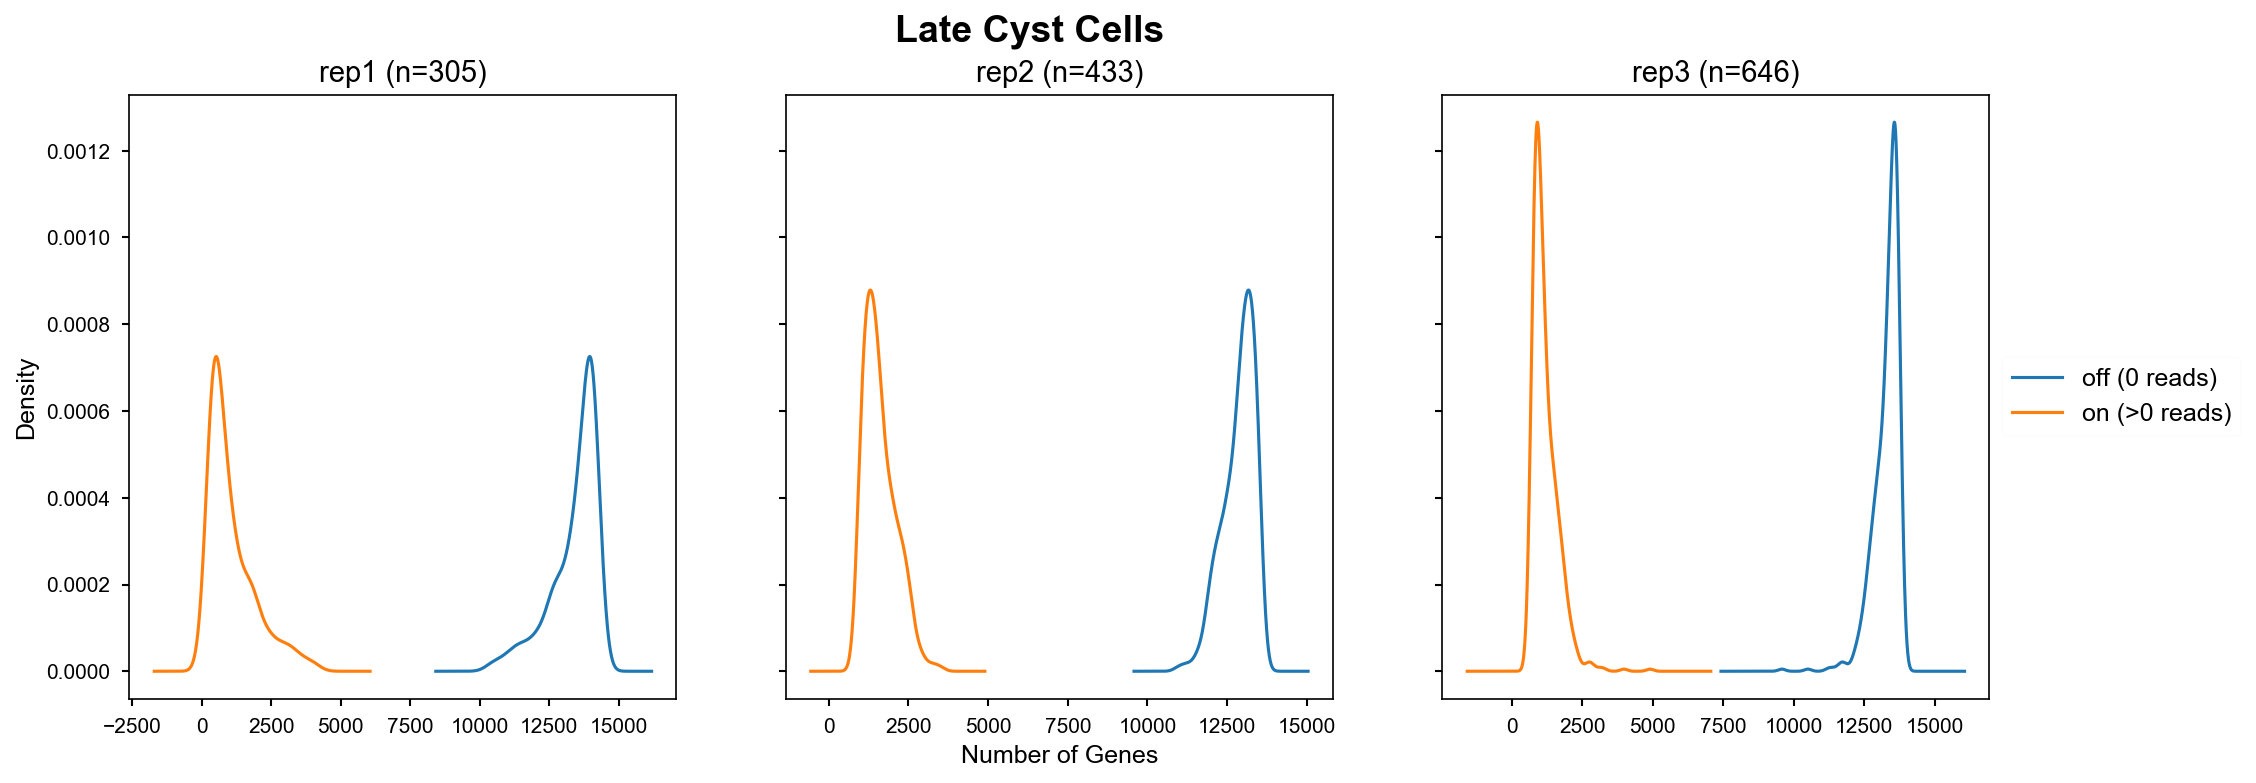

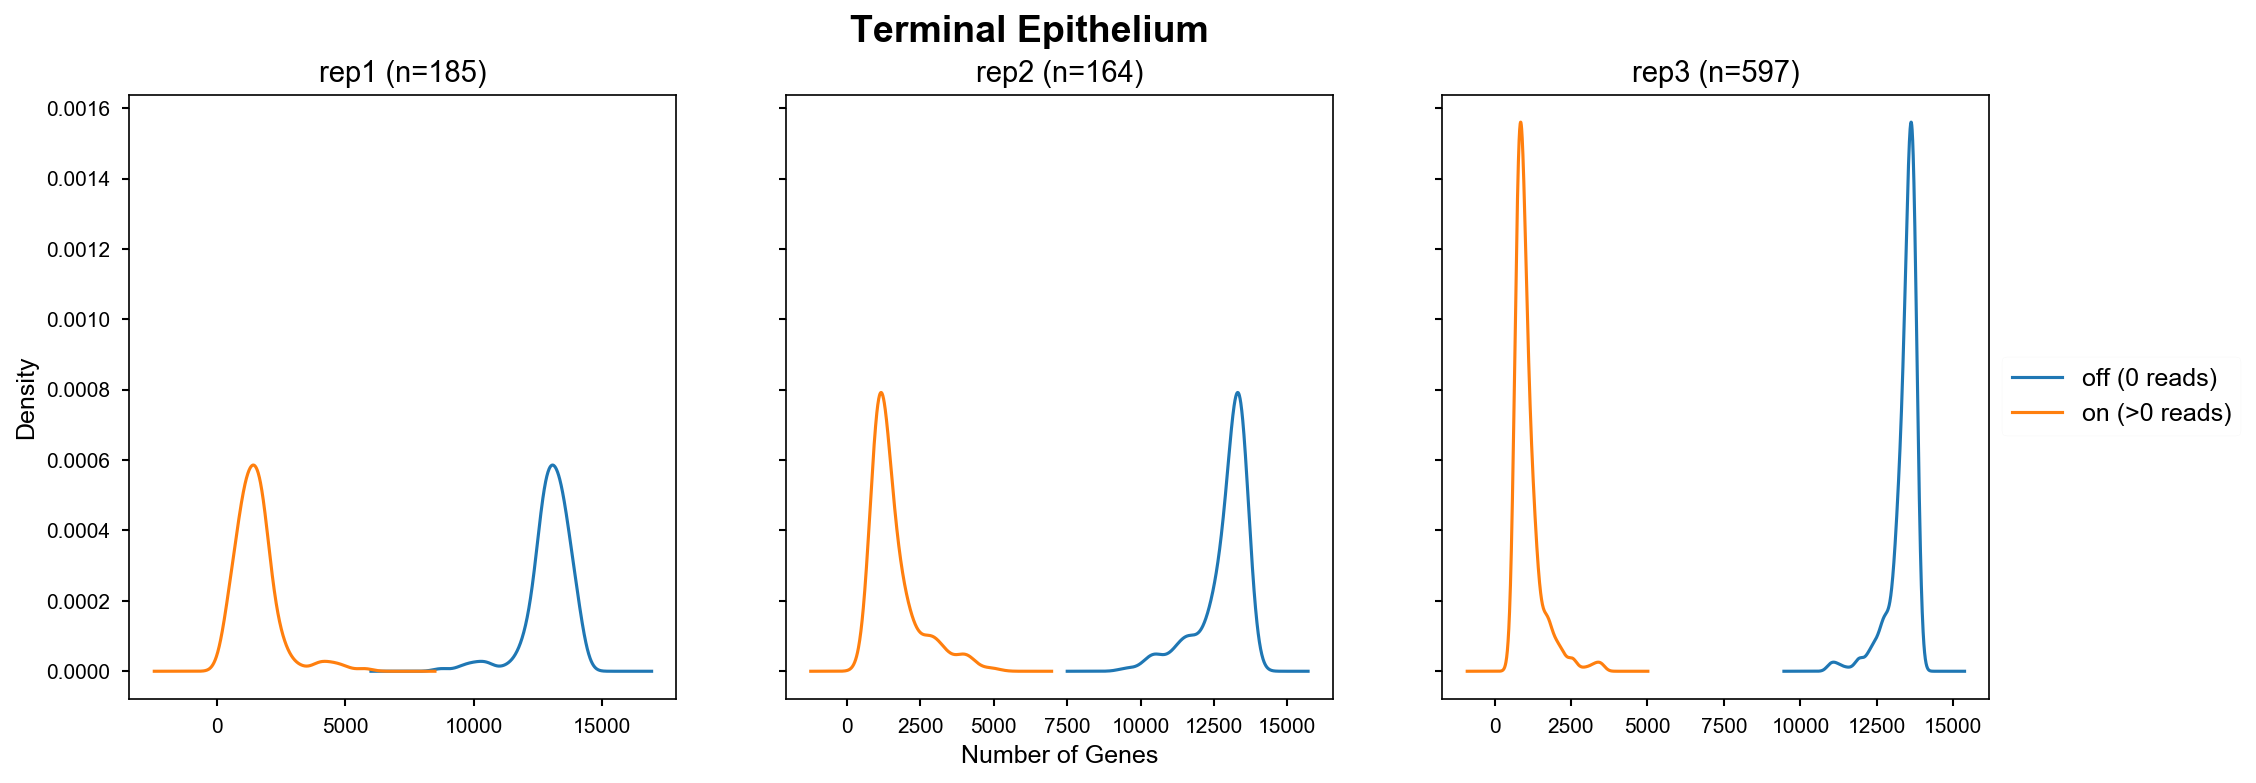

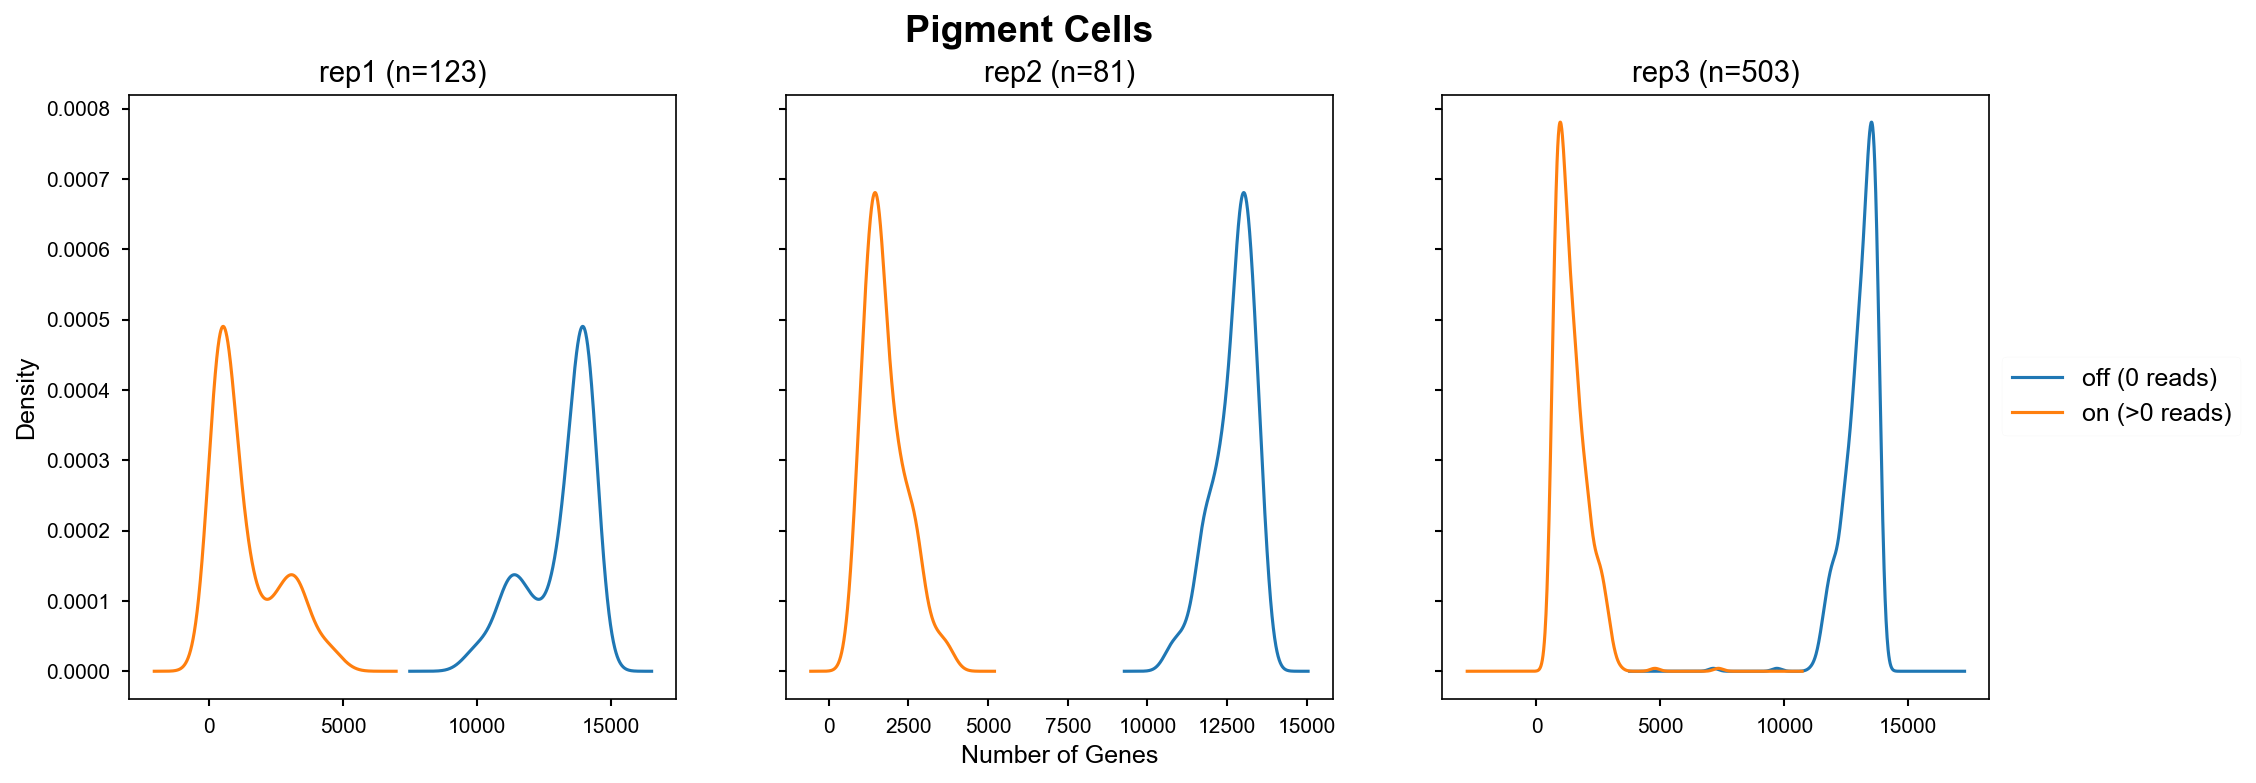

In [14]:
def cell_missing(cluster, rep, ax):
    _dat = raw_w_meta.query(f'cluster == "{cluster}" & rep == "{rep}"').drop(['cluster', 'rep'], axis=1)
    num_cells = _dat.shape[0]
    
    off = (_dat == 0).sum(axis=1)
    off.name = 'off (0 reads)'
    
    on = (_dat > 0).sum(axis=1)
    on.name = 'on (>0 reads)'
    
    pd.concat([off, on], sort=True, axis=1).plot.kde(ax=ax, legend=False)
    ax.set_title(f'{rep} (n={num_cells})')

    
def _plot(cluster):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True)
    cell_missing(cluster, 'rep1', ax1)
    cell_missing(cluster, 'rep2', ax2)
    cell_missing(cluster, 'rep3', ax3)
    fig.suptitle(cluster);
    ax2.set_xlabel('Number of Genes')
    ax3.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    
    
for cluster in nbconfig.sel_cluster_order:
    _plot(cluster)

## Missingness among replicates

To expand the above view I calculated the empirical distribution of missingness between replicates using sampling. I compared each replicate in a pairwise fashion and iteratively (n=1000) sampled 1 cell from each replicate with replacement. I compared counts of genes that were off (0 reads) in both replicates (blue line) on (>0 reads) in both replicates (red line), genes on in only one replicate (orange and green lines). Ideally the blue line would be at zero and the other red line would be towards the right. However, this is not possible in single cell data, so ideally the distributions would be similar among plots.

As above the distribution of missingness is different among replicates (compare blue lines within row), with replicate 2 appearing to more different in terms of missingness. There are also larger differences across clusters (cell types; compare across rows). Here Early 1º Spermatocytes show the most unique patterns.

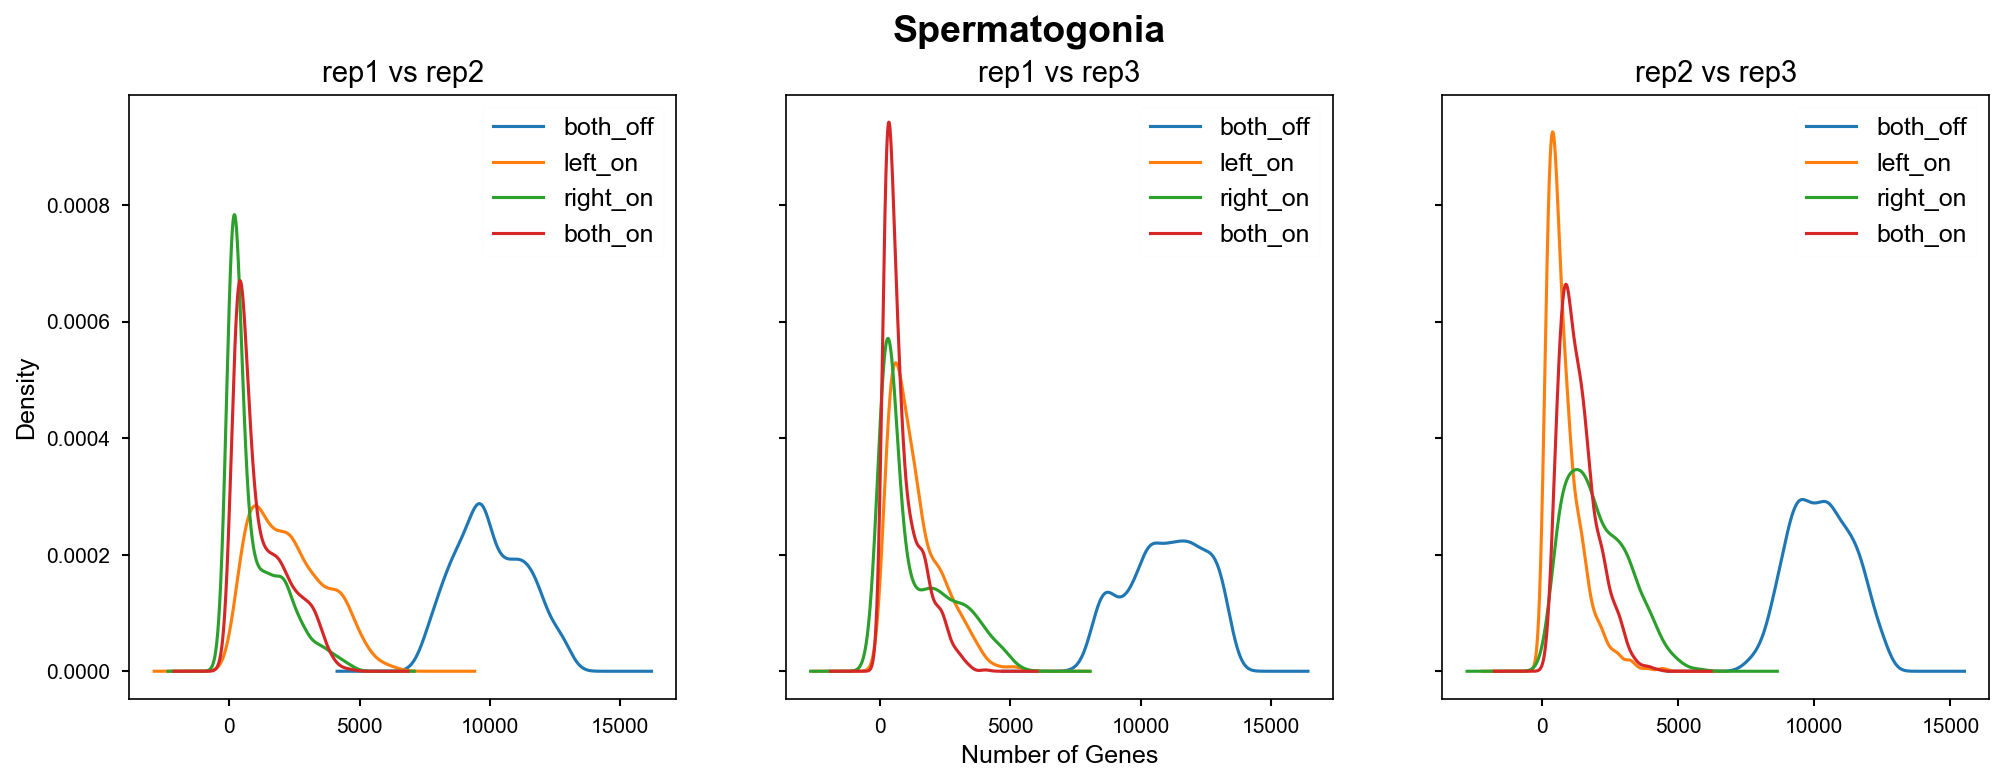

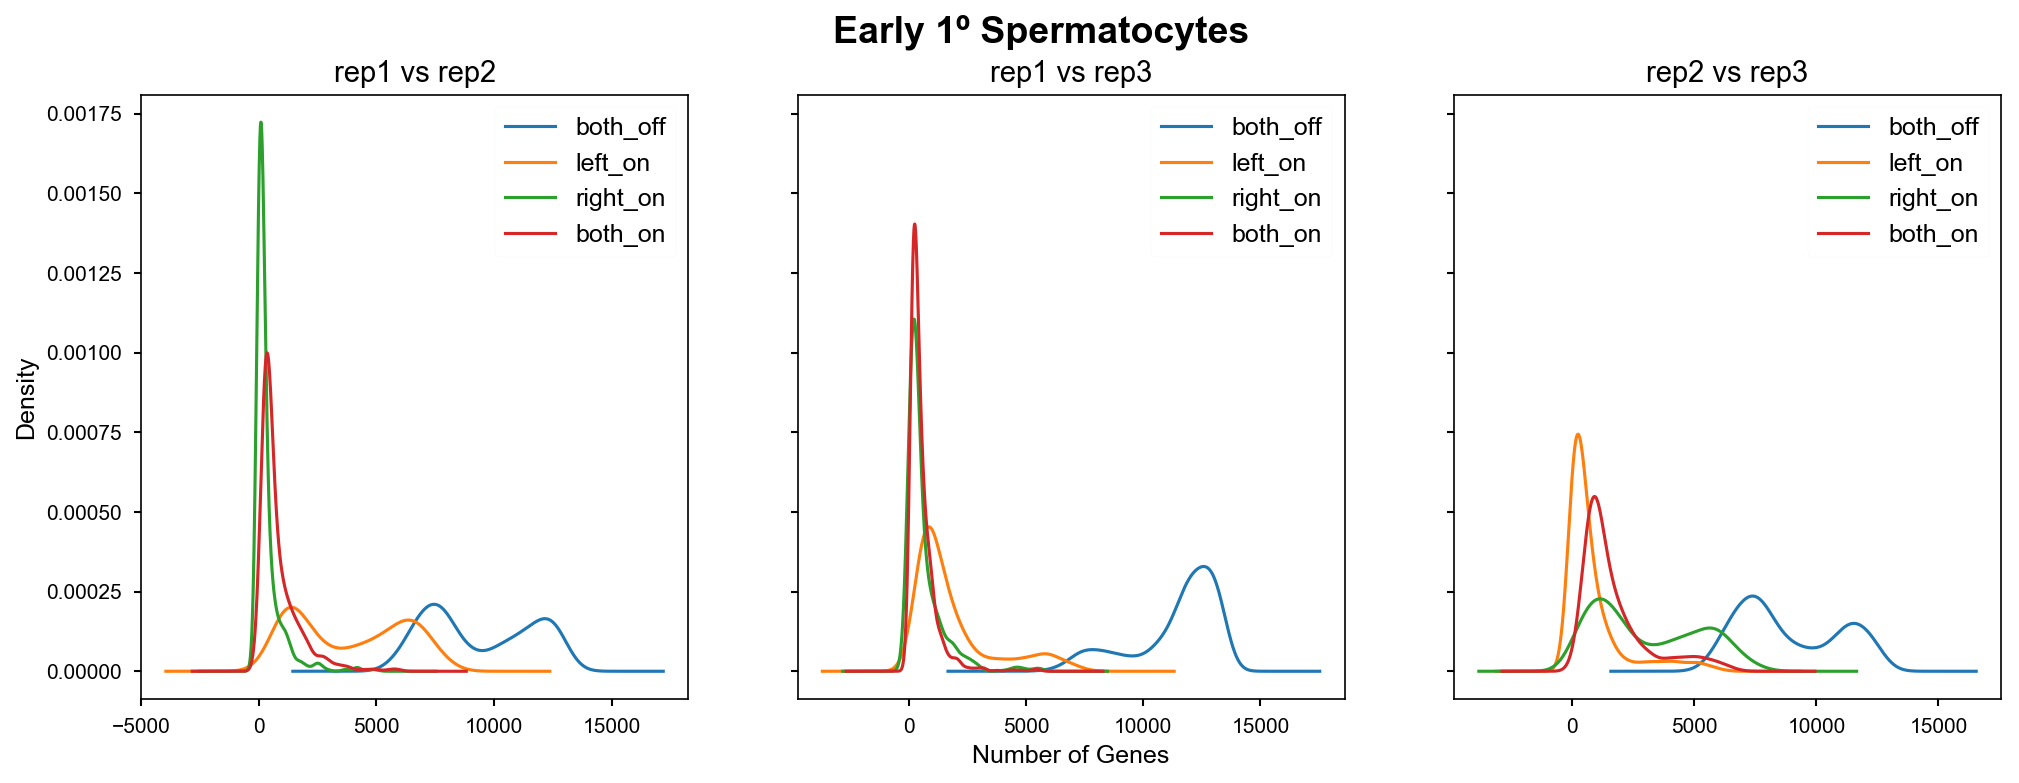

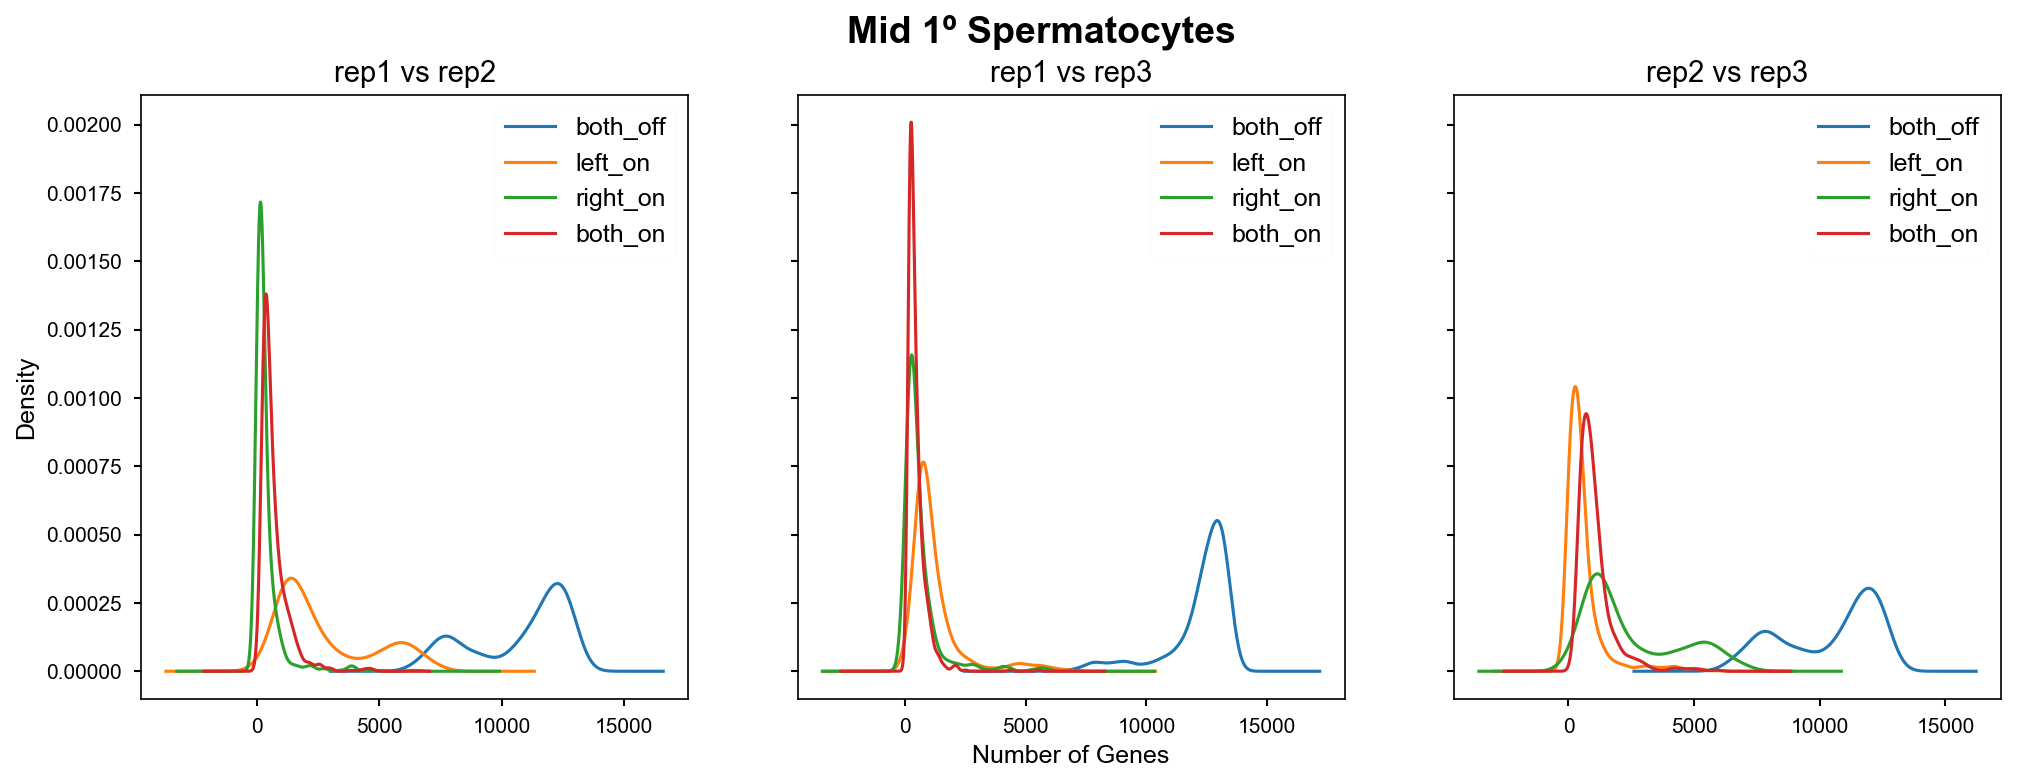

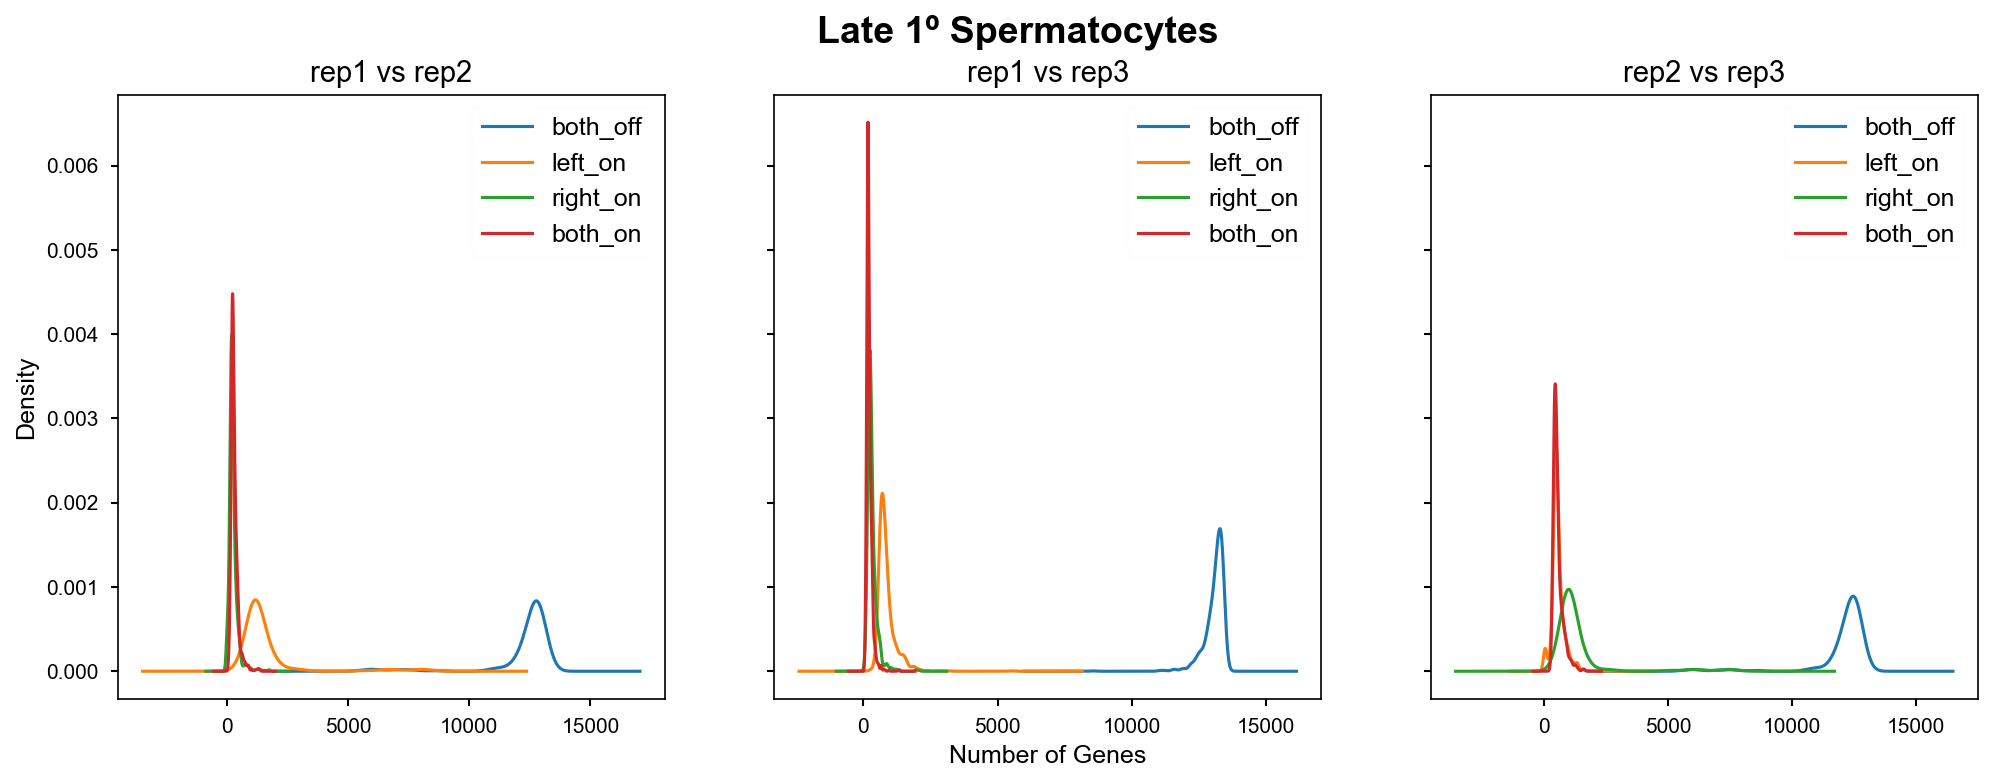

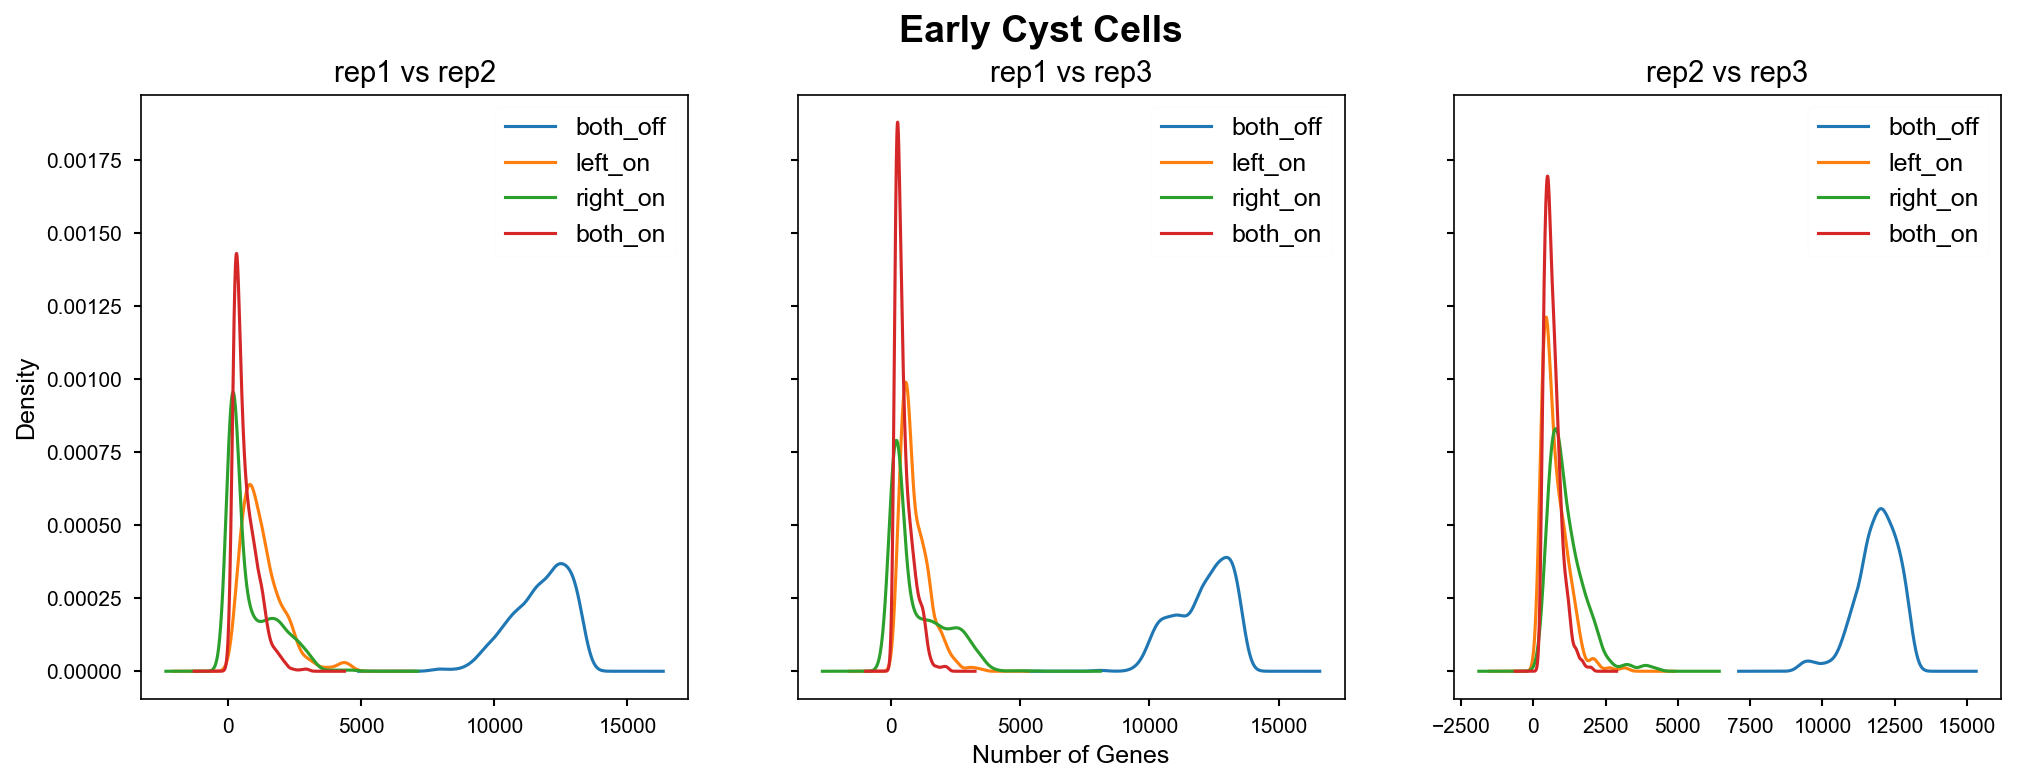

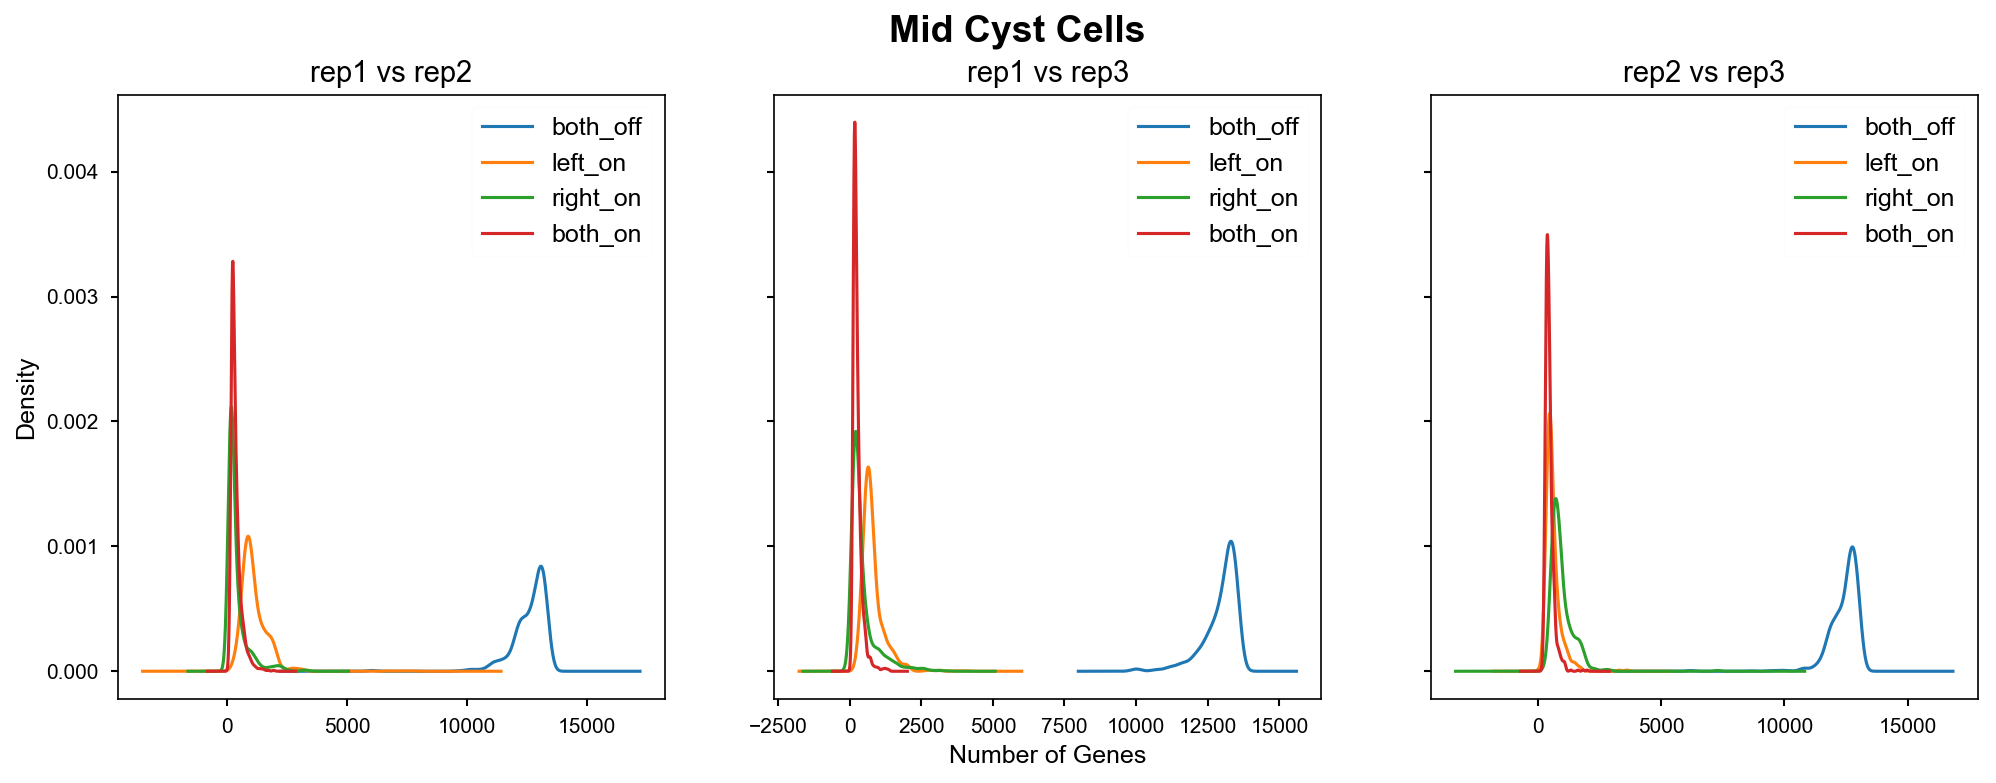

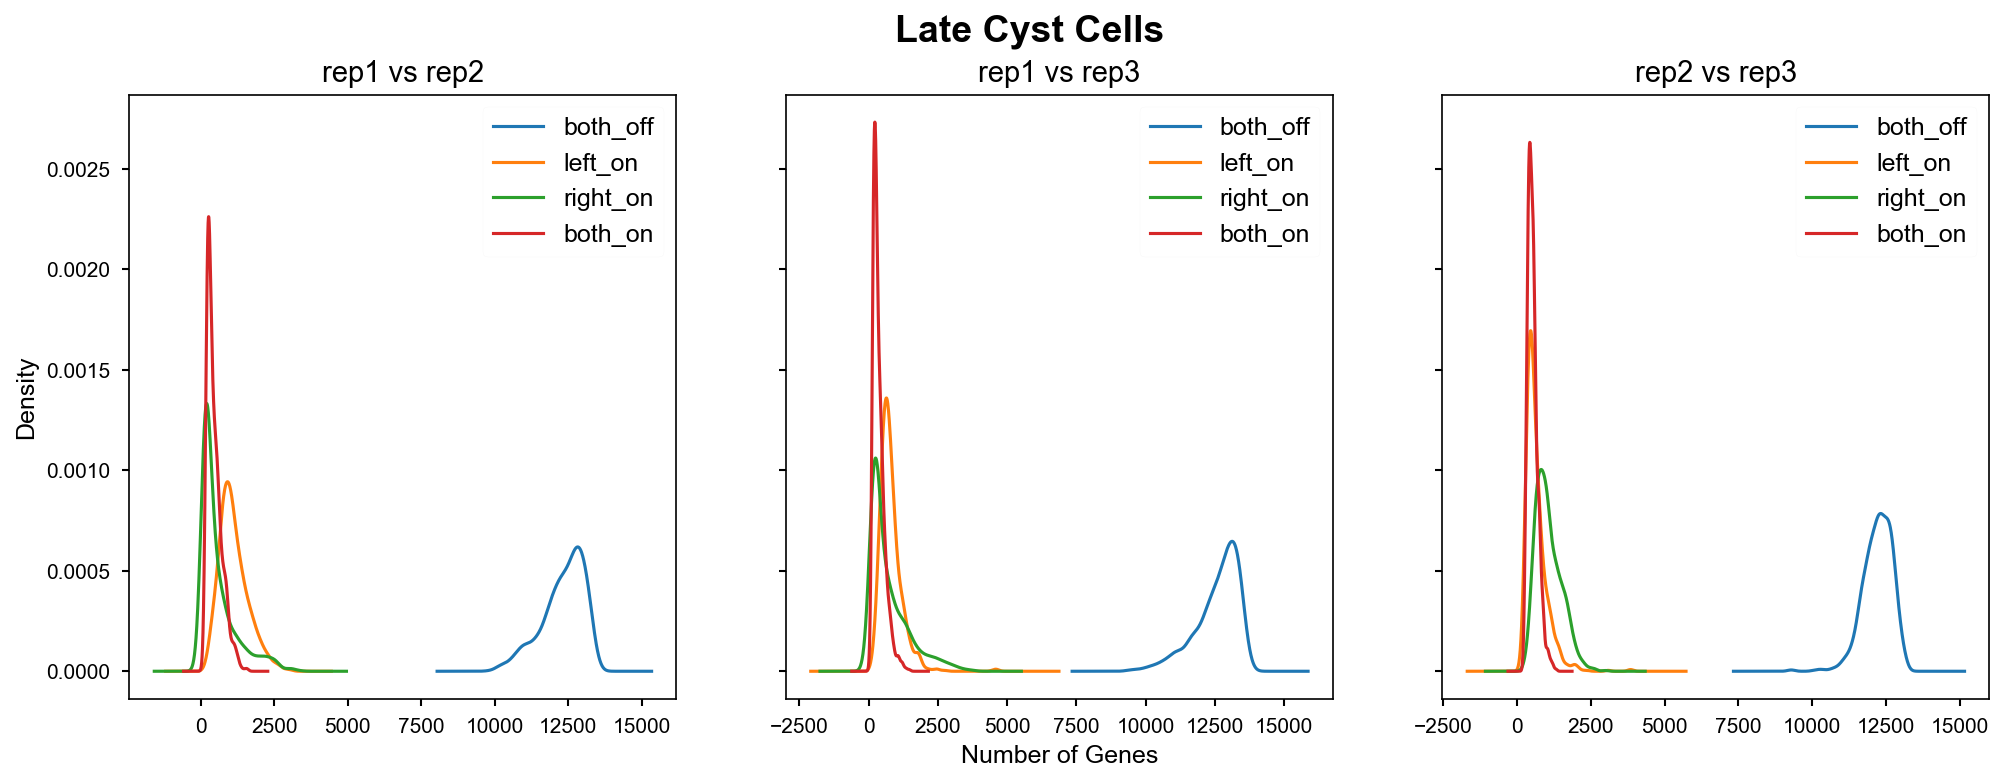

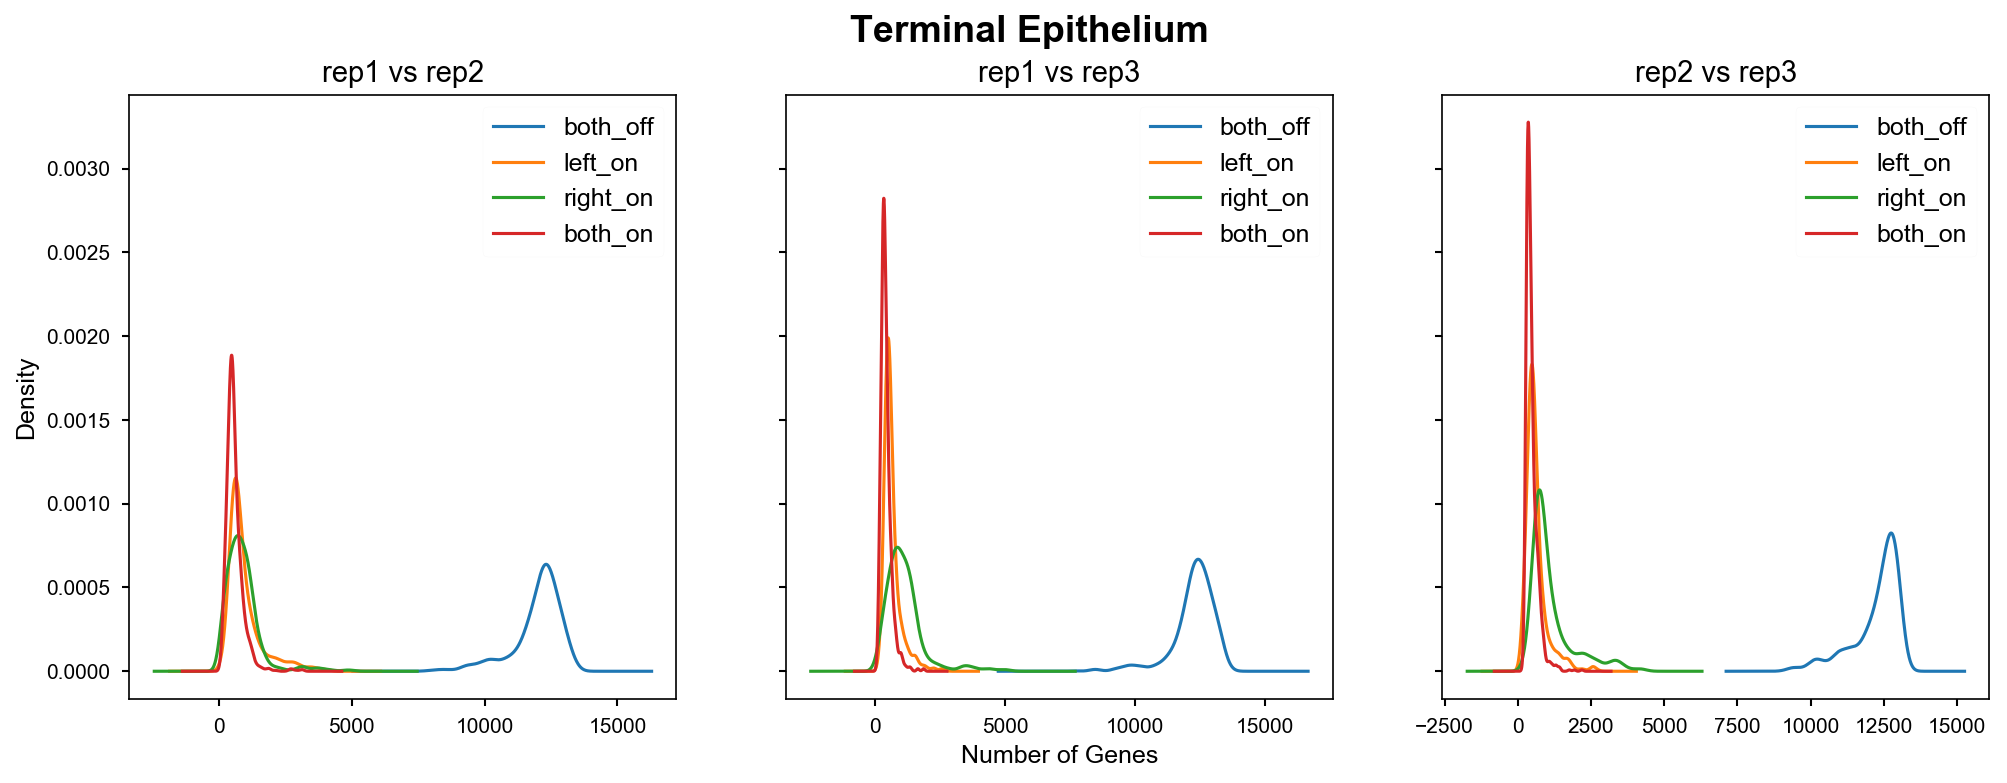

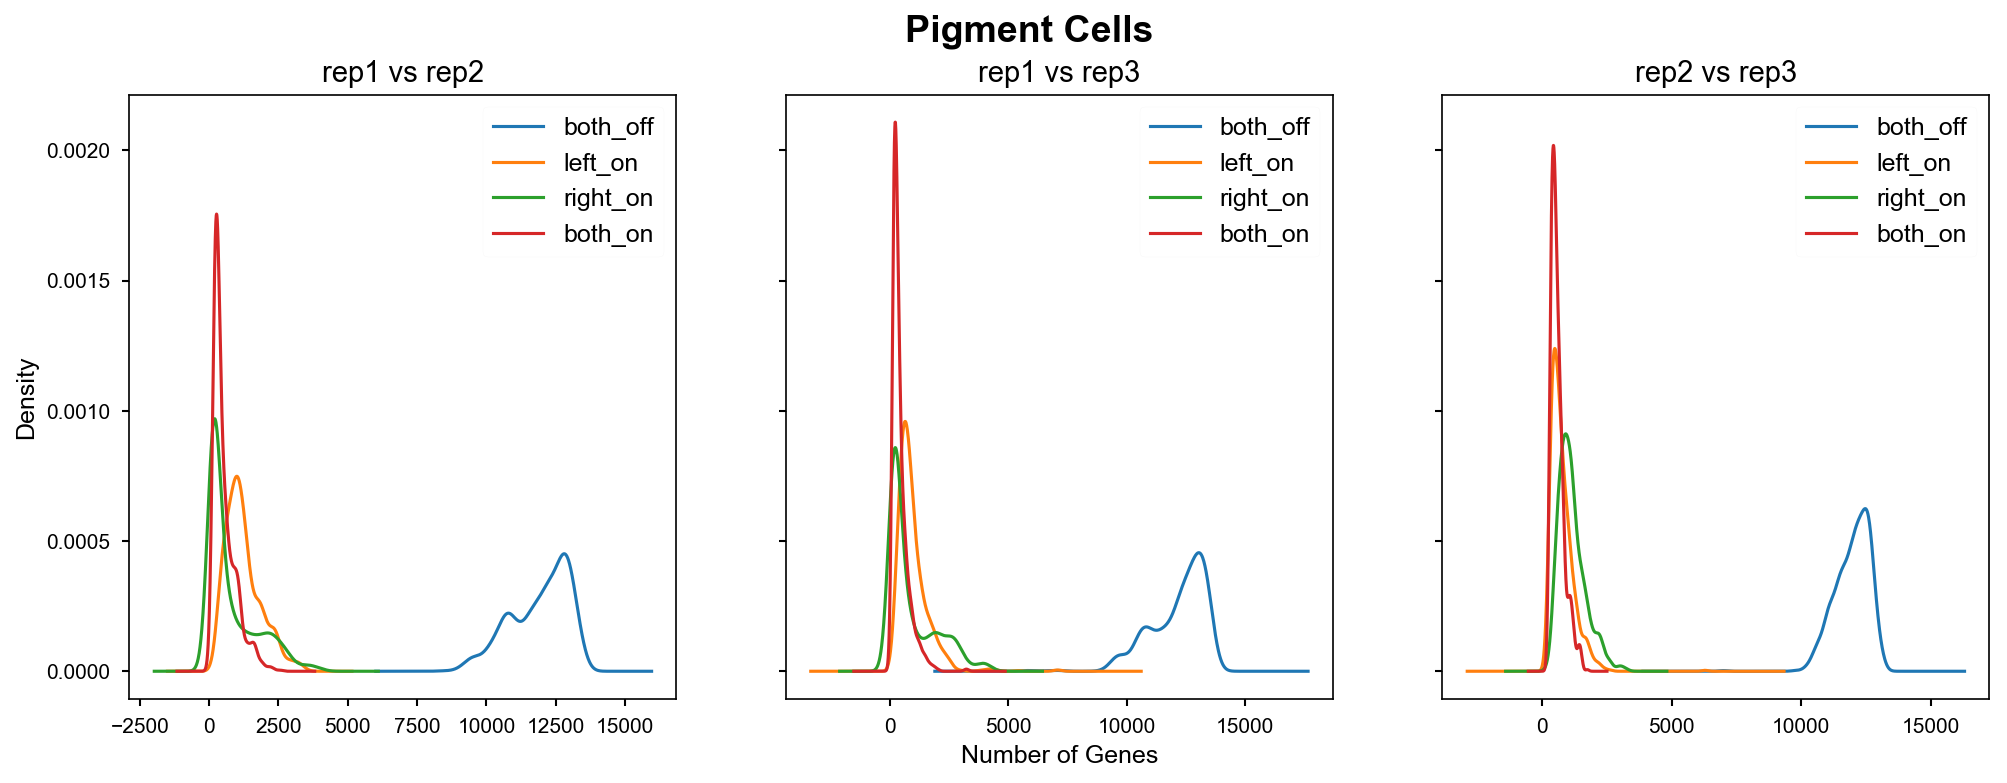

In [5]:
def sample(cluster, repA, repB, ax):
    _dat1 = raw_w_meta.query(f'cluster == "{cluster}" & rep == "{repA}"').drop(['cluster', 'rep'], axis=1)
    _dat2 = raw_w_meta.query(f'cluster == "{cluster}" & rep == "{repB}"').drop(['cluster', 'rep'], axis=1)

    res = []
    for i in range(1000):
        # Flag all genes that have 0 reads
        c1 = _dat1.sample().T.iloc[:, 0] == 0
        c2 = _dat2.sample().T.iloc[:, 0] == 0

        both_off = c1 & c2
        left = c1 > c2
        right = c1 < c2
        both_on = ~c1 & ~c2
        res.append([both_off.sum(), left.sum(), right.sum(), both_on.sum()])

    pd.DataFrame(res, columns=['both_off', 'left_on', 'right_on', 'both_on']).plot.kde(ax=ax)
    ax.set_title(f'{repA} vs {repB}')

    
def _plot(cluster):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(1/3), sharey=True)
    sample(cluster, 'rep1', 'rep2', ax1)
    sample(cluster, 'rep1', 'rep3', ax2)
    sample(cluster, 'rep2', 'rep3', ax3)
    fig.suptitle(cluster);
    ax2.set_xlabel('Number of Genes')
    
    
for cluster in nbconfig.sel_cluster_order:
    _plot(cluster)

## Missingness among chromosomes

The main focus on this project is comparing X to autosome expression. Next I wanted to see if missingness was correlated with chromosomal arm. I repeated the sampling scheme as above, except I split counts out by chromosome arm. The distribution of missing genes is very similar across chromosome arm, except for the 4th and Y. Note I have set the x-axis to be the same on the plots, the 4th and Y look strange b/c they have few genes compared to the other major arms.

These data show that missingness does not appear to have any bias towards a given chromosomal arm. This would indicate that internal comparisons among chromosomal arms within a cluster is probably better than trying to compare across clusters. 

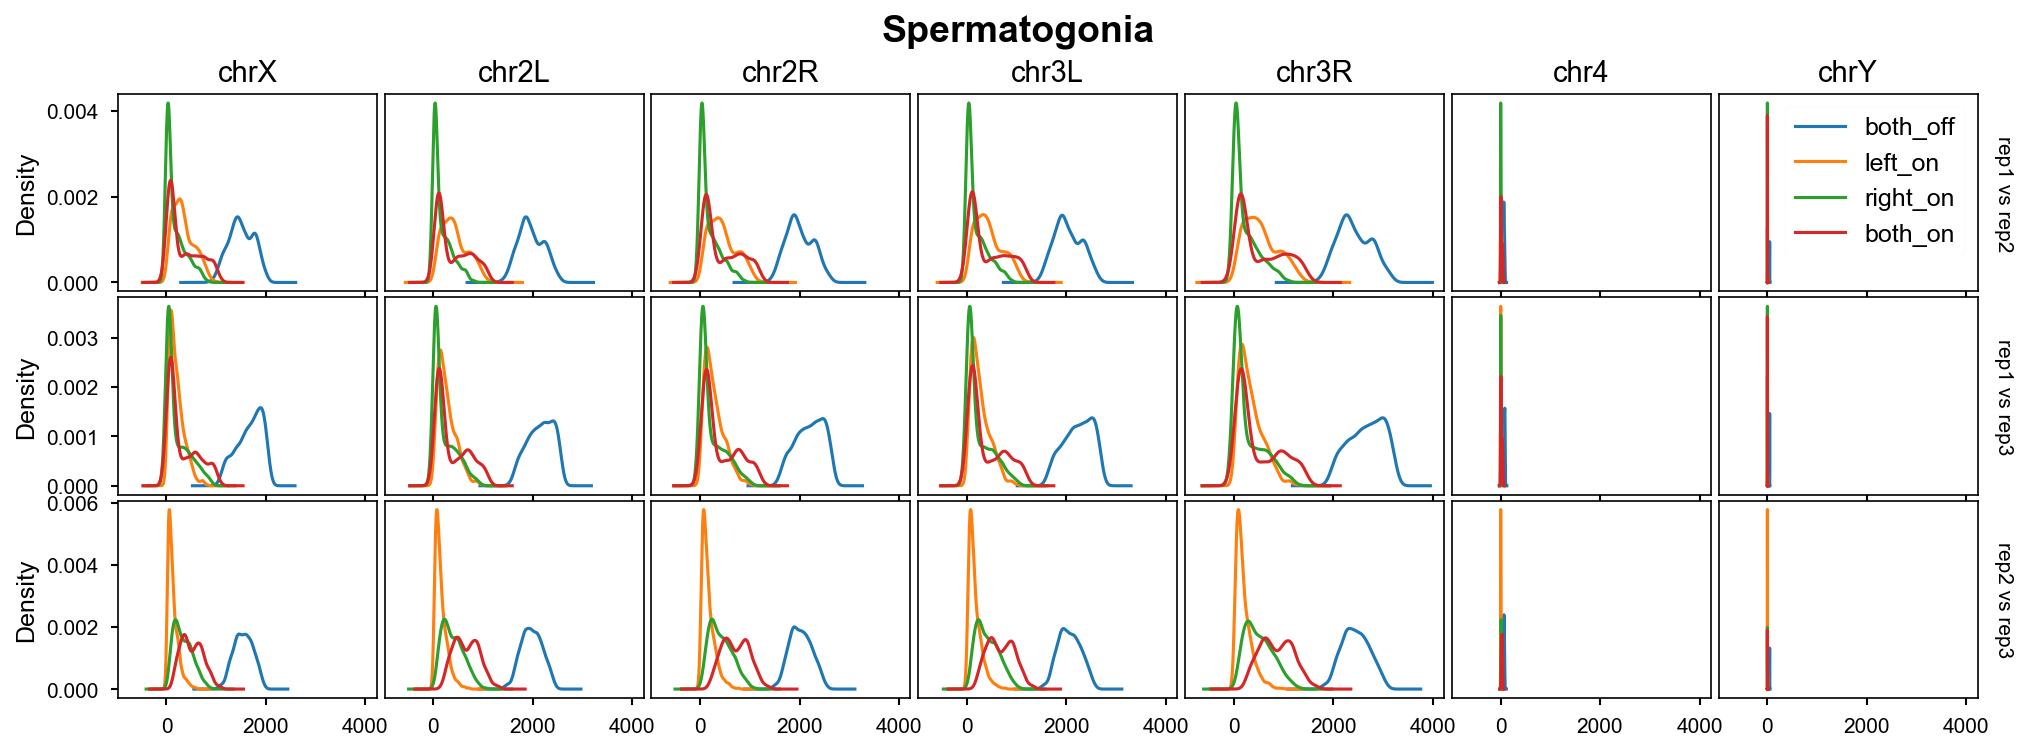

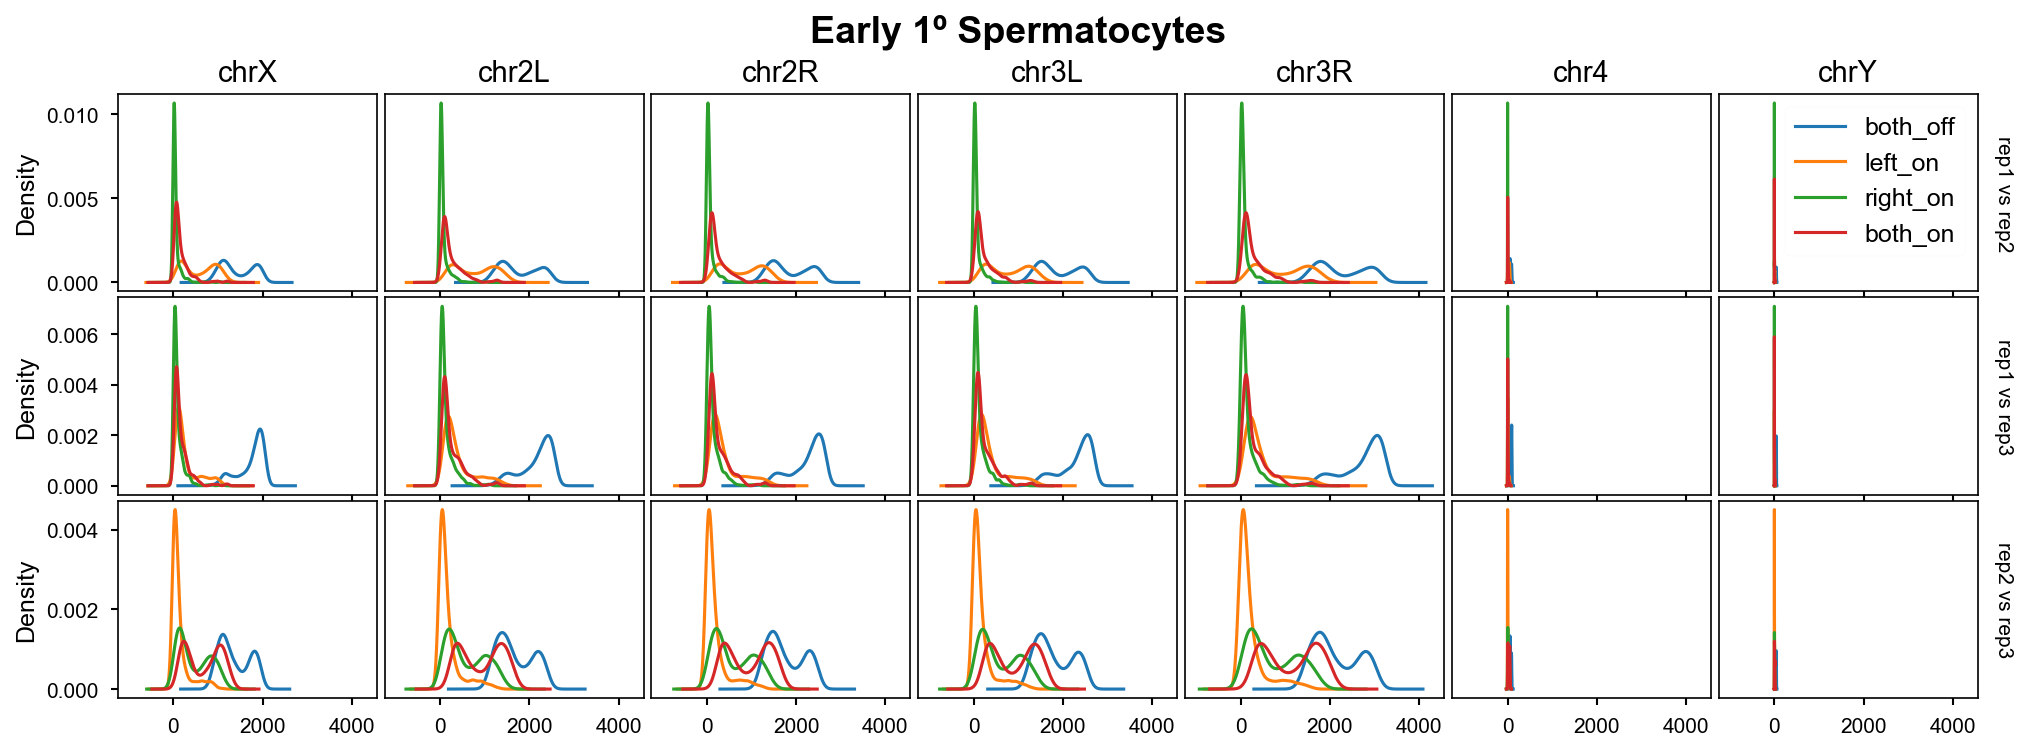

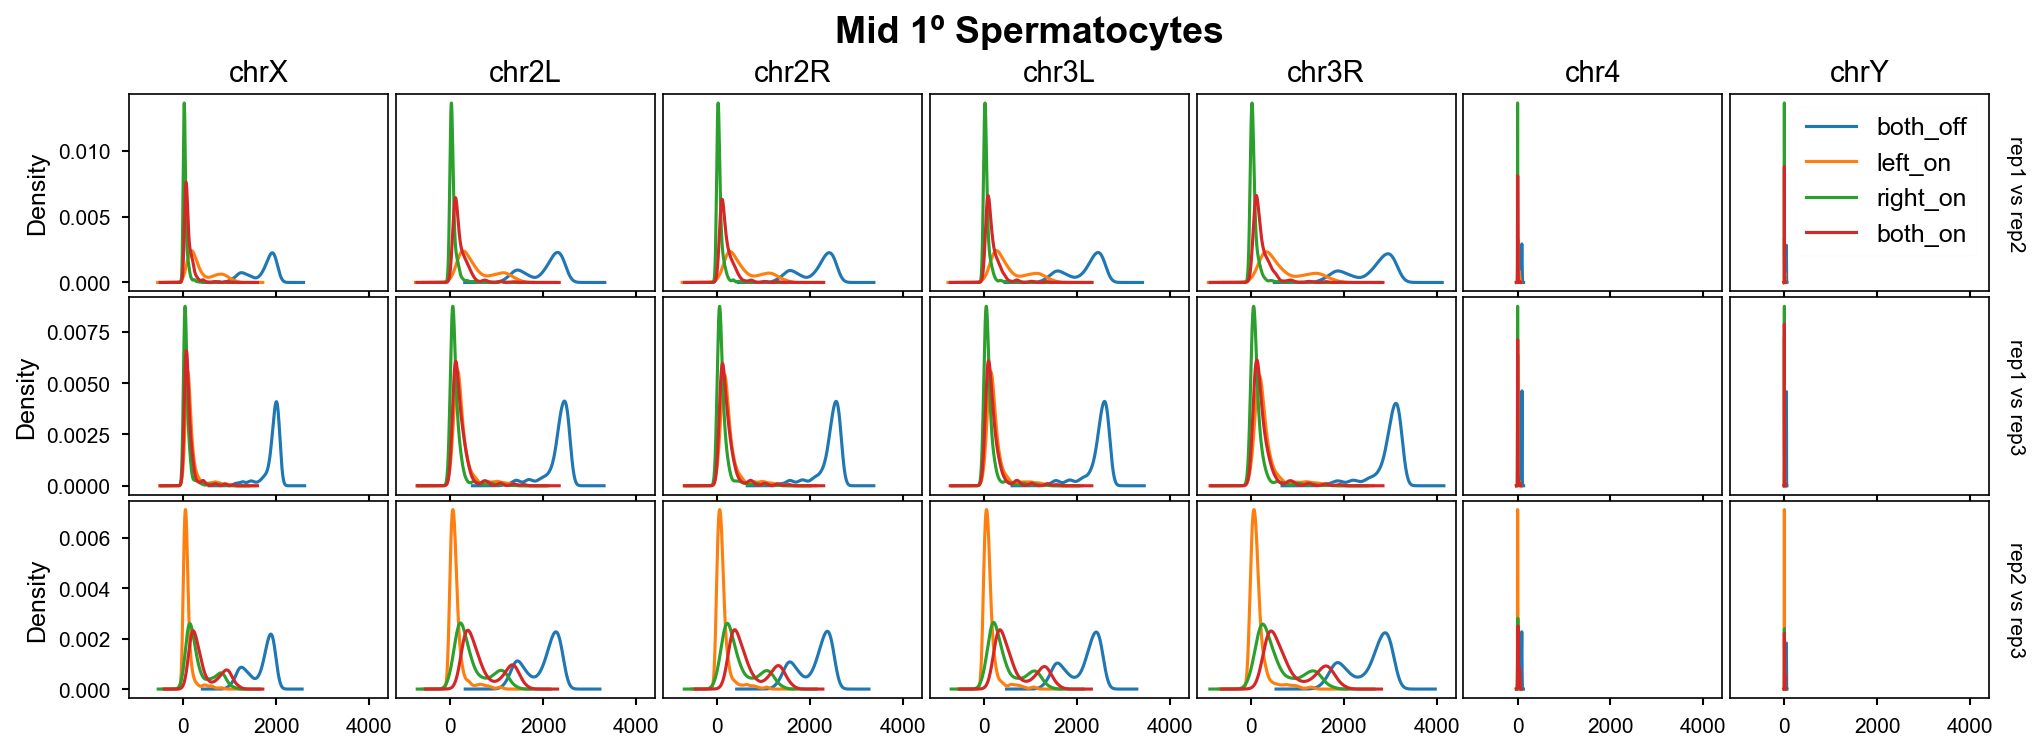

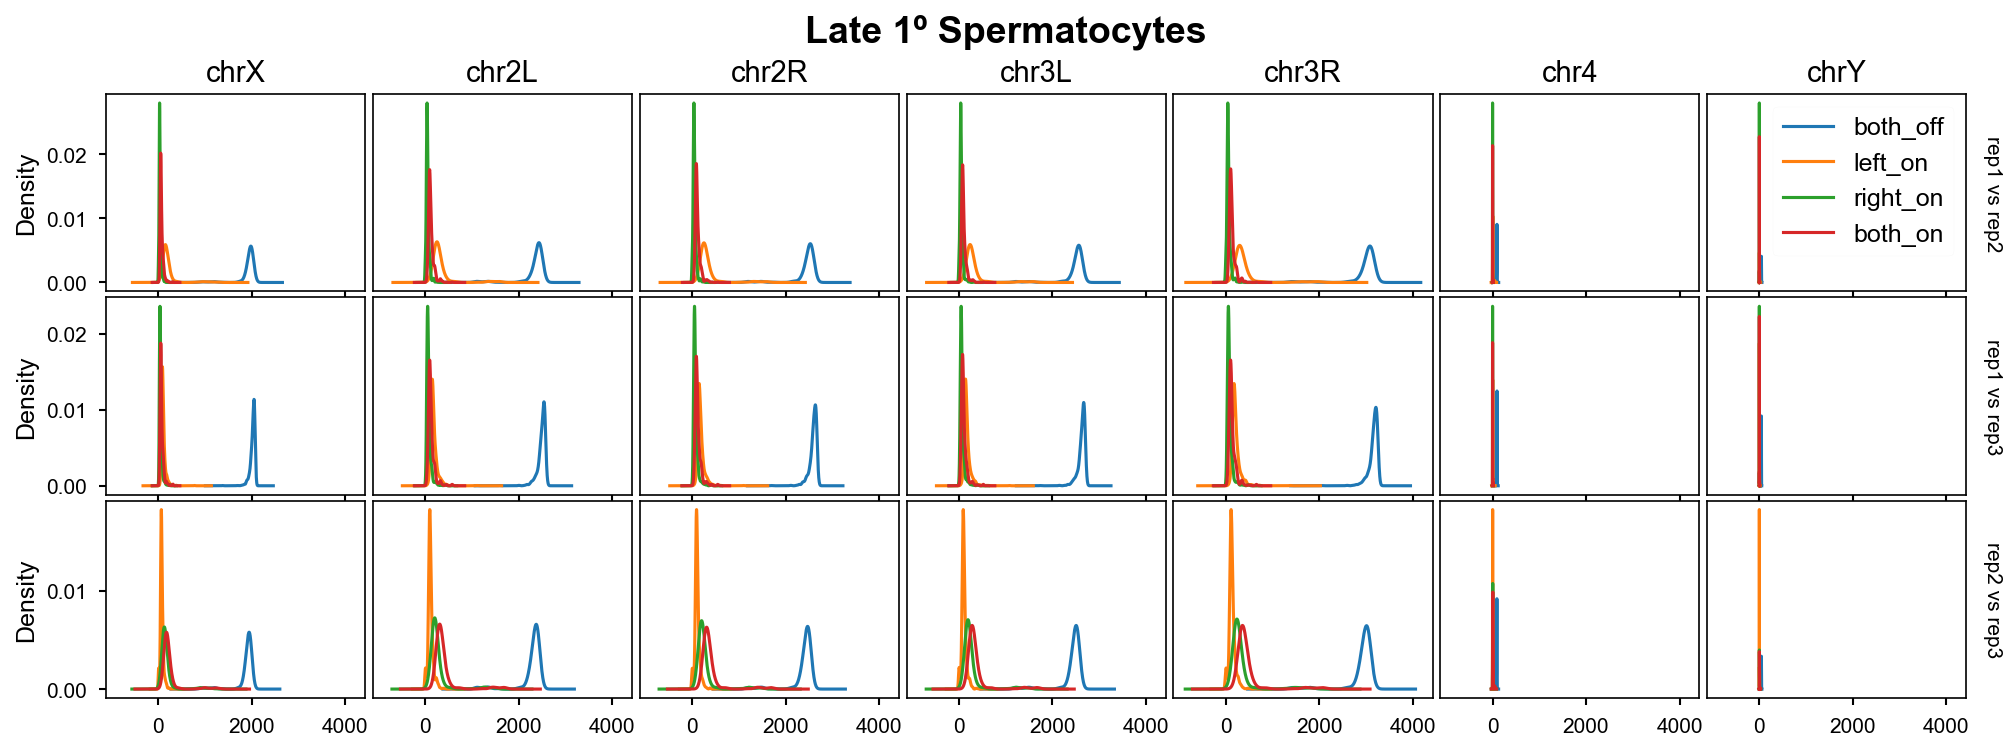

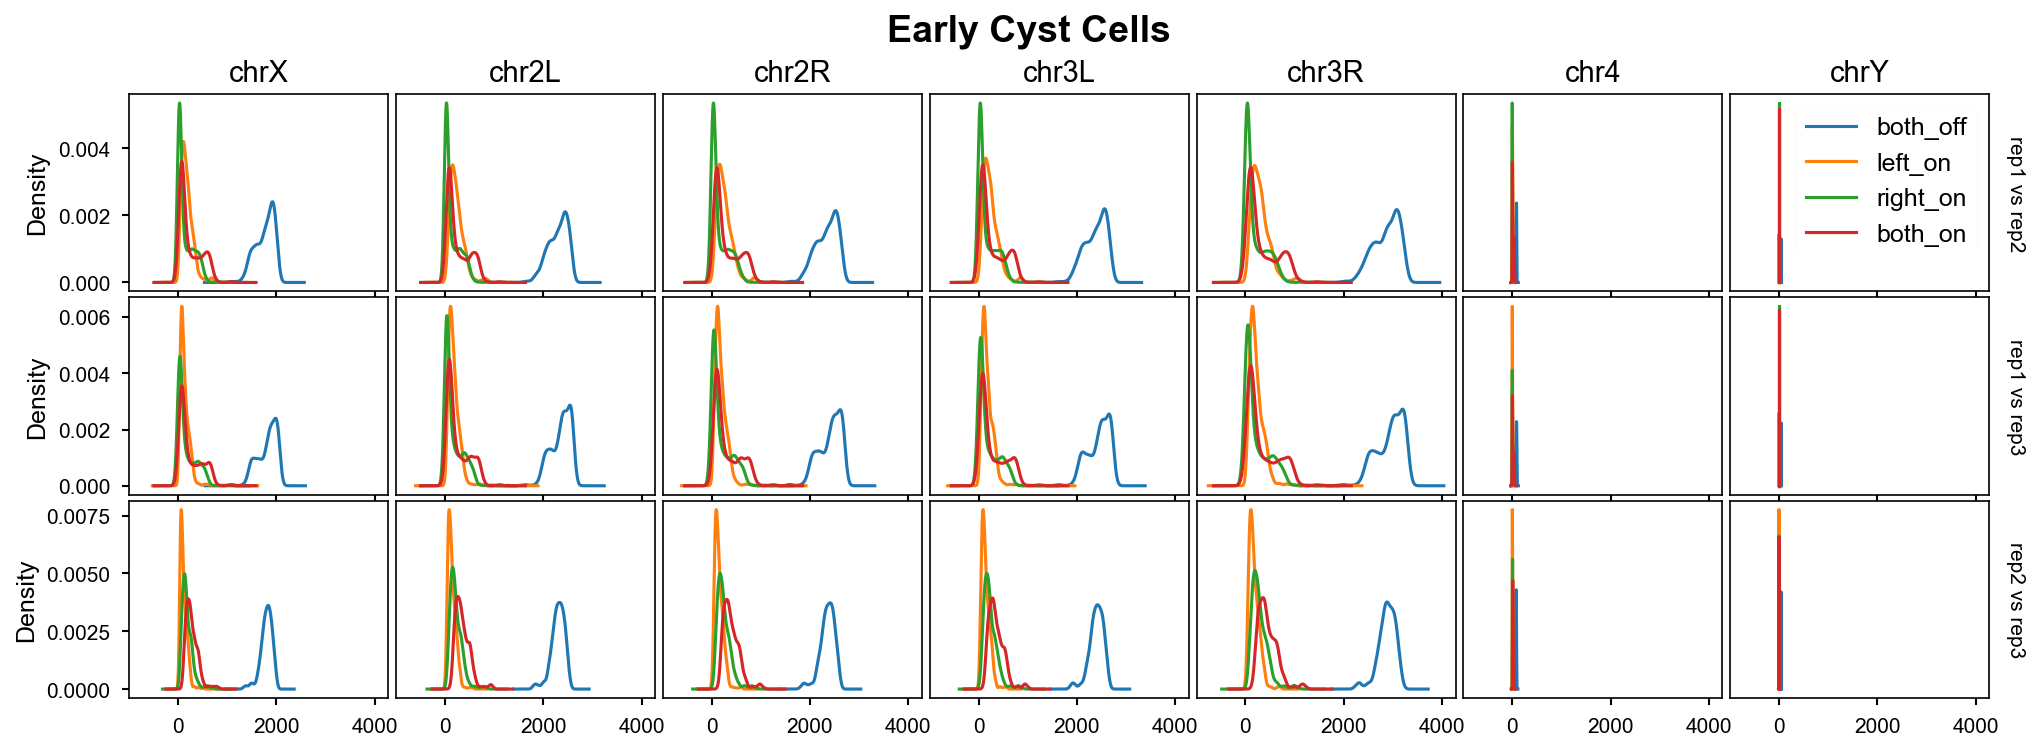

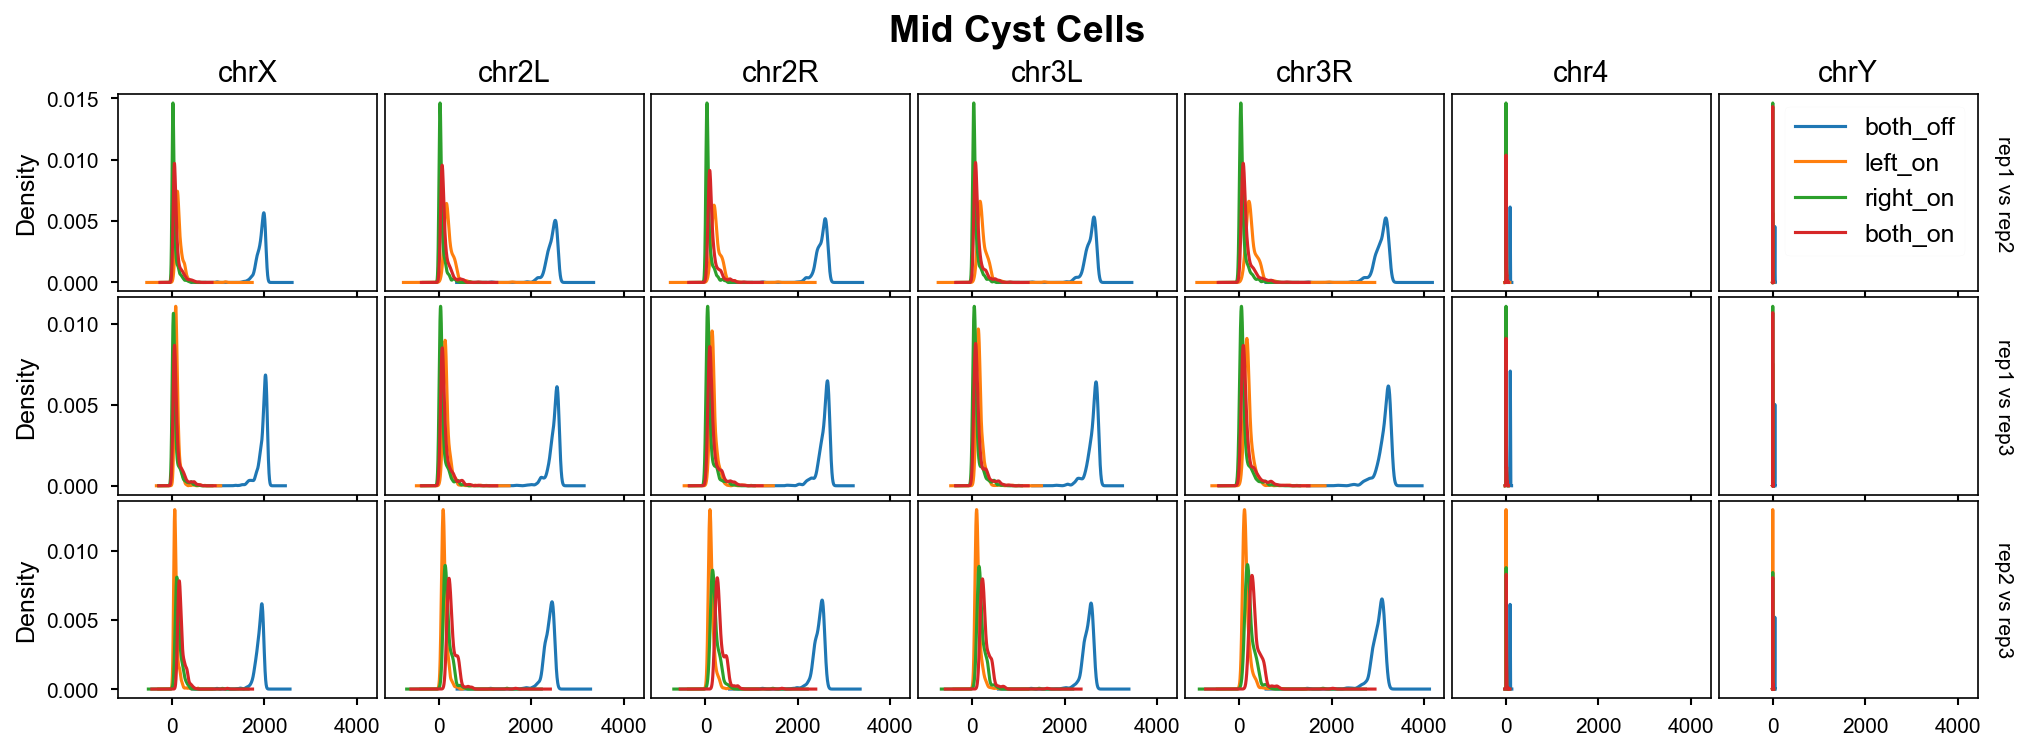

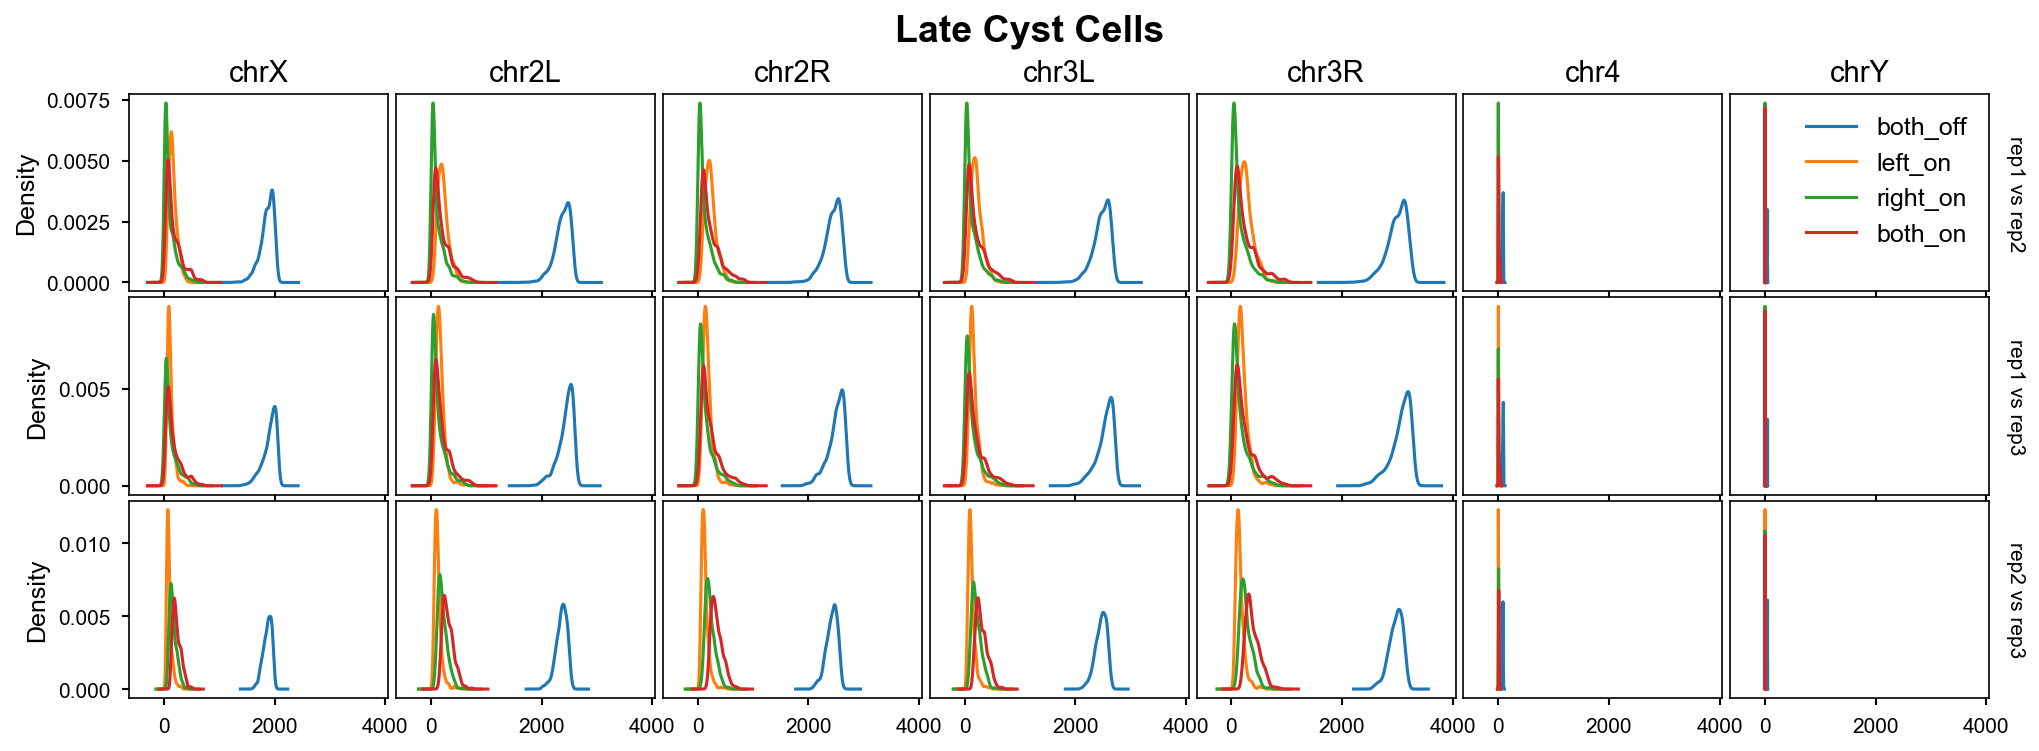

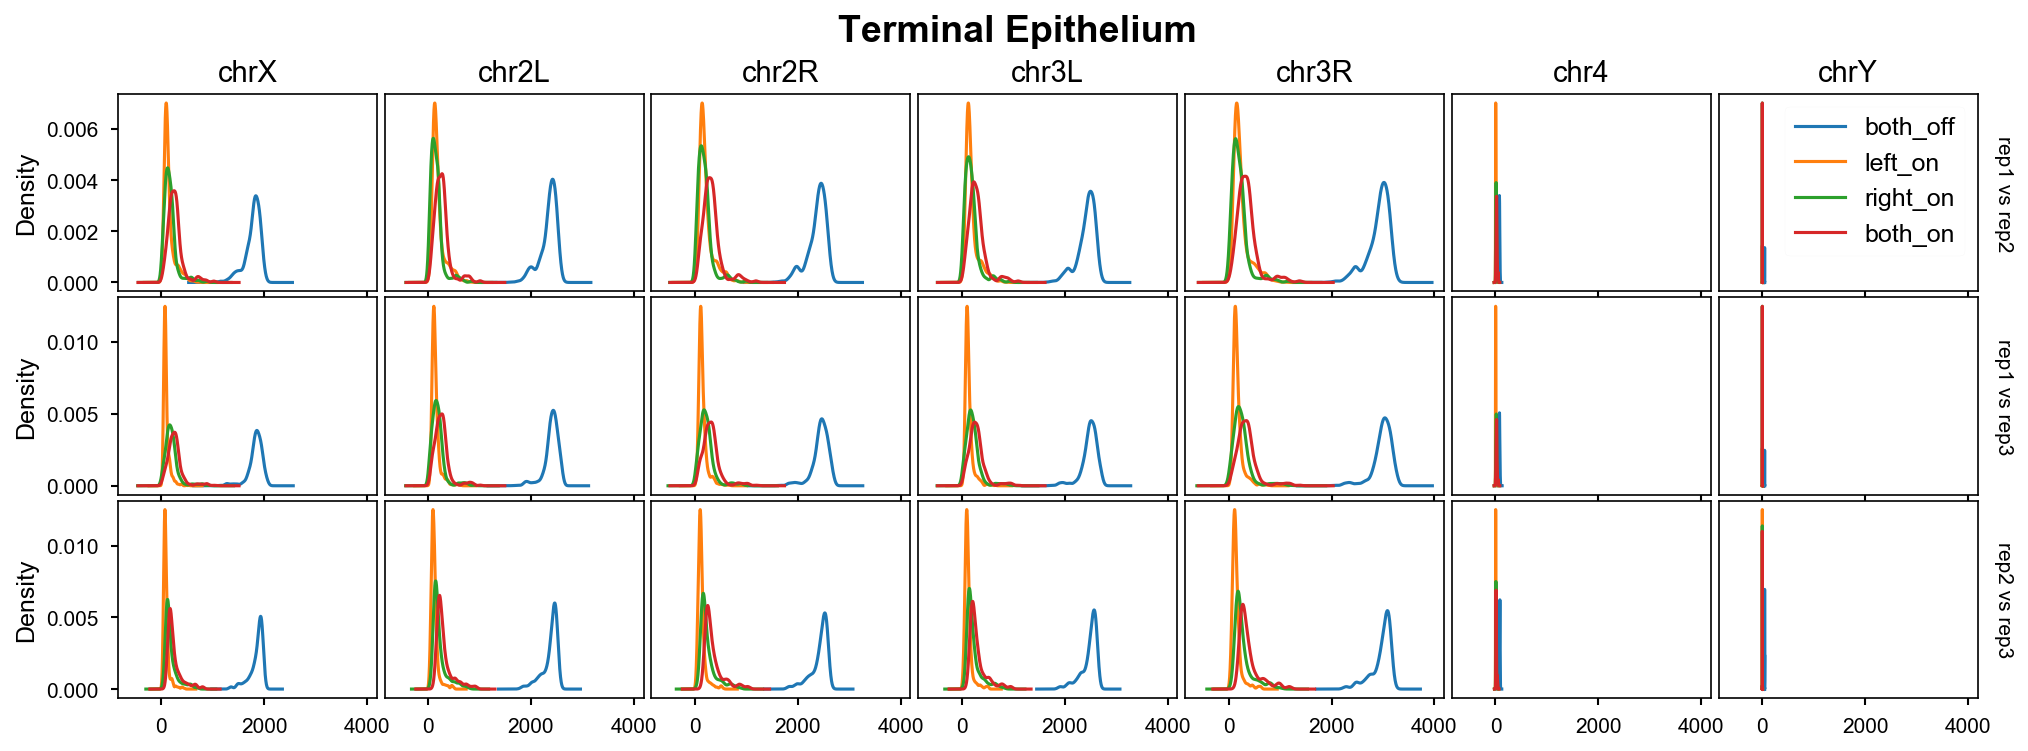

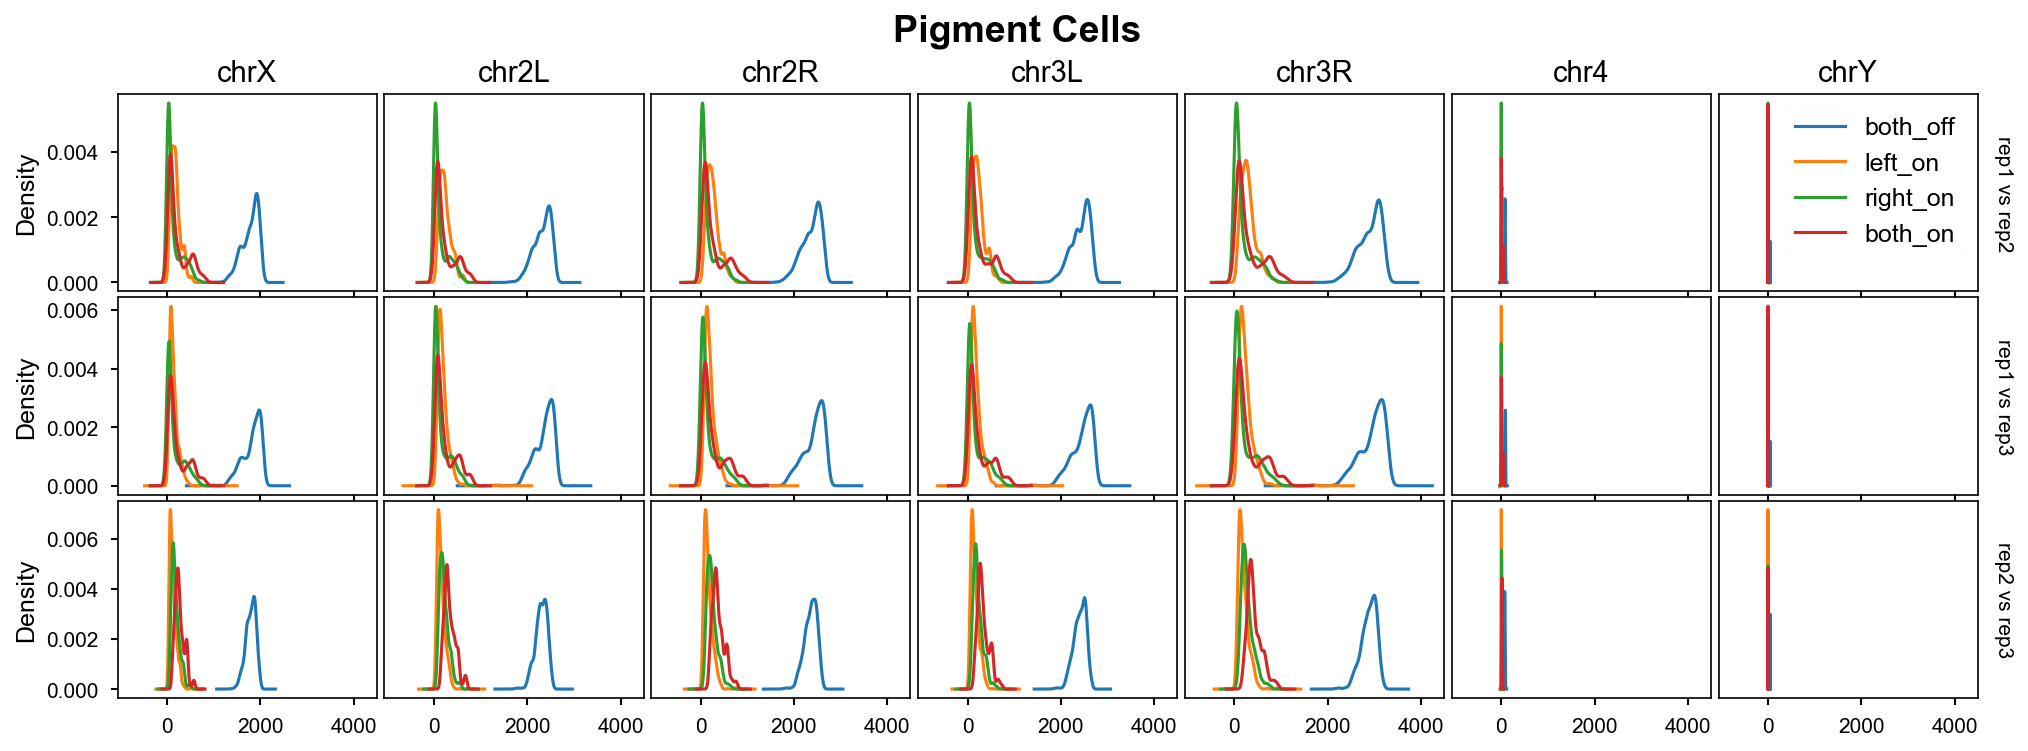

In [6]:
chroms = nbconfig.fbgn2chrom.chrom

def sample2(cluster, repA, repB, axes, title=False):
    _dat1 = raw_w_meta.query(f'cluster == "{cluster}" & rep == "{repA}"').drop(['cluster', 'rep'], axis=1)
    _dat2 = raw_w_meta.query(f'cluster == "{cluster}" & rep == "{repB}"').drop(['cluster', 'rep'], axis=1)

    res = defaultdict(list)
    for i in range(1000):
        # Flag all genes that have 0 reads
        c1 = _dat1.sample().T.iloc[:, 0] == 0
        c2 = _dat2.sample().T.iloc[:, 0] == 0

        for c in nbconfig.chrom_order[:7]:
            _genes = chroms.index[chroms == c]
            _c1 = c1.reindex(_genes).dropna()
            _c2 = c2.reindex(_genes).dropna()

            both_off = _c1 & _c2
            left = _c1 > _c2
            right = _c1 < _c2
            both_on = ~_c1 & ~_c2

            res[c].append([both_off.sum(), left.sum(), right.sum(), both_on.sum()])

    results = {}
    for k, v in res.items():
        results[k] = pd.DataFrame(v, columns=['both_off', 'left_on', 'right_on', 'both_on'])

    for ax, (c, dd) in zip(axes, results.items()):
        dd.plot.kde(ax=ax, legend=False)
        if title:
            ax.set_title(c)

    axes[-1].text(1.1, 0.5, f'{repA} vs {repB}', transform=ax.transAxes, 
                  rotation=-90, ha='center', va='center', fontsize=10)

    
def _plot(cluster):
    fig, axes = plt.subplots(3, 7, sharex=True, figsize=plt.figaspect(1/3), gridspec_kw=dict(wspace=0.03, hspace=0.03))
    sample2(cluster, 'rep1', 'rep2', axes[0, :], title=True)
    sample2(cluster, 'rep1', 'rep3', axes[1, :])
    sample2(cluster, 'rep2', 'rep3', axes[2, :])

    for ax in axes[:, 1:].flatten():
        ax.yaxis.set_visible(False)

    fig.suptitle(cluster);
    axes[0, -1].legend();

    
for cluster in nbconfig.sel_cluster_order:
    _plot(cluster)

## Missingness by gene expression

Next I wanted to check missingness and its relation to the magnitude of gene expression. To do this I took bulk RNA-Seq (median raw gene counts across 4 replicates) and ranked genes by expression. I then split these genes into deciles, but only 7 unique bins were possible, so I present 7 groups {low, bin2, bin3, medium, bin5, bin6, high}. I then plot missingness for each bin. There is a relationship of expression magnitude with missingness and there is an interaction across replicates and across clusters. 

* Even genes that are highly expressed are missing in the single cell data (blue line never centers at 0 in the High category). 
* Distributions of off/on begin to overlap around the medium expression in gonia and early 1º spermatocytes, but not for other clusters.

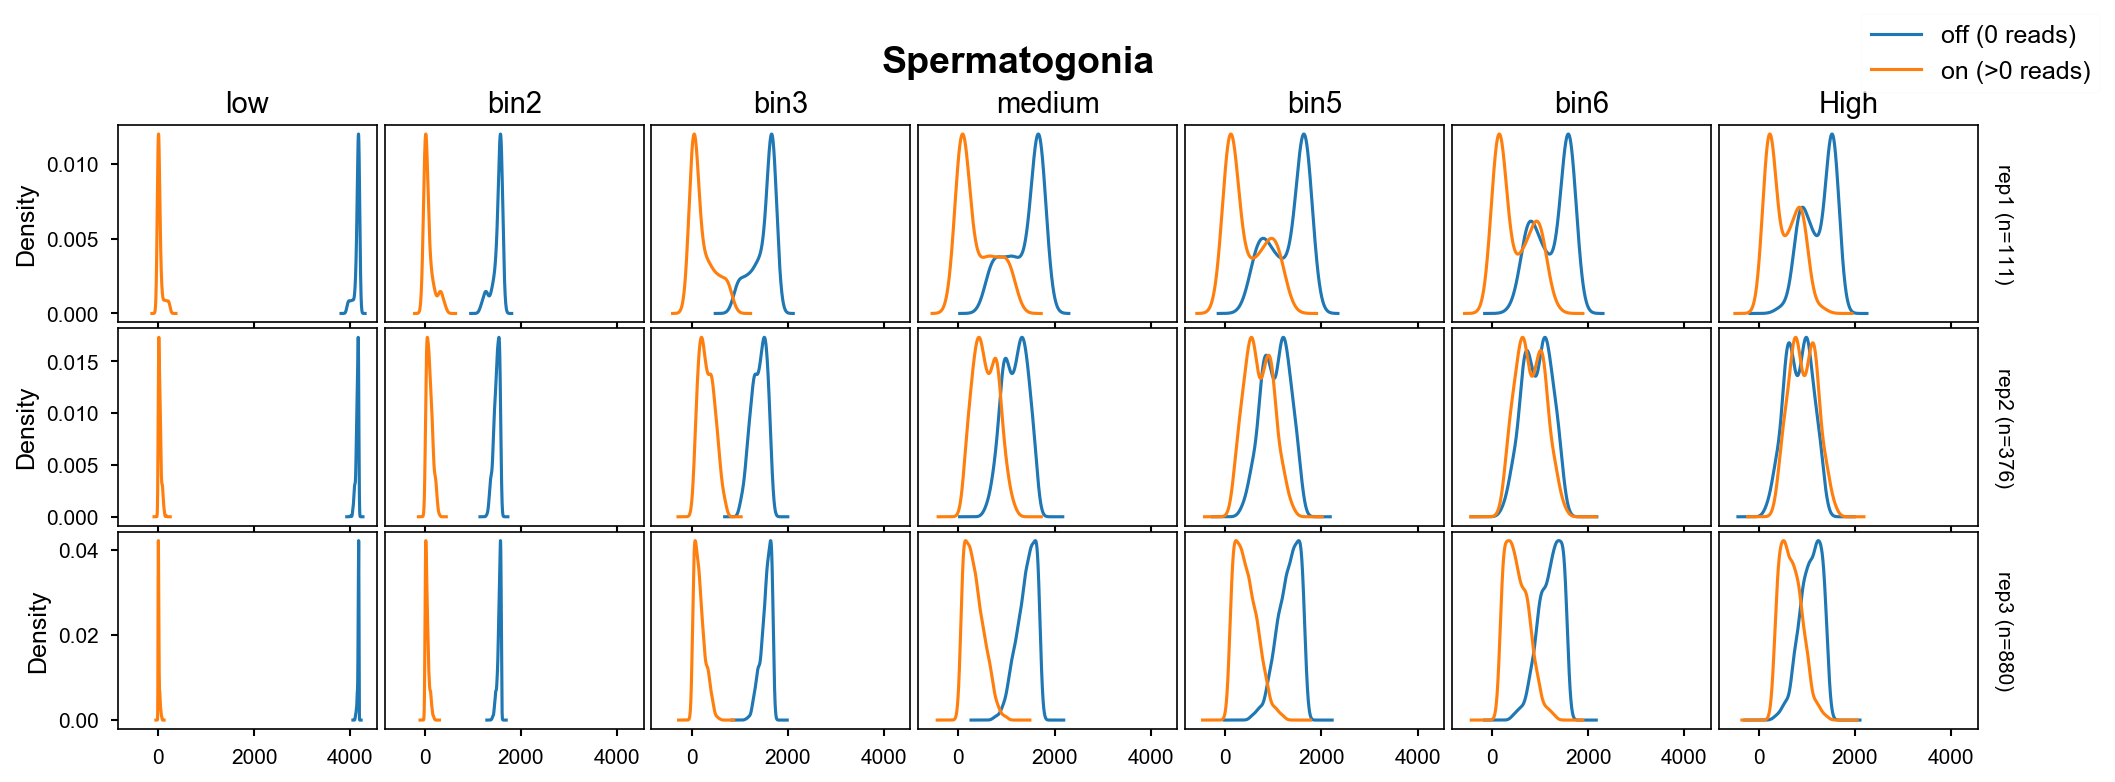

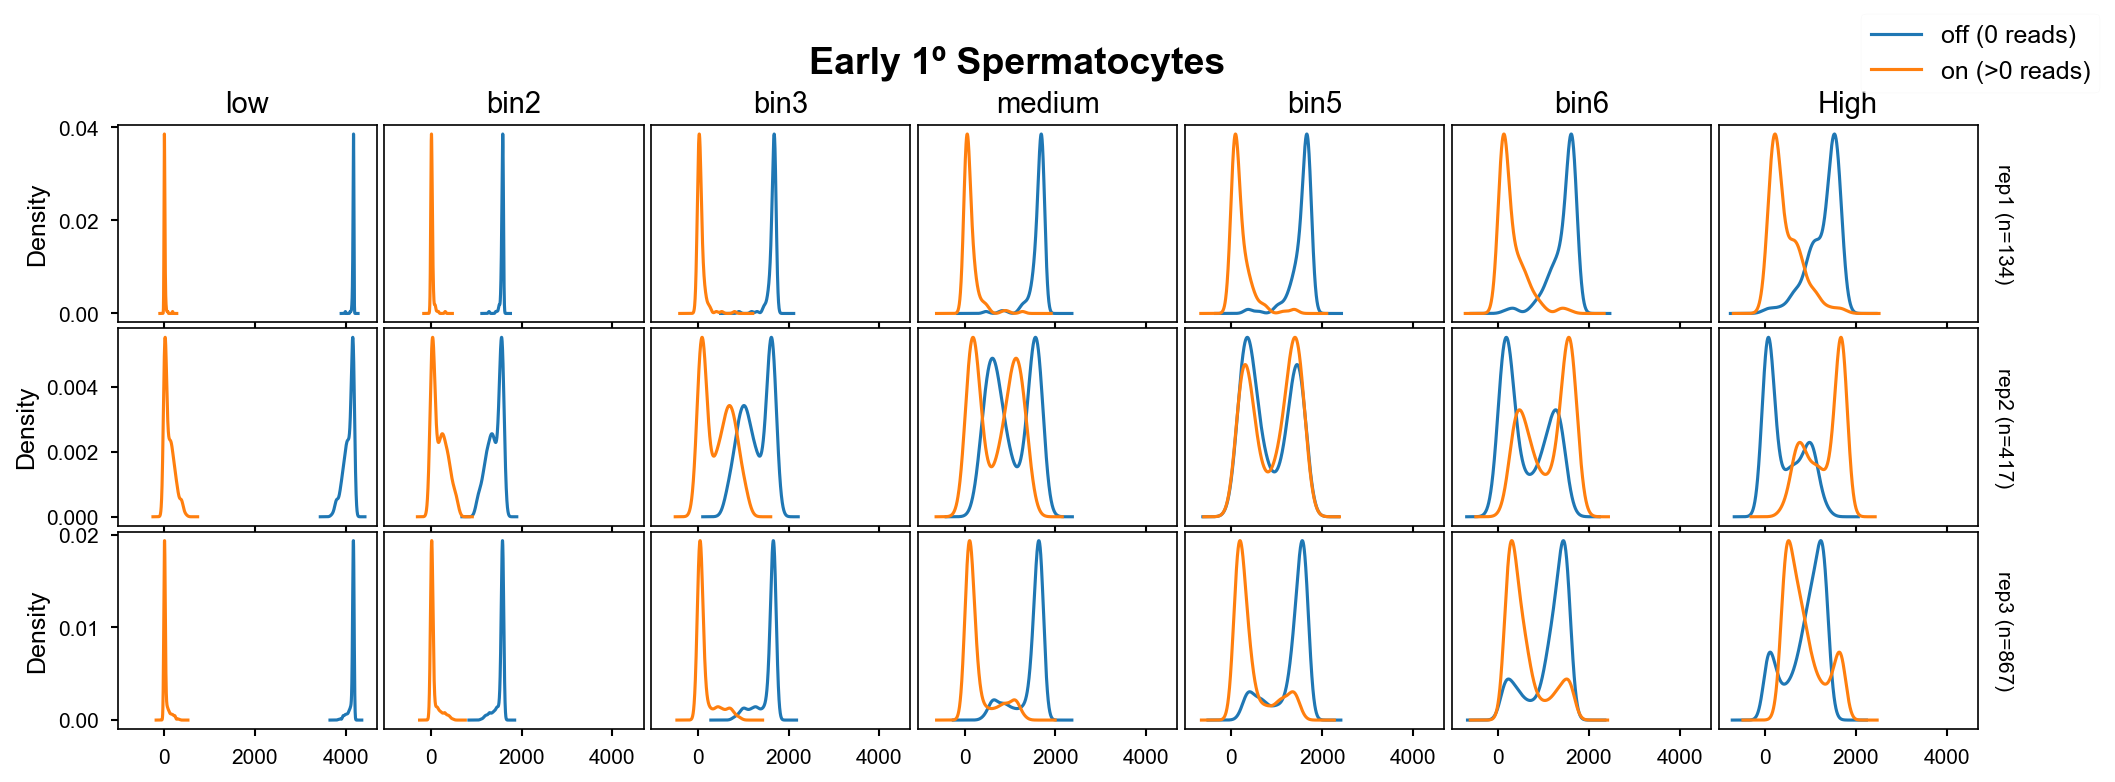

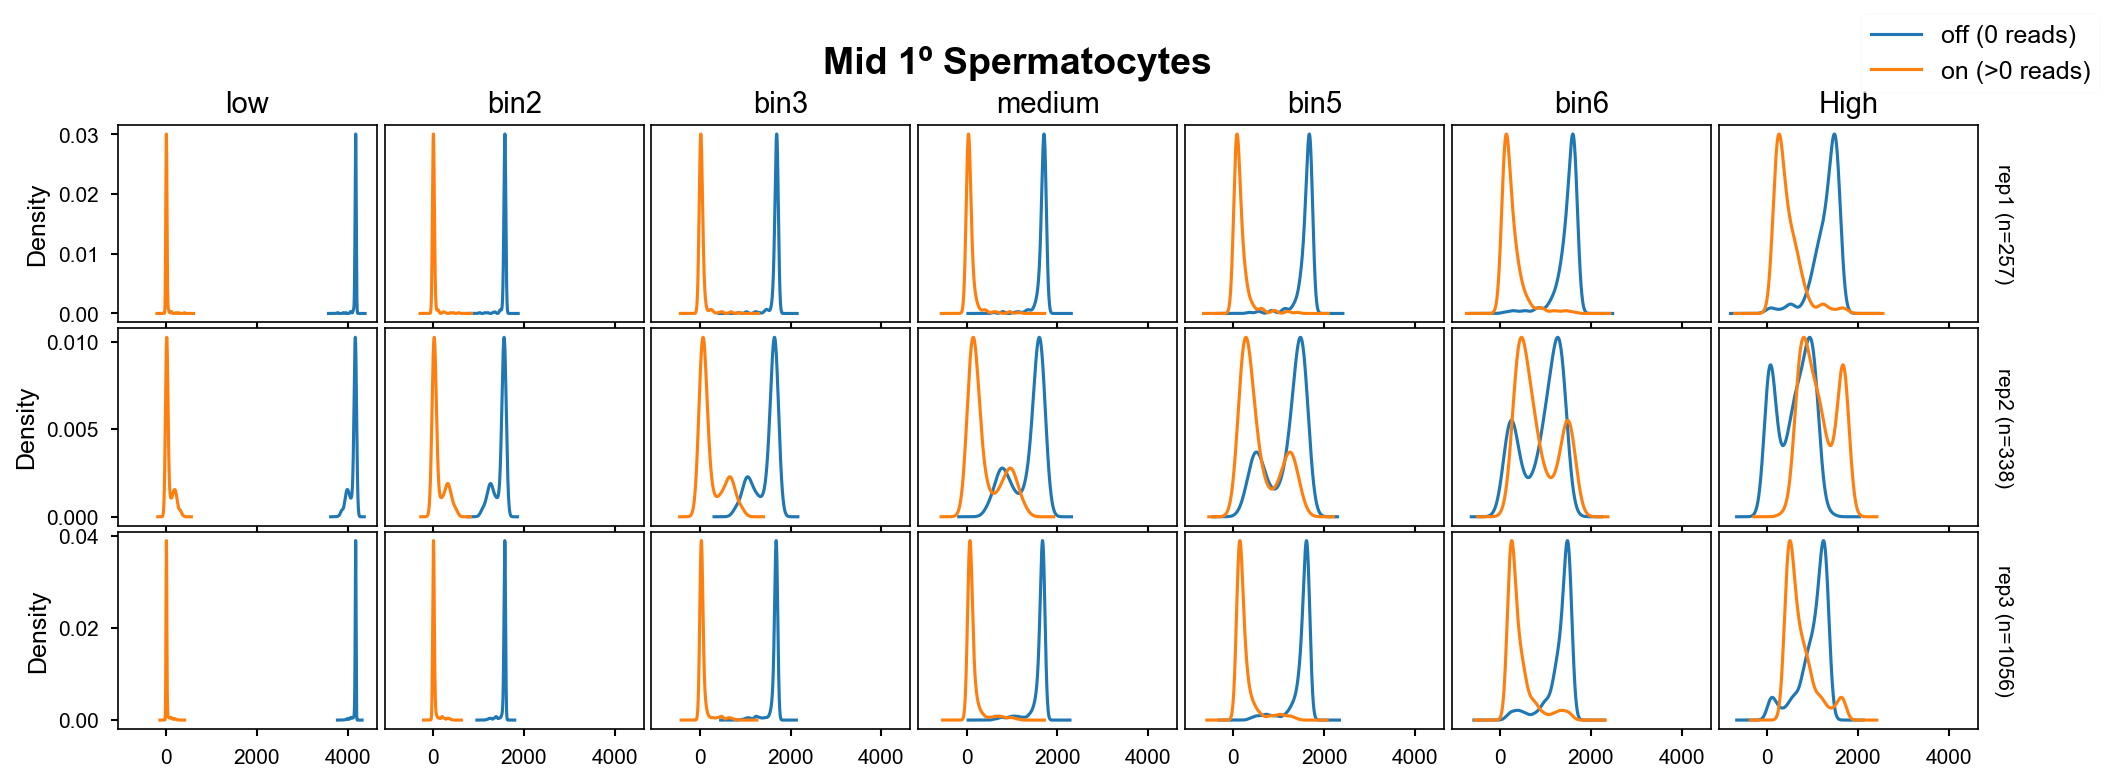

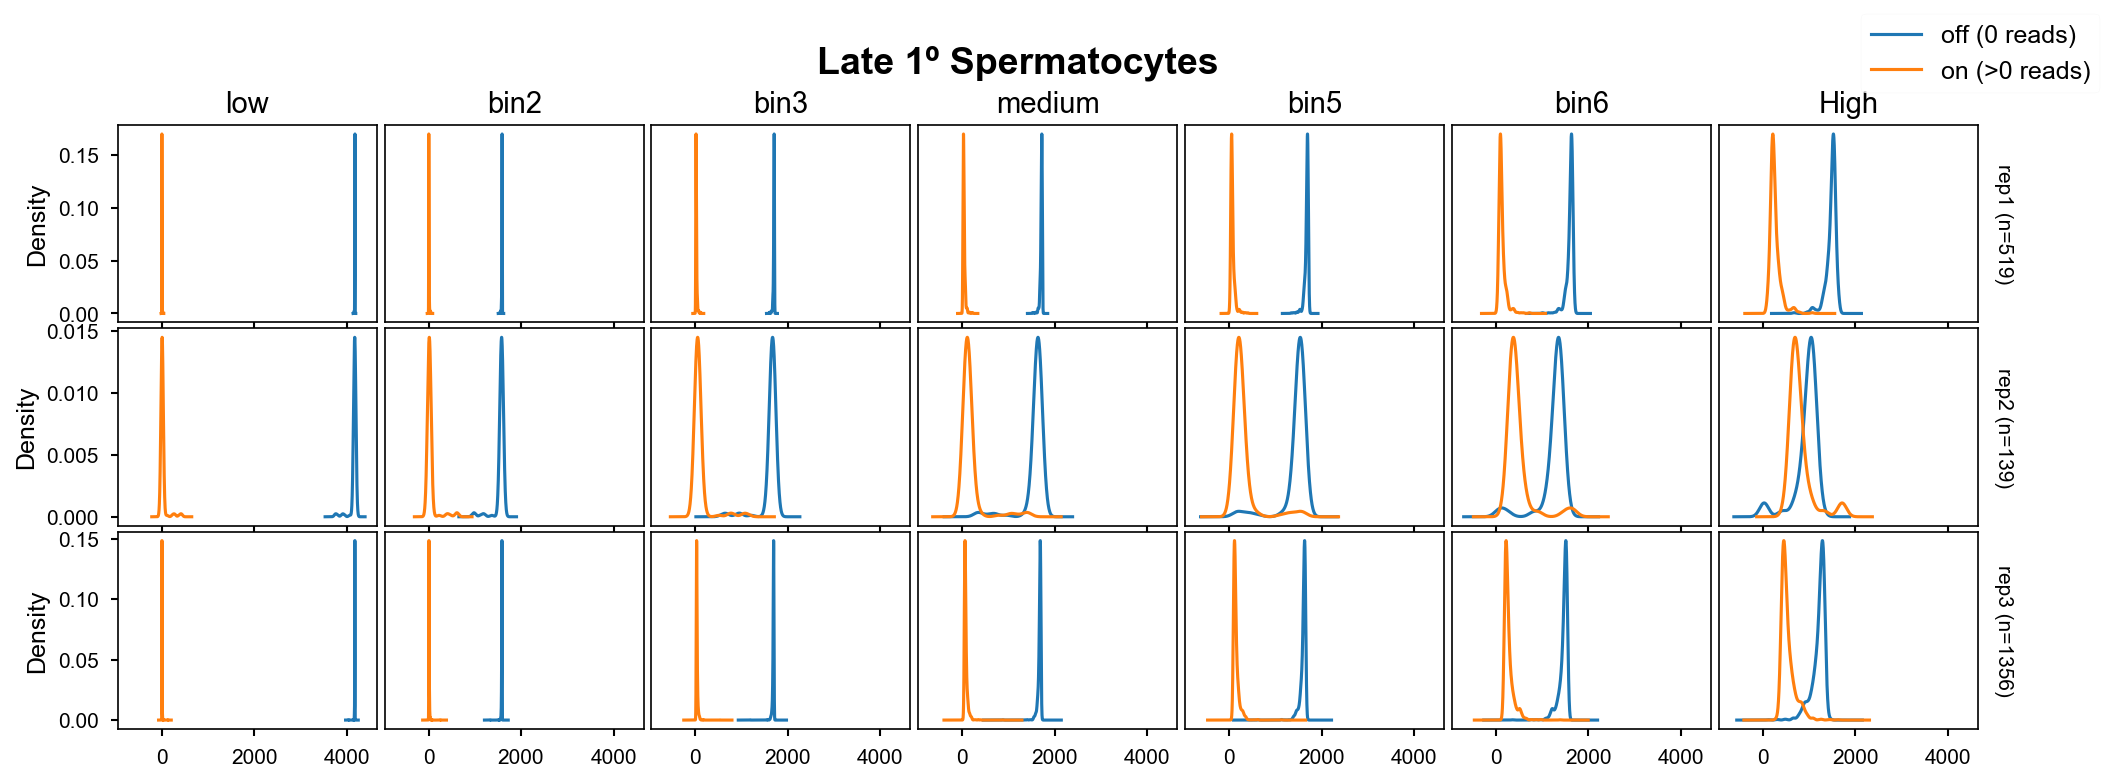

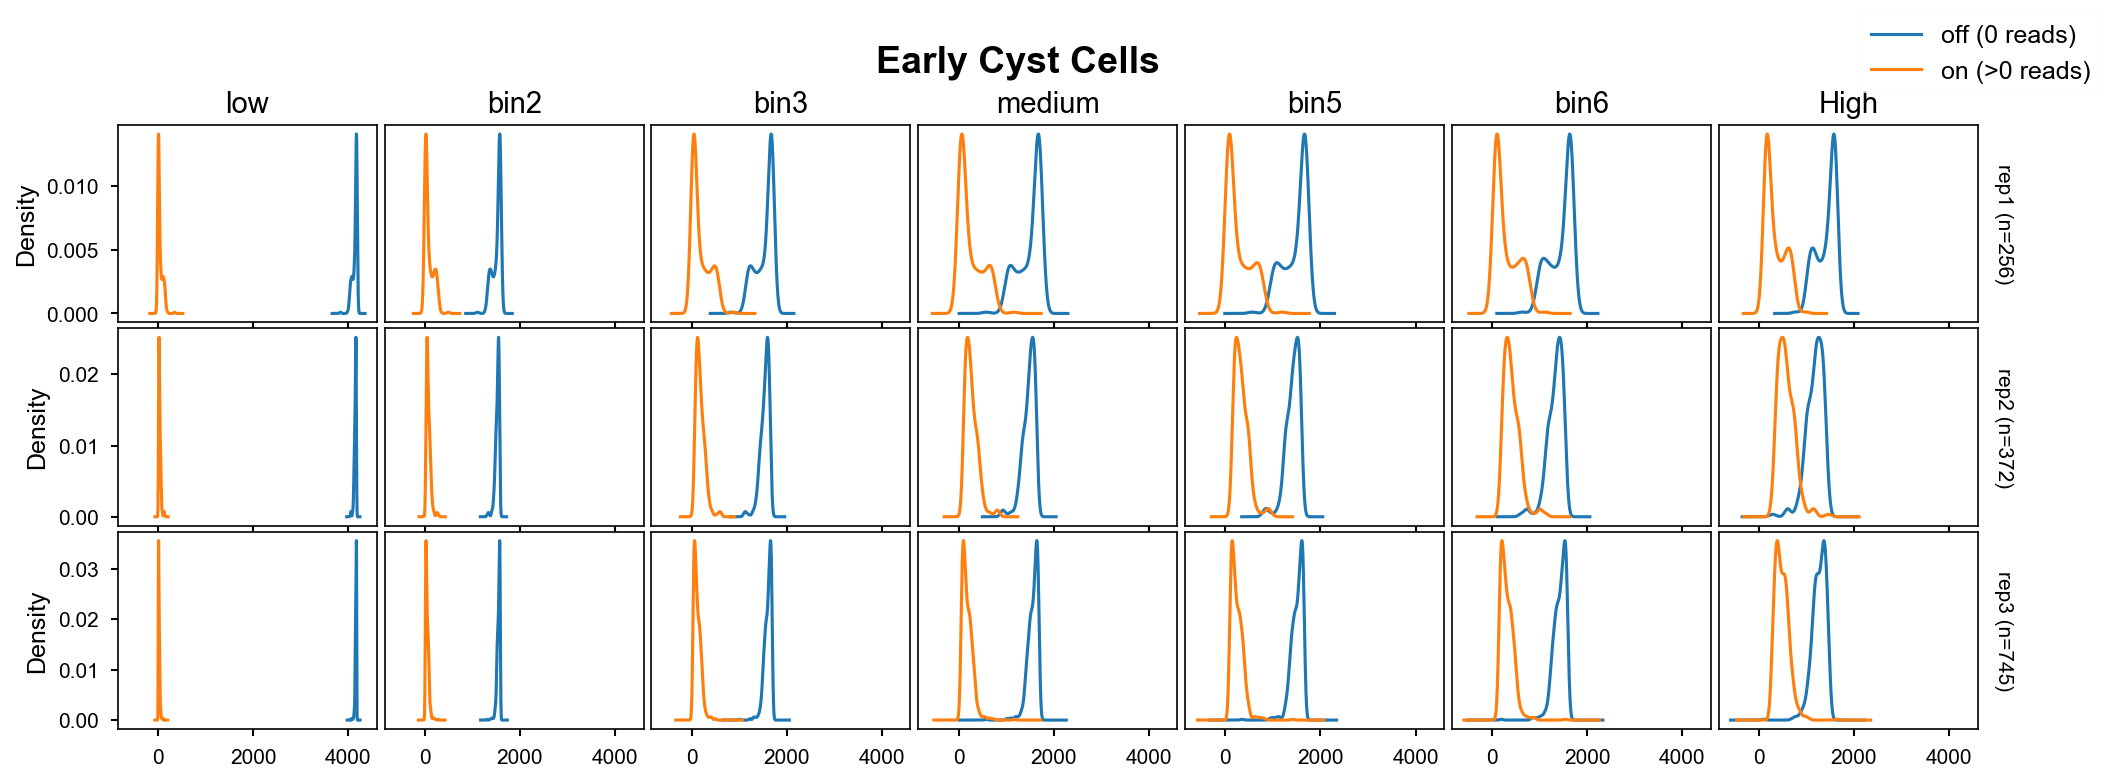

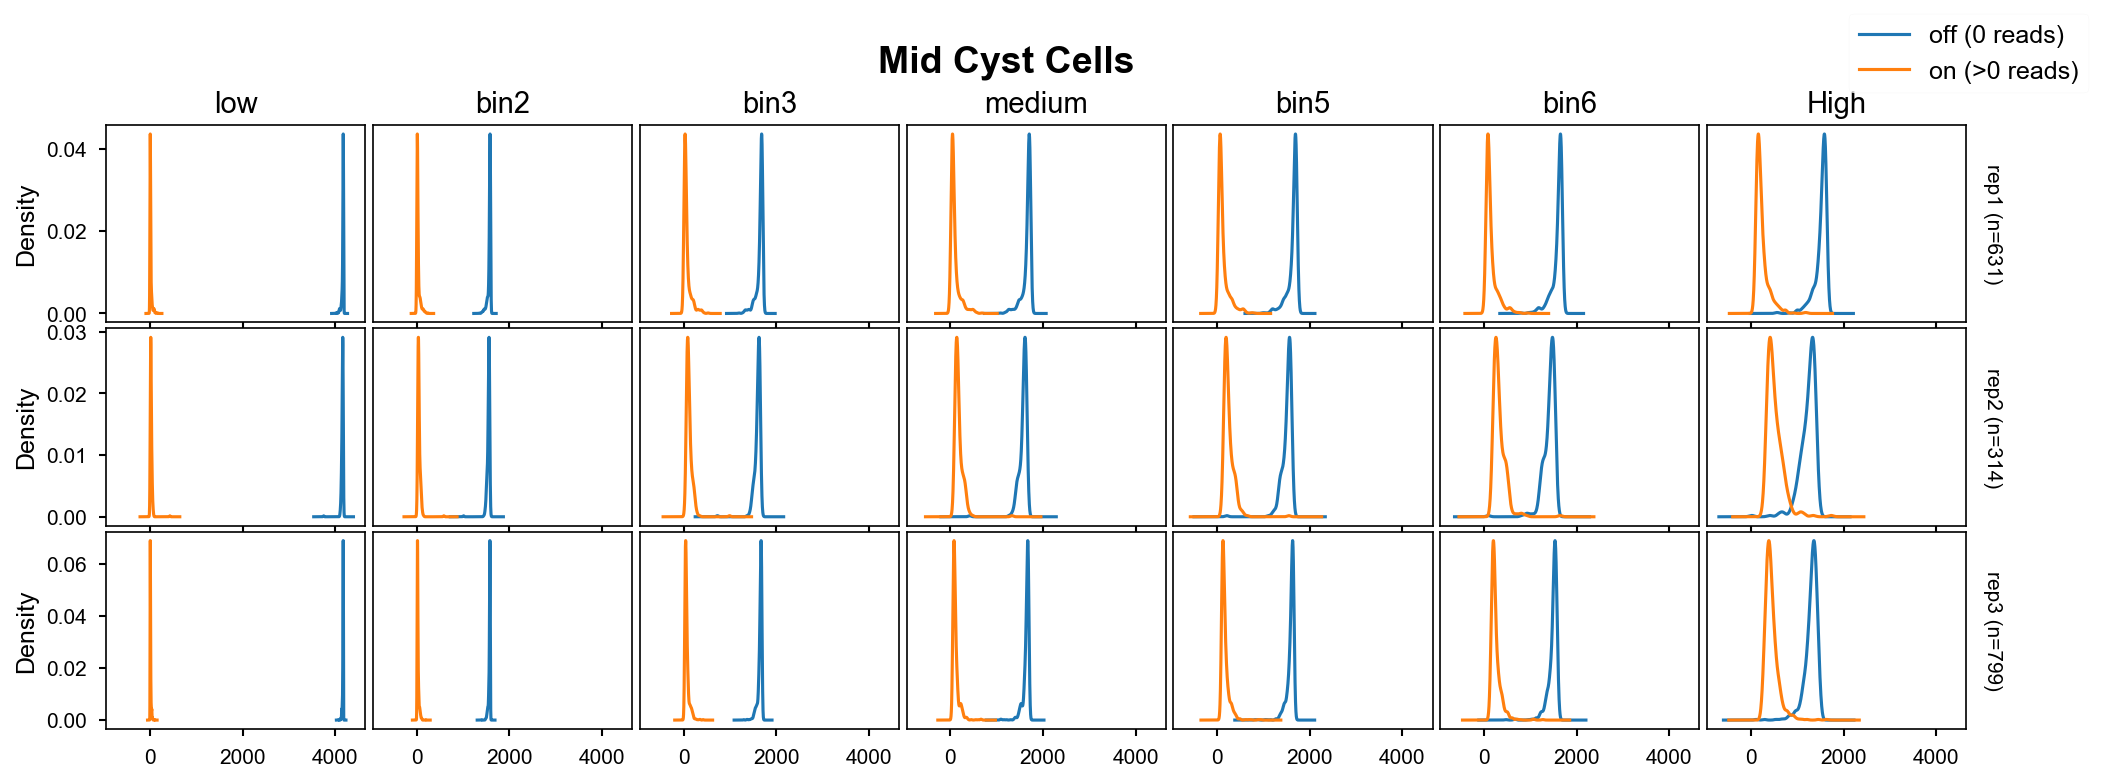

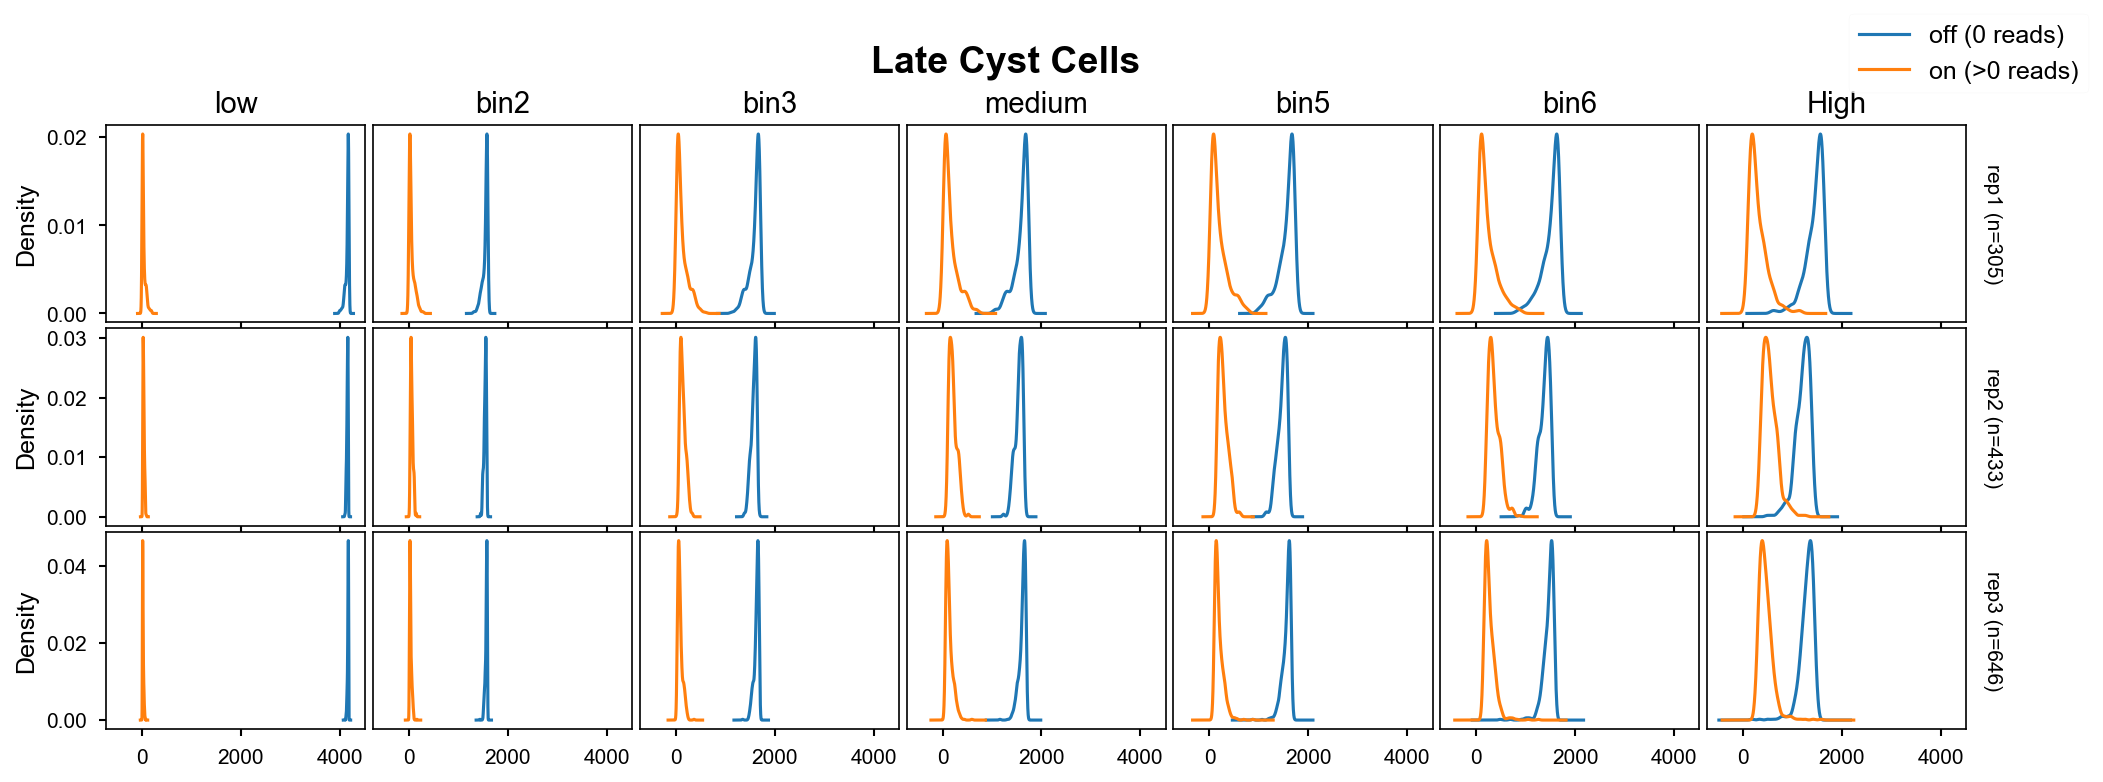

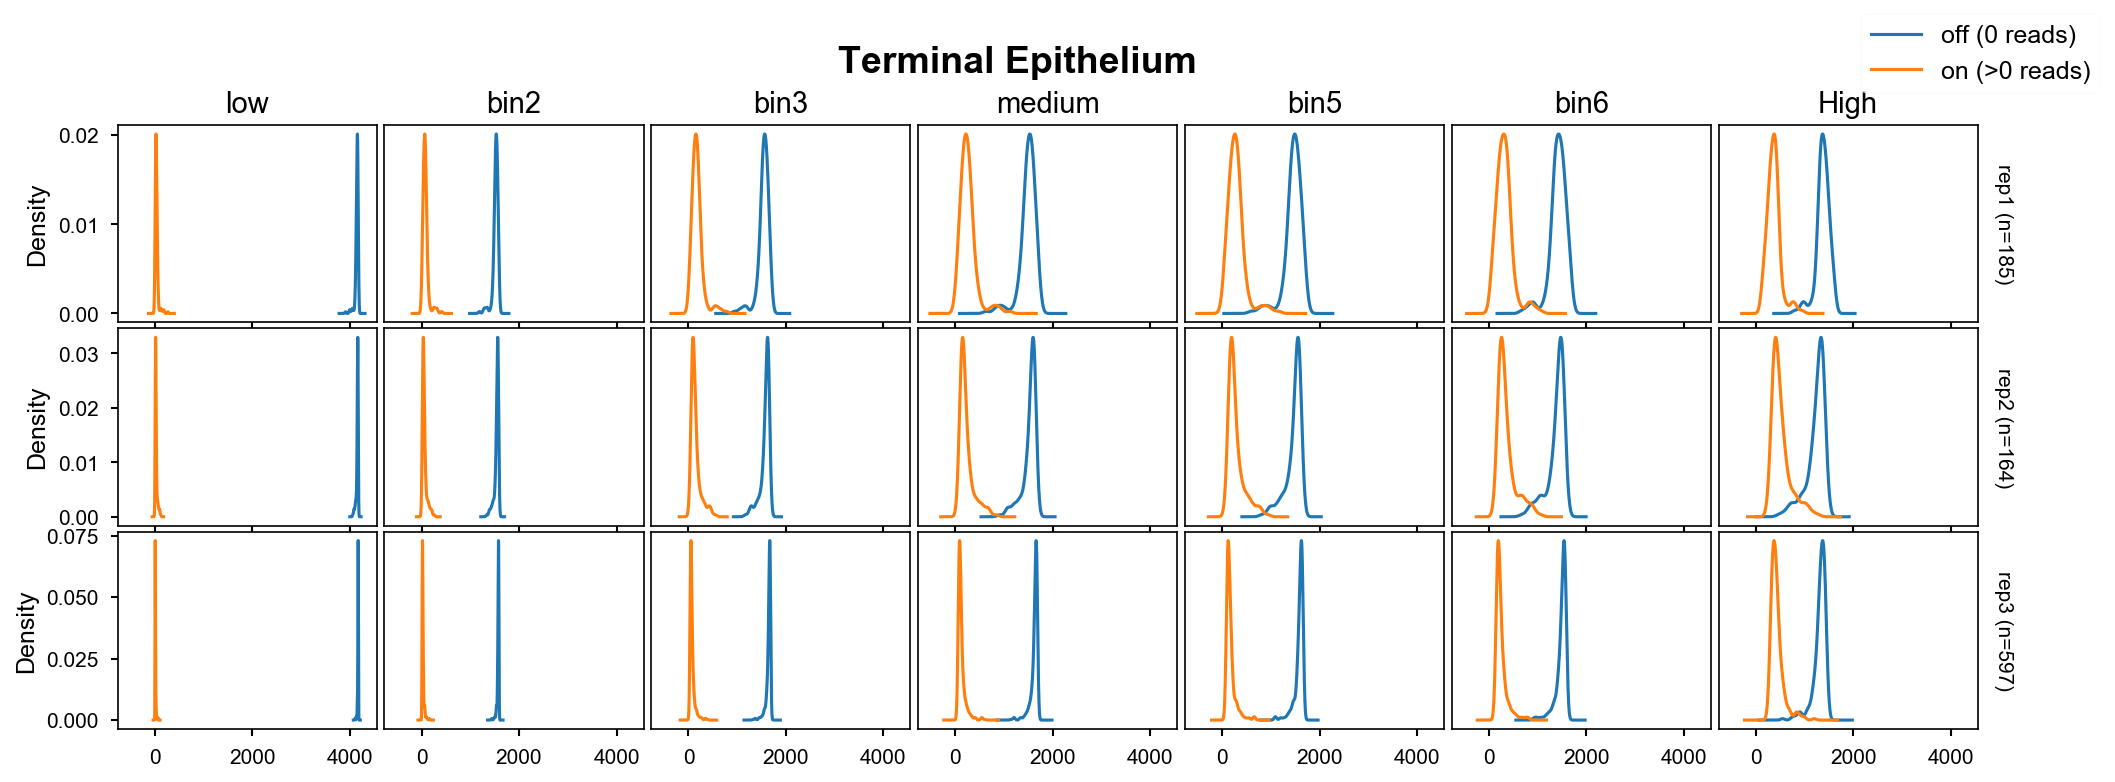

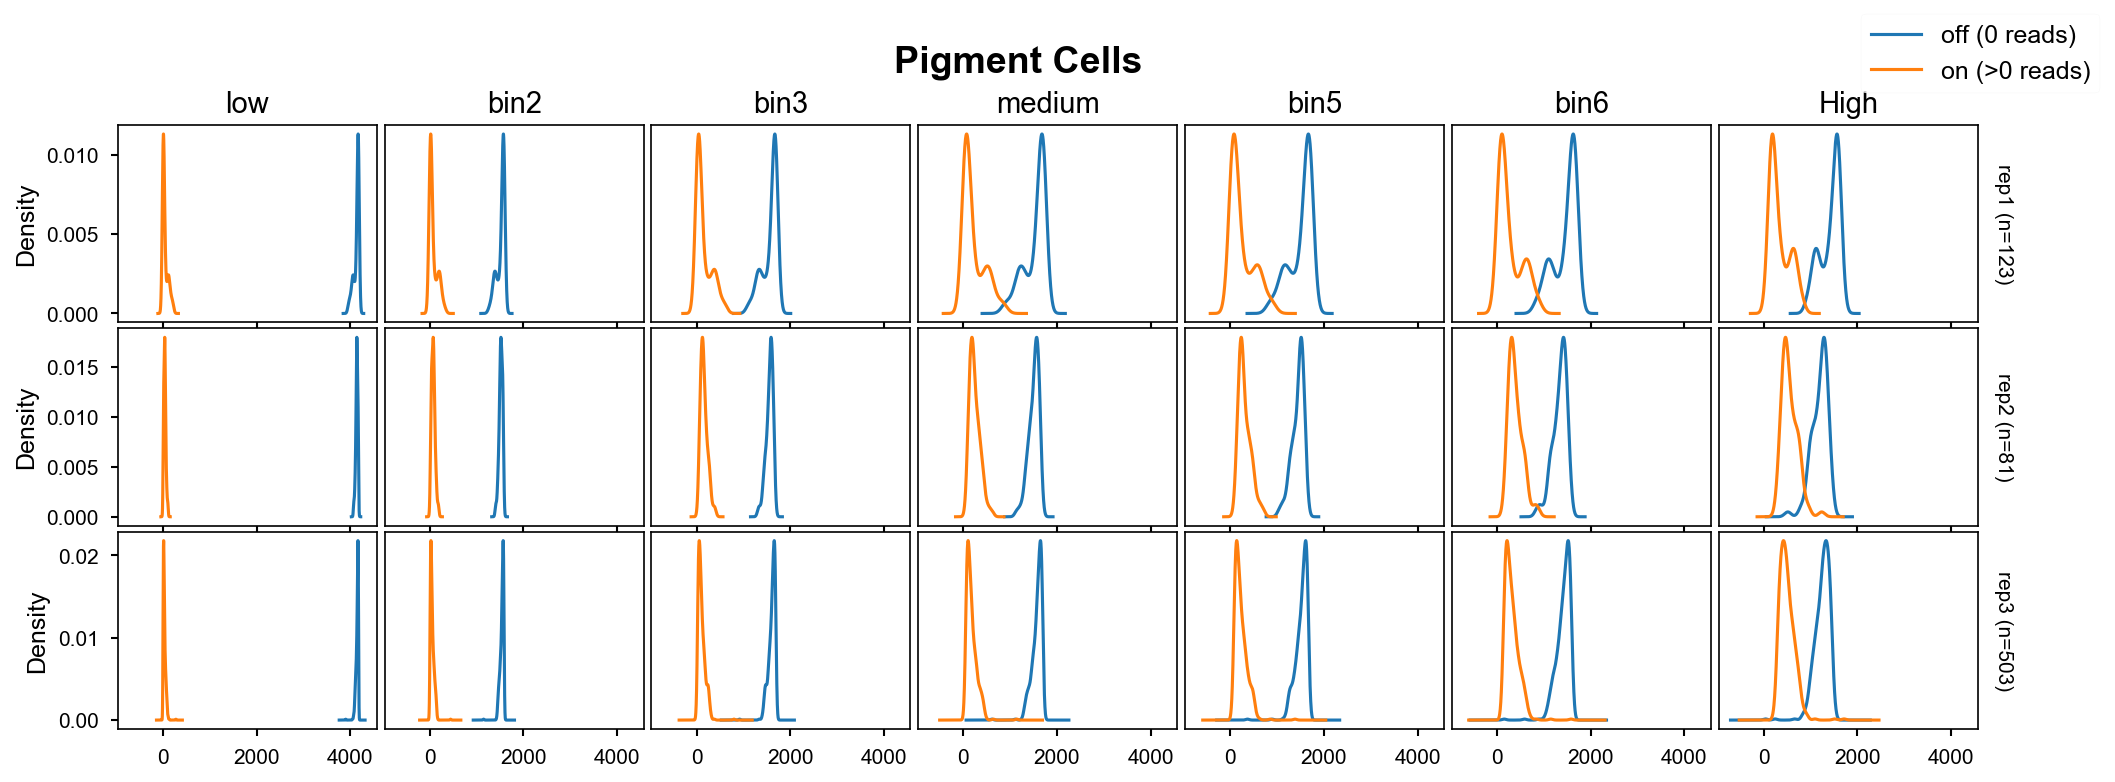

In [17]:
# Bin genes into deciles using expression from Bulk RNA-Seq trypsin digested testes
cols = ['C1_TDT', 'C3_TDT', 'C2_TDT', 'C4_TDT']
bulk = pd.read_parquet('../output/bulk-rnaseq-wf/aggregation/gene_level_counts.parquet', columns=cols)
bulk = bulk[~bulk.index.str.contains('ERCC')].copy()
bins = pd.qcut(bulk.median(axis=1), 10, 
               labels=['low', 'bin2', 'bin3', 'medium', 'bin5', 'bin6', 'High'],
               duplicates='drop').sort_values()


def cell_missing2(cluster, rep, axes, title=False):
    _dat = raw_w_meta.query(f'cluster == "{cluster}" & rep == "{rep}"').drop(['rep', 'cluster'], axis=1)
    num_cells = _dat.shape[0]
    
    results = {}
    for c in bins.cat.categories:
        _genes = bins[bins == c].index
        _subset = _dat.reindex(_genes, axis=1).dropna(axis=1)
        
        off = (_subset == 0).sum(axis=1)
        off.name = 'off (0 reads)'

        on = (_subset > 0).sum(axis=1)
        on.name = 'on (>0 reads)'
    
        results[c] = pd.concat([off, on], sort=True, axis=1)

    for ax, (c, dd) in zip(axes, results.items()):
        dd.plot.kde(ax=ax, legend=False)
        if title:
            ax.set_title(c)

    axes[-1].text(1.1, 0.5, f'{rep} (n={num_cells})', transform=ax.transAxes, 
                  rotation=-90, ha='center', va='center', fontsize=10)


def _plot(cluster):
    fig, axes = plt.subplots(3, 7, sharex=True, figsize=plt.figaspect(1/3), gridspec_kw=dict(wspace=0.03, hspace=0.03))
    cell_missing2(cluster, 'rep1', axes[0, :], title=True)
    cell_missing2(cluster, 'rep2', axes[1, :])
    cell_missing2(cluster, 'rep3', axes[2, :])

    for ax in axes[:, 1:].flatten():
        ax.yaxis.set_visible(False)

    fig.suptitle(cluster);
    axes[0, -1].legend(loc='lower left', bbox_to_anchor=[.5, 1.1]);
    
    
for cluster in nbconfig.sel_cluster_order:
    _plot(cluster)

## Log Standard Deviation Across Replicates

There are a few ways to look at gene level standard deviations. Here I summed all of the cells and looked at the standard deviation across replicates.

Text(0.5,0,'Log Replicate Standard Devation')

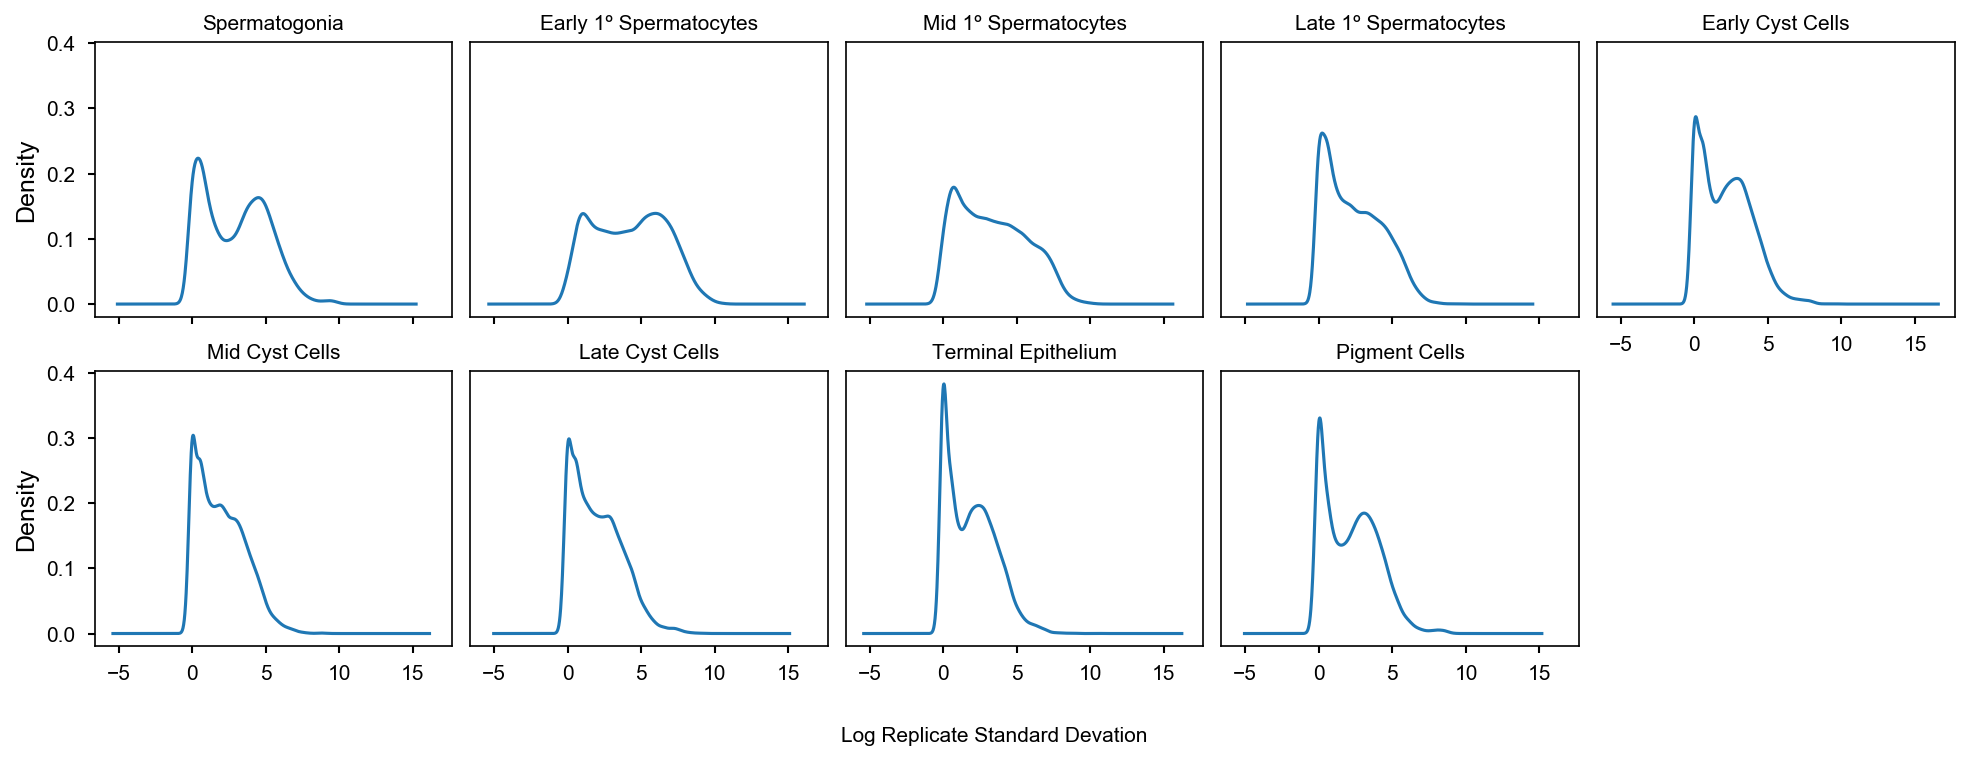

In [98]:
def _plot(cluster, ax):
    _dat = raw_w_meta.query(f'cluster == "{cluster}"').drop(['cluster'], axis=1).groupby('rep').sum().T
    np.log1p(_dat.std(axis=1)).plot.kde(ax=ax, legend=False)
    ax.set_title(cluster, fontsize=10)

fig, axes = plt.subplots(2, 5, figsize=plt.figaspect(1/3), sharex=True, sharey=True, gridspec_kw=dict(wspace=0.05))
for ax, cluster in zip(axes.flatten(), nbconfig.sel_cluster_order):
    _plot(cluster, ax)
    
# remove empty plot
axes[-1, -1].axes.set_visible(False)

# remove yticks from inner plots
for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
axes[0, -1].xaxis.set_tick_params(labelbottom=True)
fig.text(0.5, 0, 'Log Replicate Standard Devation', ha='center', va='bottom', fontsize=10)

### Log STD across cells within replicates and cluster

Text(0.5,0,'Log Cell Standard Devation')

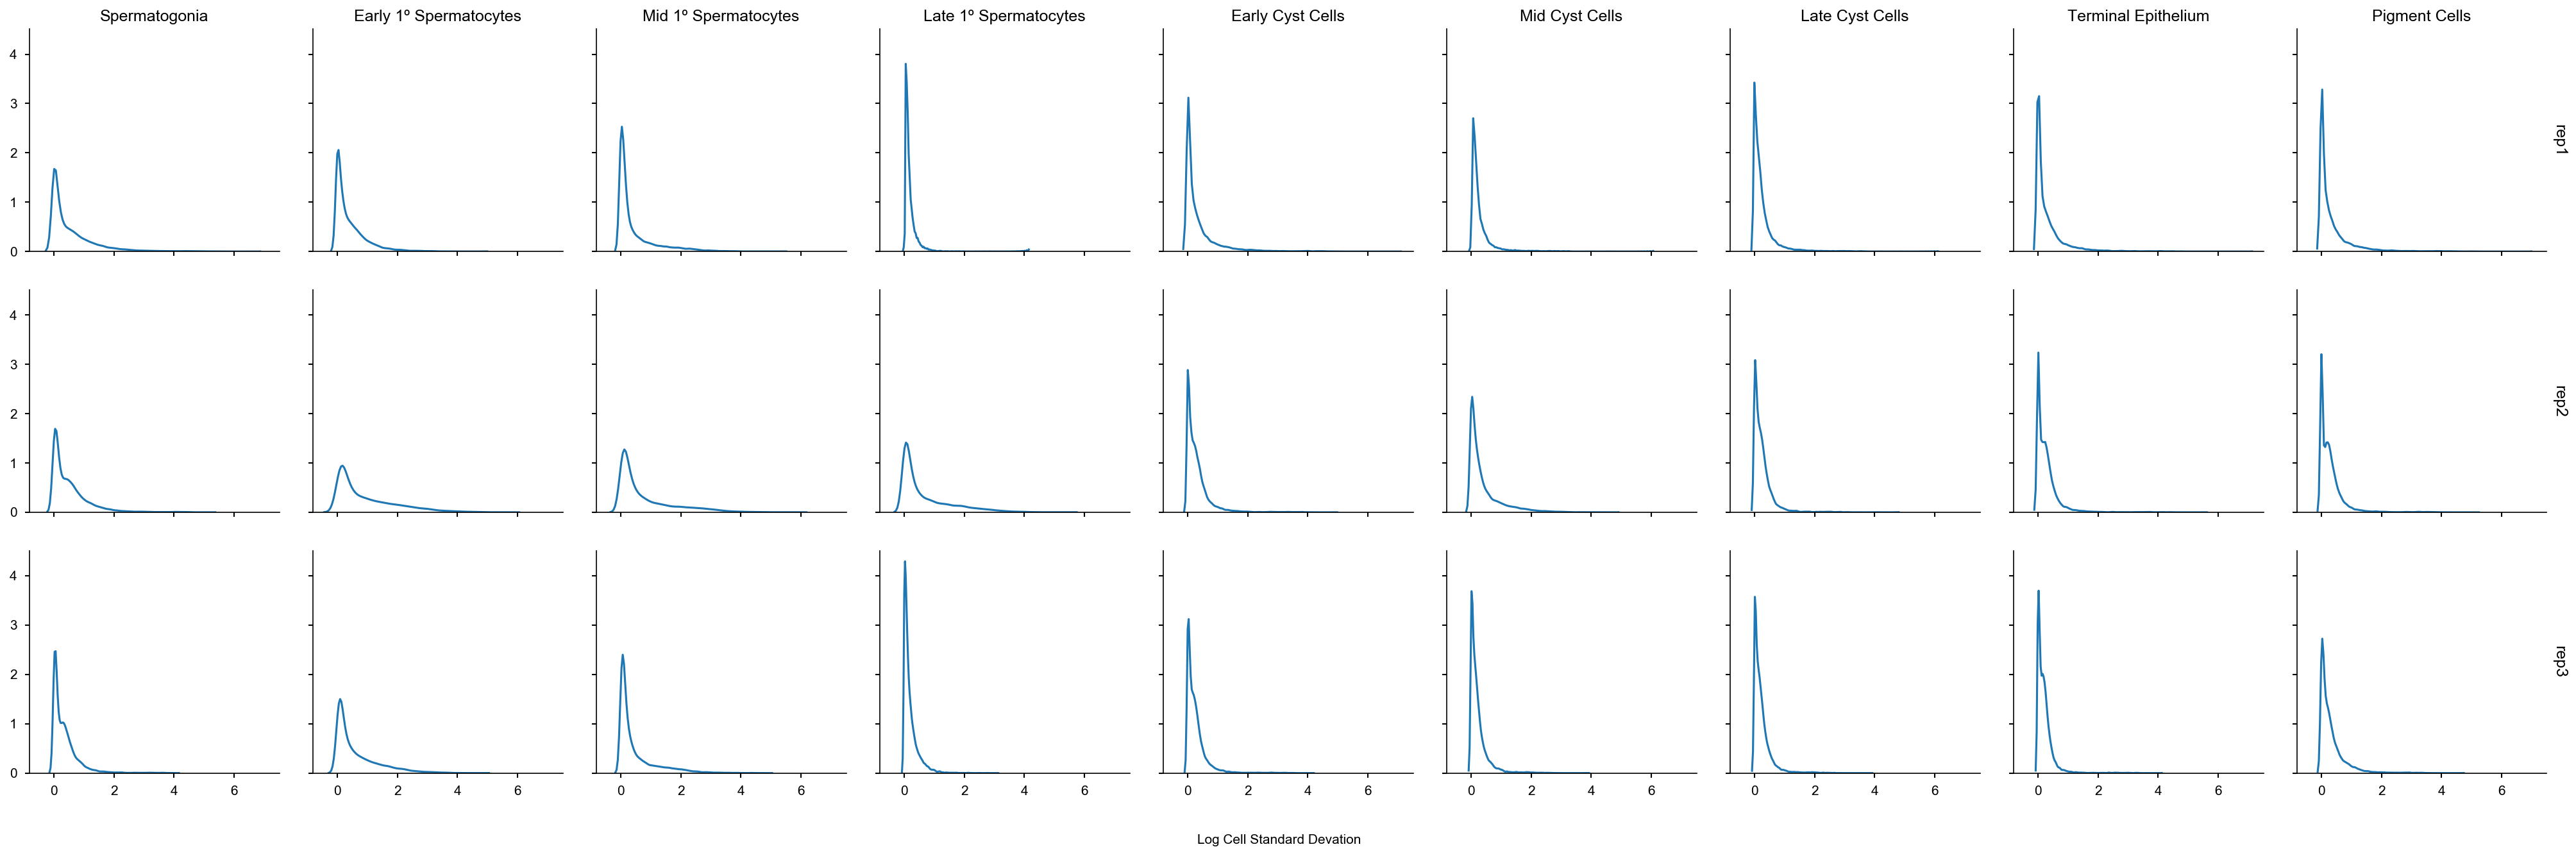

In [100]:
_dat = raw_w_meta.groupby(['rep', 'cluster']).std().reset_index().melt(id_vars=['cluster', 'rep'], value_name='std', var_name='FBgn')
_dat['std_log'] = np.log1p(_dat['std'])

g = sns.FacetGrid(_dat, row='rep', col='cluster', margin_titles=True)
g.map(sns.kdeplot, 'std_log')
[plt.setp(ax.texts, text="") for ax in g.axes.flat] # hack for margin title bug
g.set_titles(col_template='{col_name}', row_template='{row_name}');
g.set_xlabels('')
g.fig.text(0.5, 0, 'Log Cell Standard Devation', ha='center', va='bottom', fontsize=10)

## Maria and Hedi's Plots

I had sent Maria and her husband (Hedibert) some data and they generated the following plots. These plots look at the relationship between expression level and the number of zeros by gene and by cell. High expressed gens in a cluster have fewer zeros, but high expressed cells still have around 50% of genes at 0.

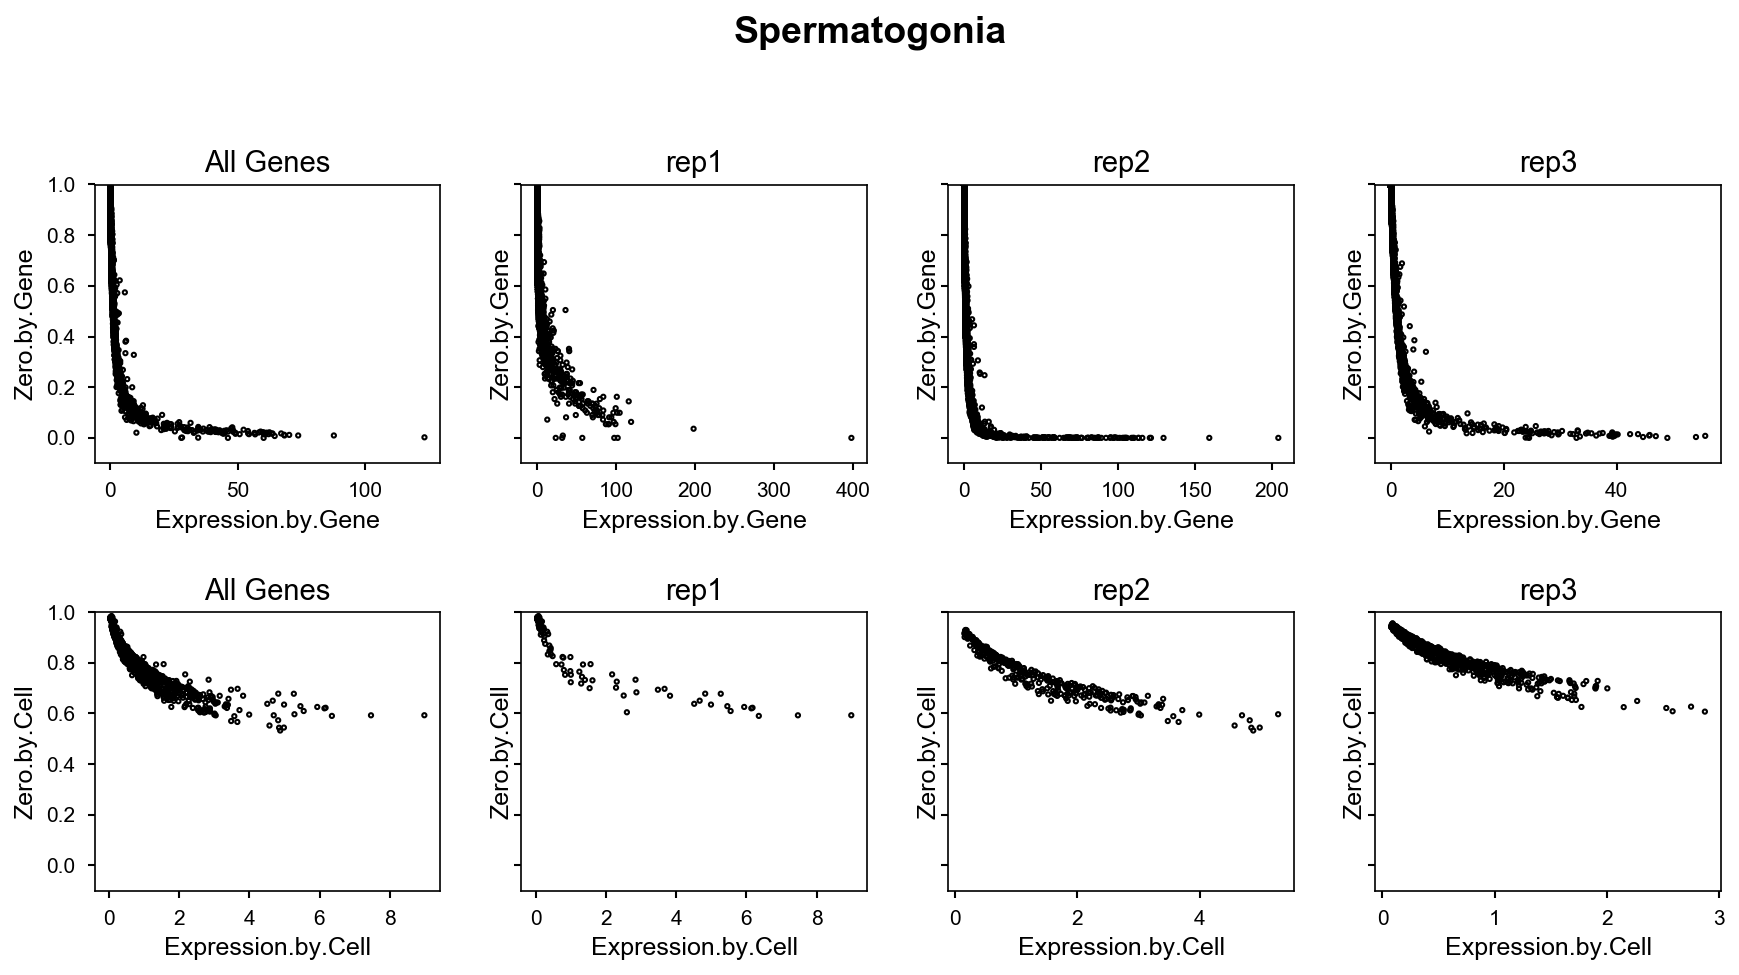

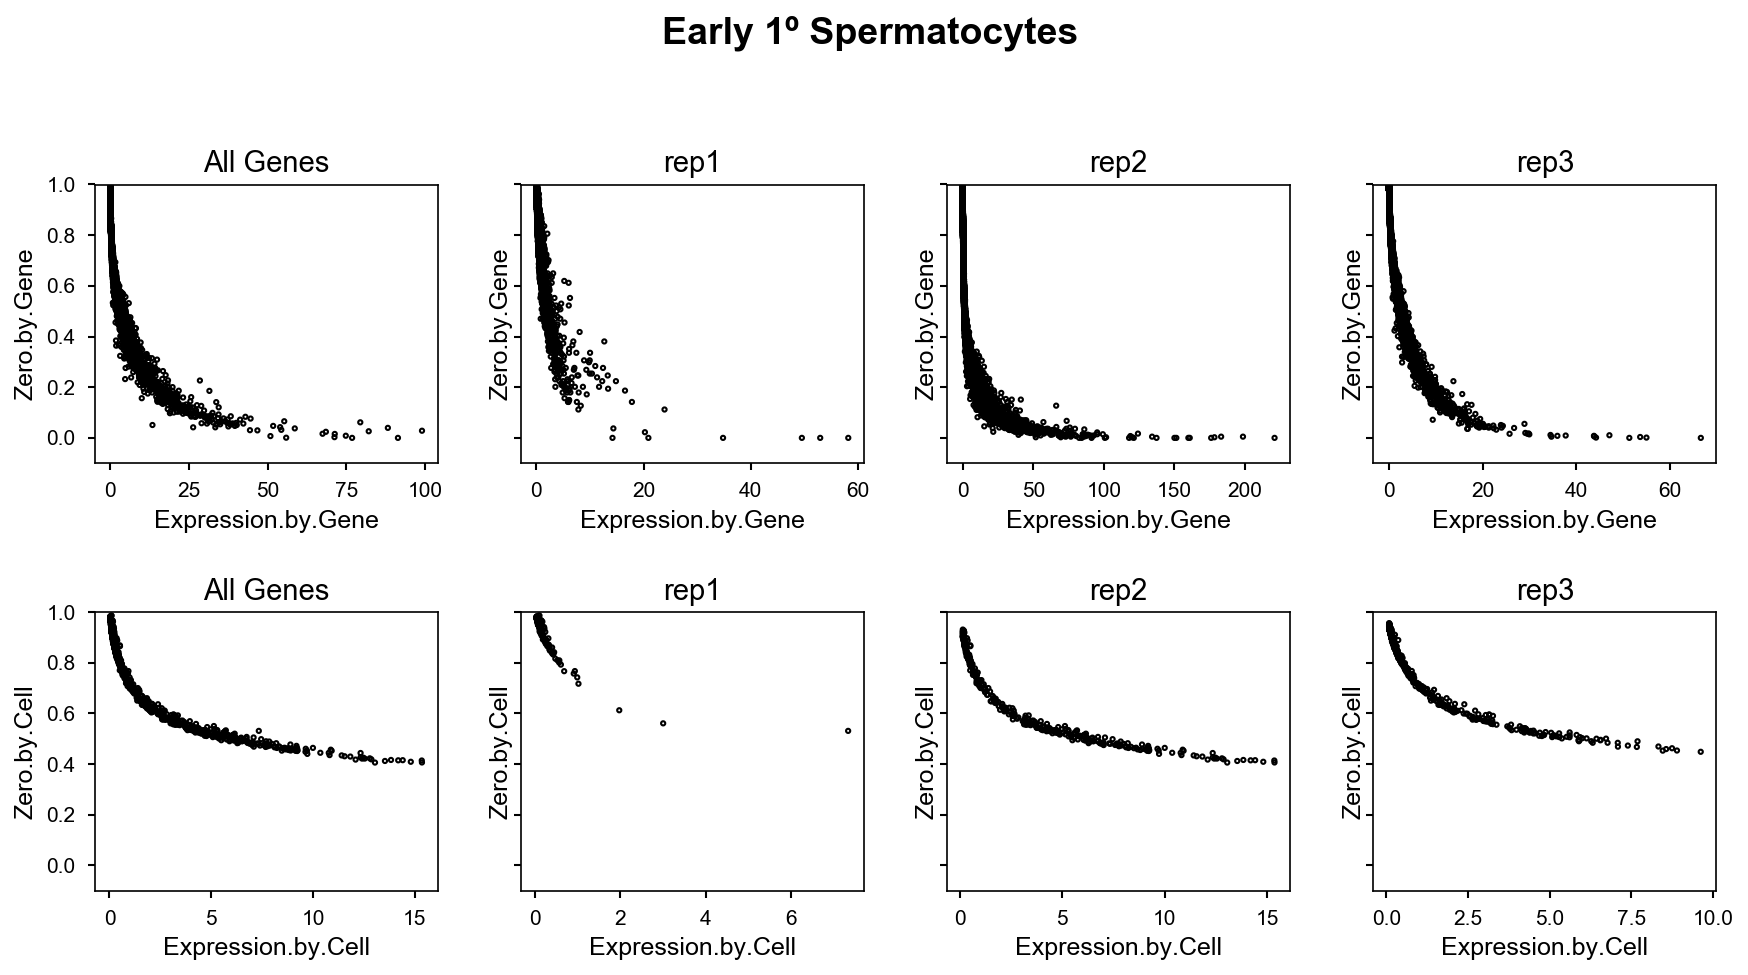

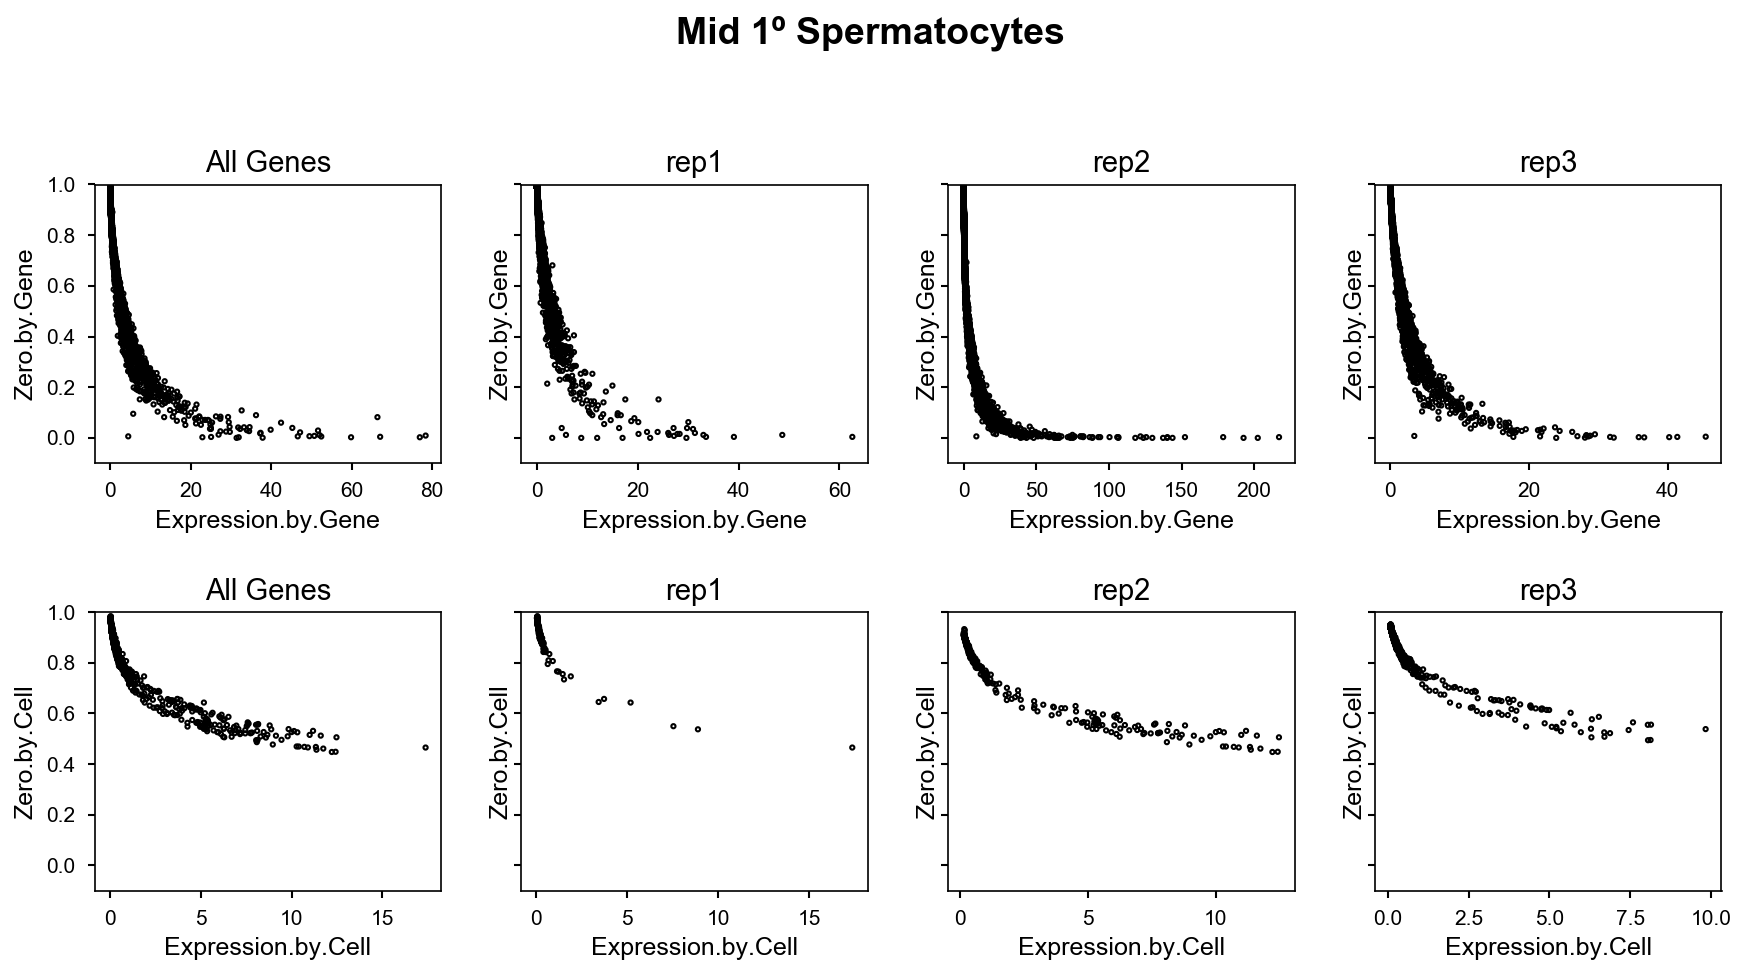

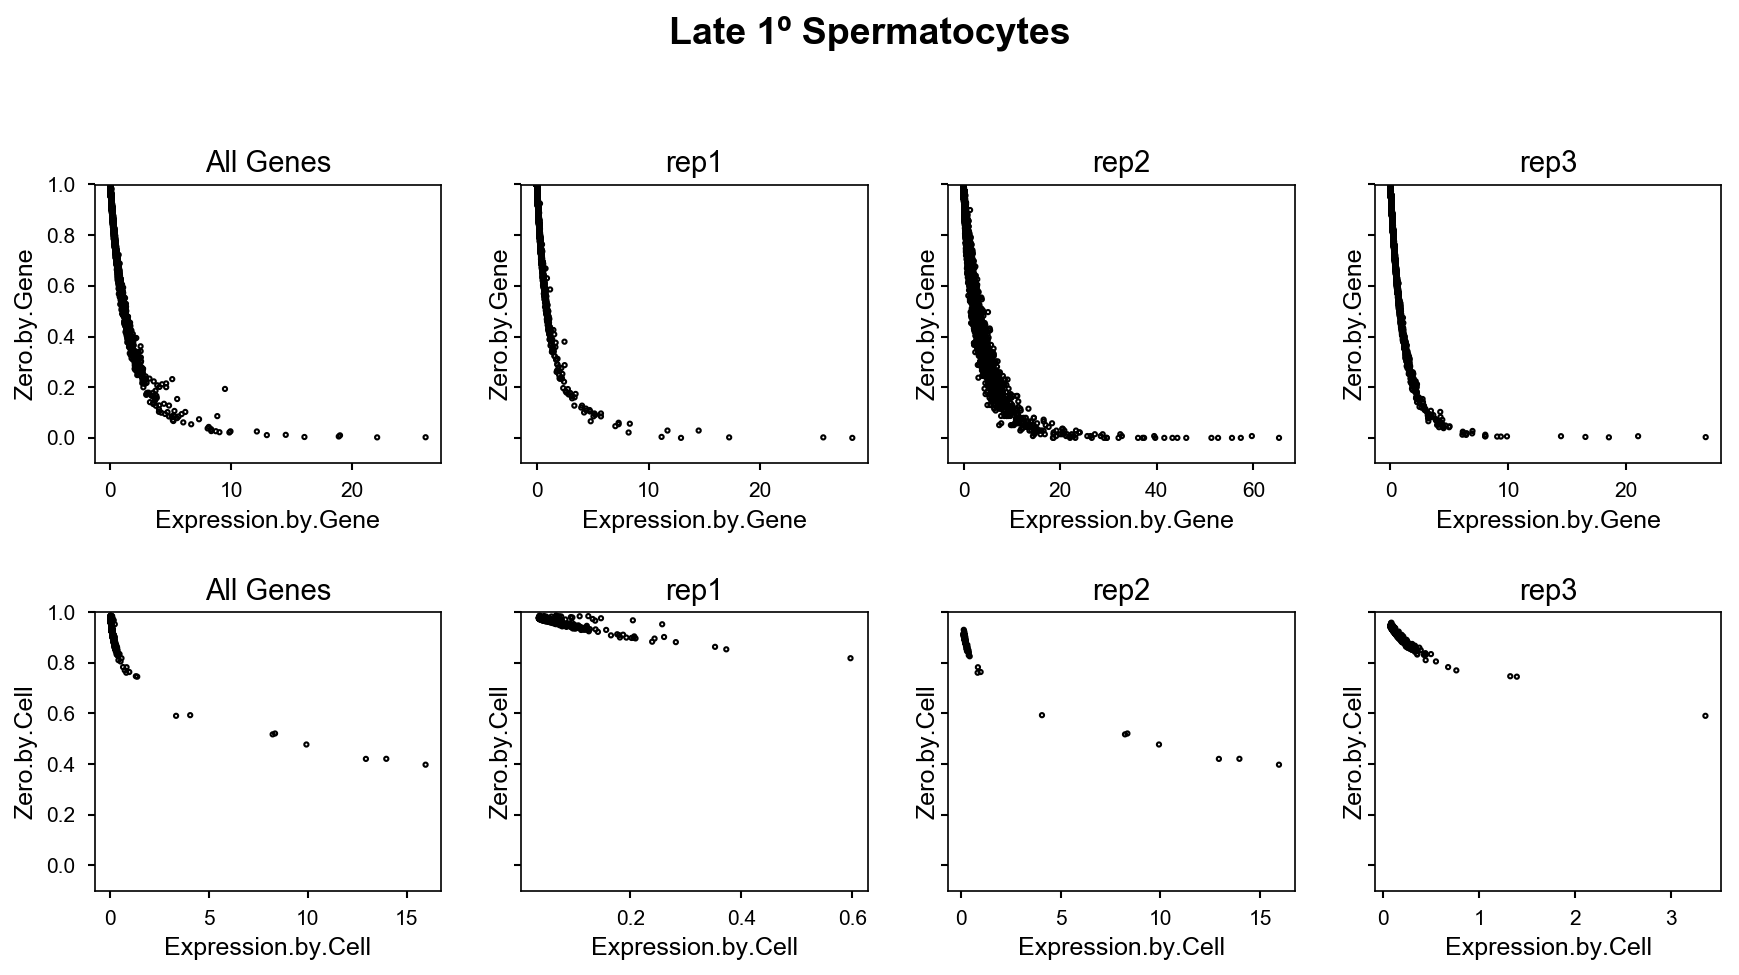

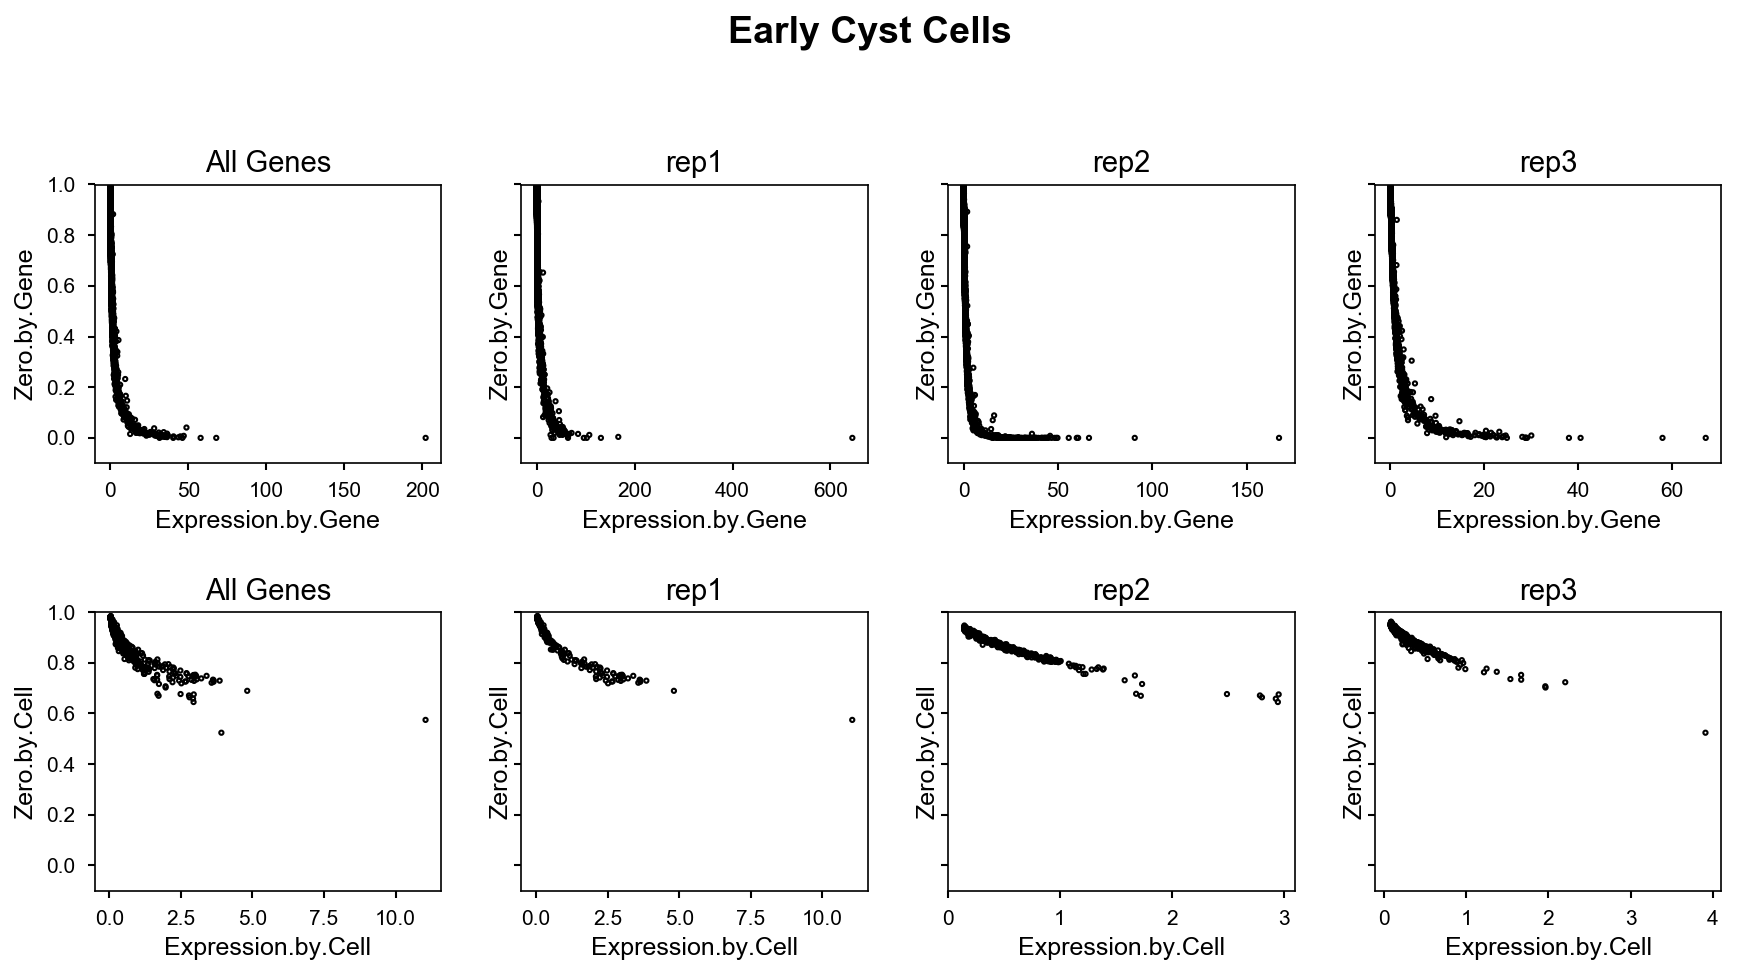

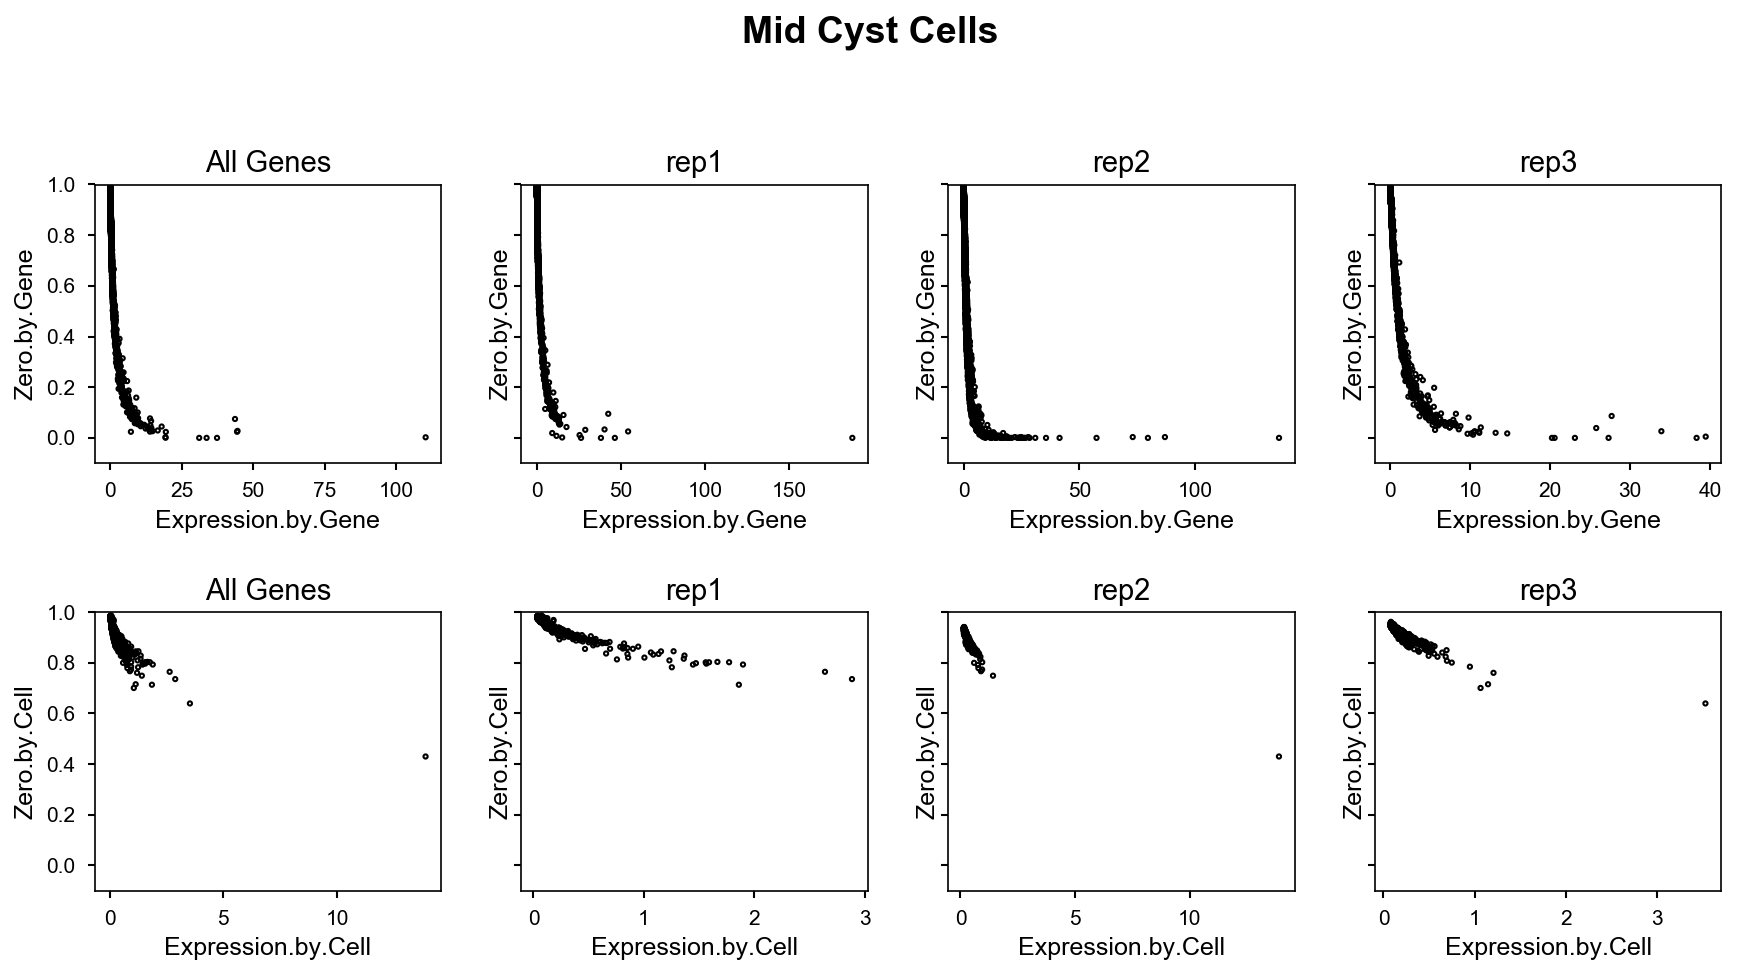

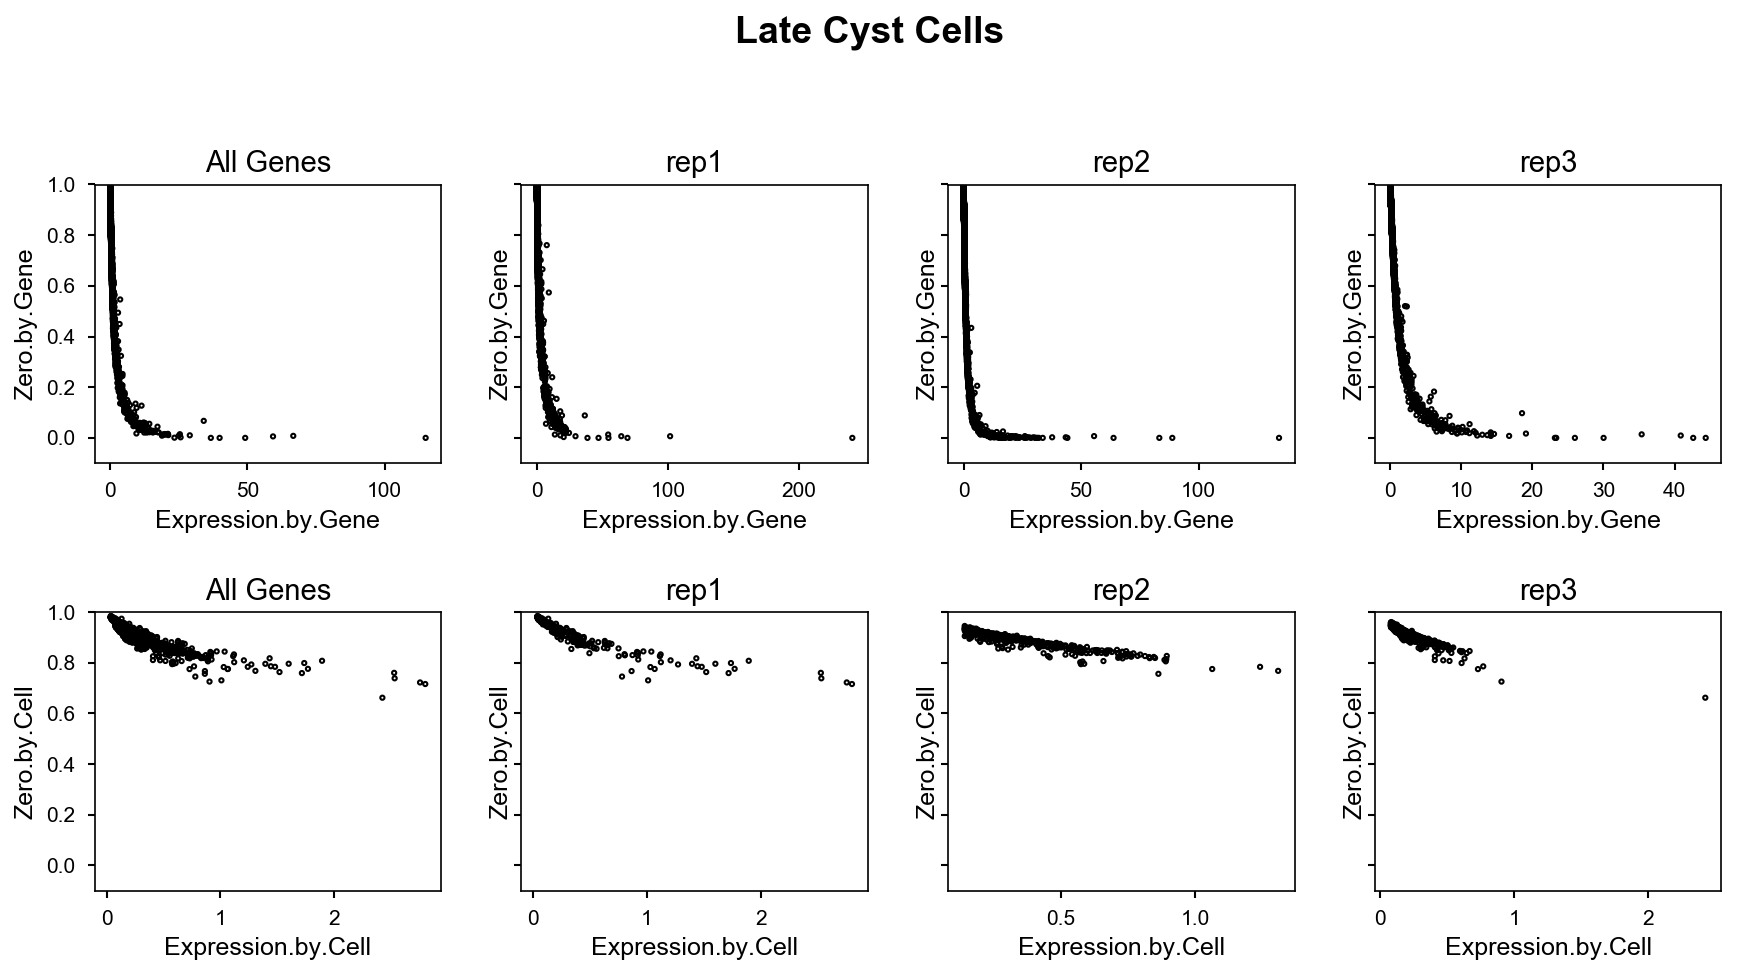

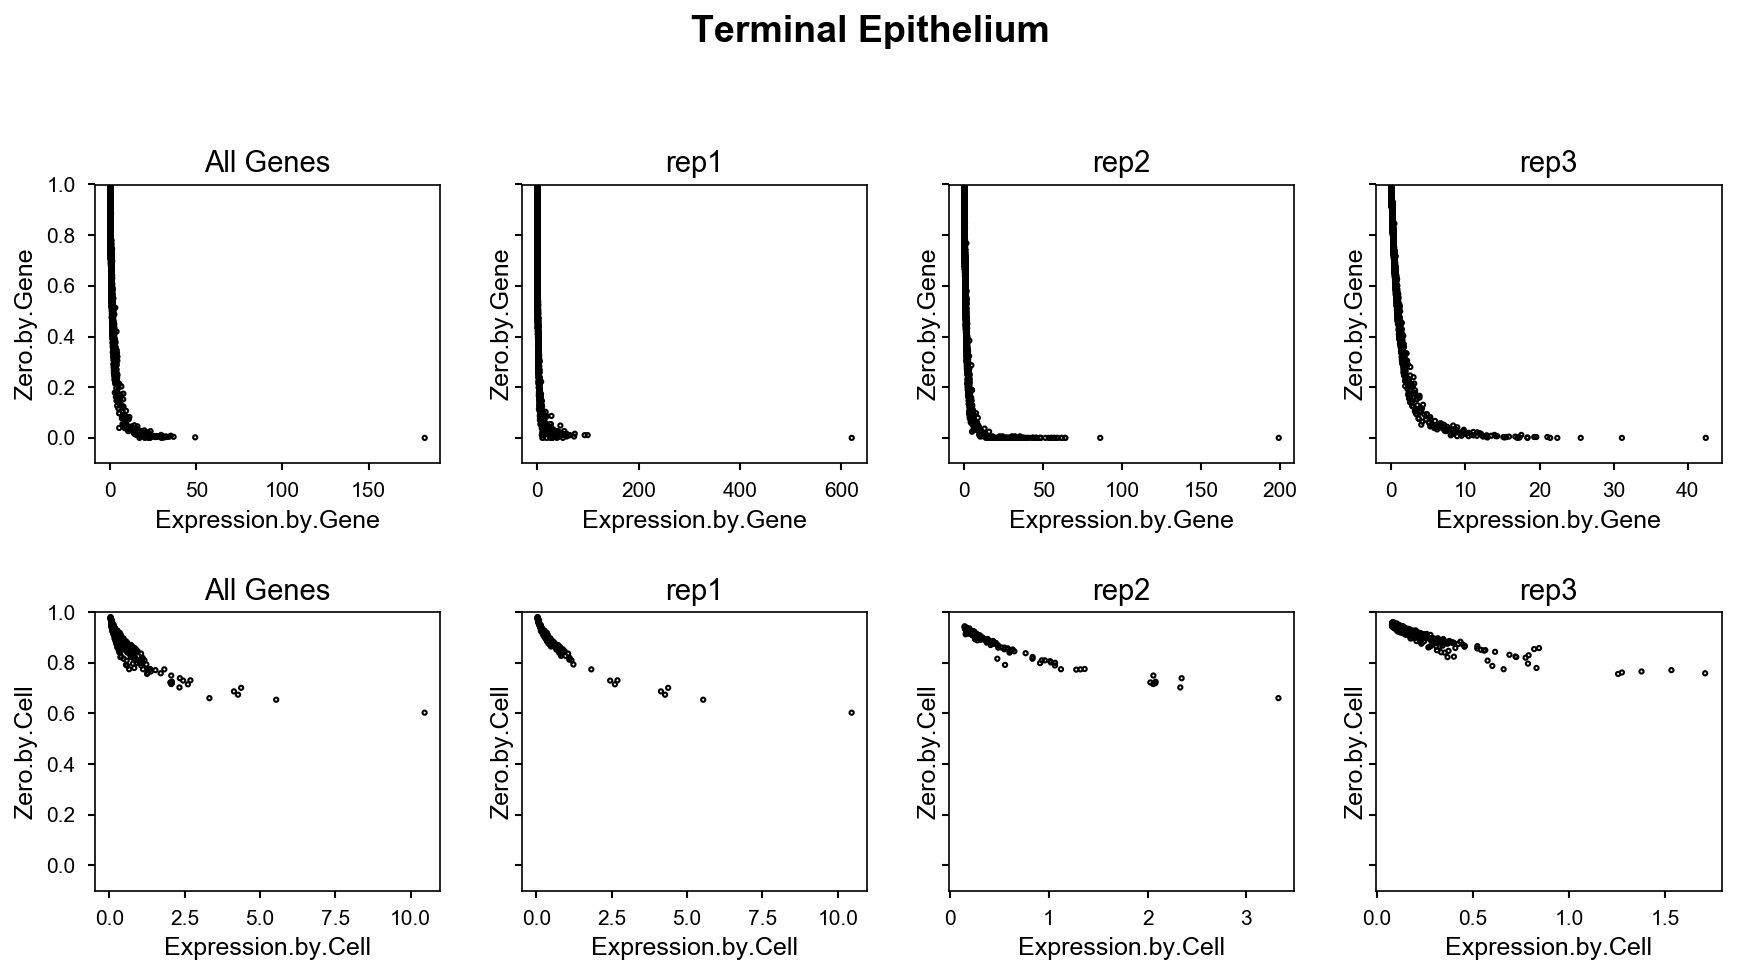

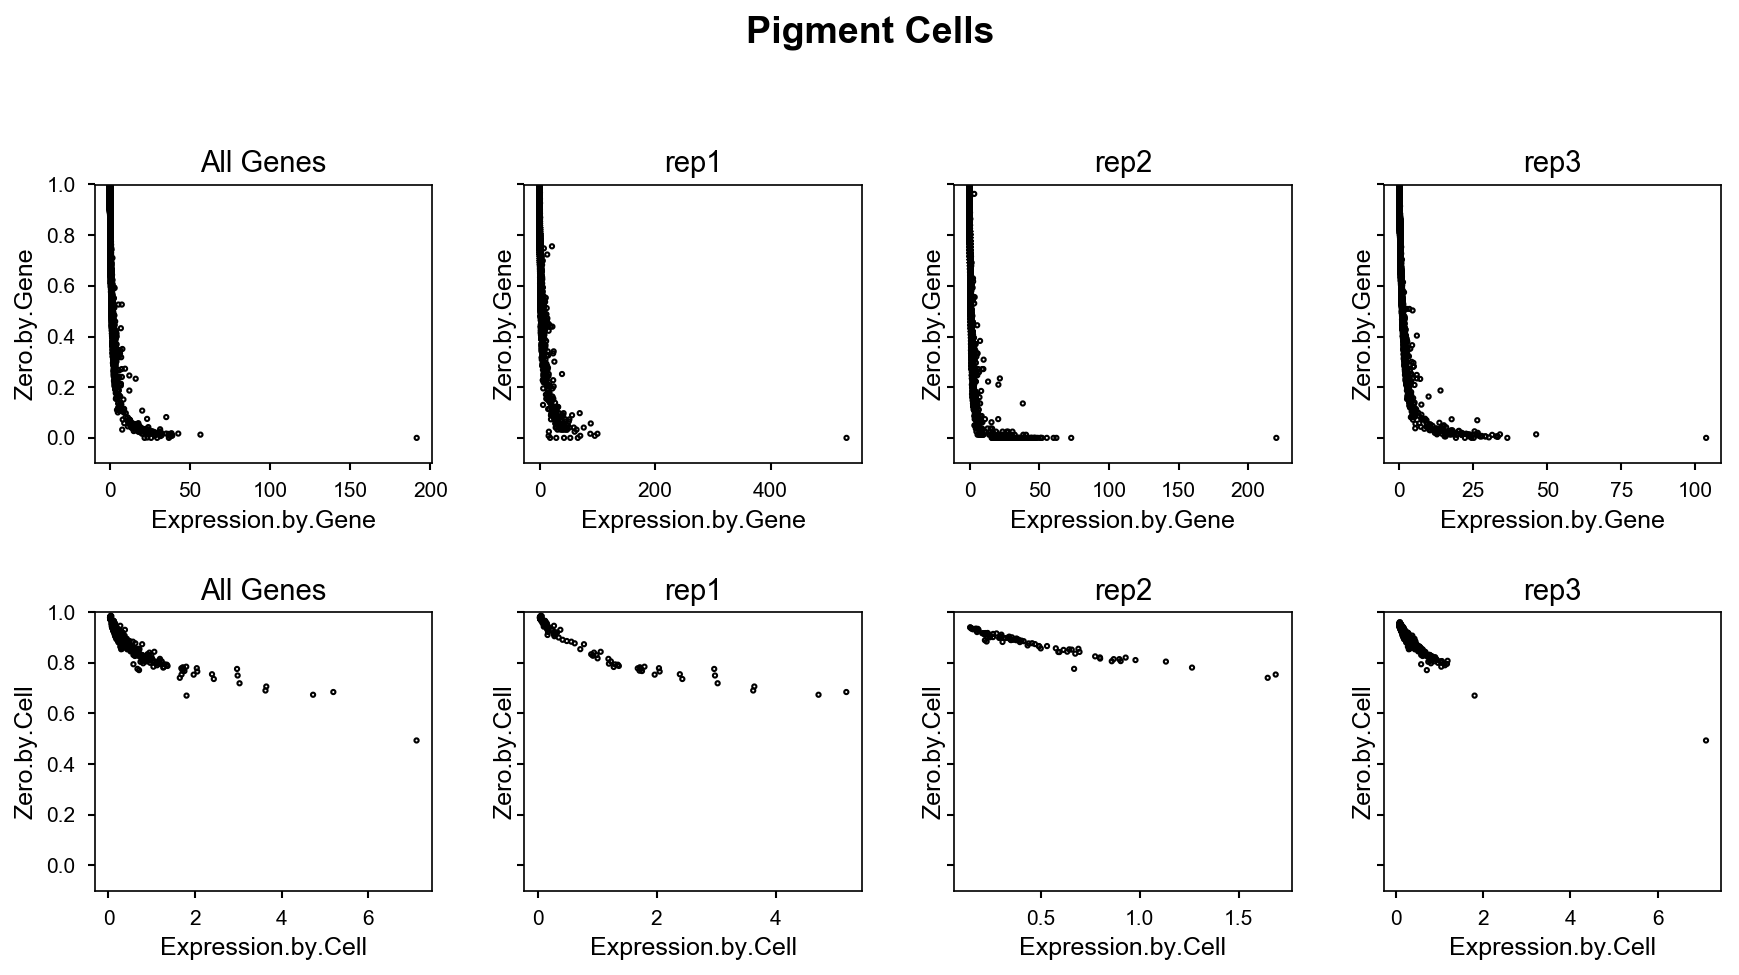

In [67]:
scatter_kws = dict(facecolors='none', edgecolors='k', lw=1, s=4)


def by_gene(dd, ax, title=None):
    _dat = dd.drop('rep', axis=1)
    exp_by_gene = _dat.mean()
    zeros_by_gene = (_dat == 0).mean()
    ax.scatter(exp_by_gene, zeros_by_gene, **scatter_kws)
    ax.set_xlabel('Expression.by.Gene')
    ax.set_ylabel('Zero.by.Gene')
    
    if title:
        ax.set_title(title)
    
    
def by_cell(dd, ax, title=None):
    _dat = dd.drop('rep', axis=1)
    exp_by_cell = _dat.mean(axis=1)
    zeros_by_cell = (_dat == 0).mean(axis=1)
    ax.scatter(exp_by_cell, zeros_by_cell, **scatter_kws)
    ax.set_xlabel('Expression.by.Cell')
    ax.set_ylabel('Zero.by.Cell')
    
    if title:
        ax.set_title(title)

def _plot(cluster):
    dat = raw_w_meta.query(f'cluster == "{cluster}"').drop('cluster', axis=1)
    
    fig, axes = plt.subplots(2, 4, figsize=plt.figaspect(1/2), sharey=True)
    by_gene(dat, axes[0, 0], 'All Genes')
    for ax, (g, dd) in zip(axes[0, 1:].flat, dat.groupby('rep')):
        by_gene(dd, ax, g)

    by_cell(dat, axes[1, 0], 'All Genes')
    for ax, (g, dd) in zip(axes[1, 1:].flat, dat.groupby('rep')):
        by_cell(dd, ax, g)

    axes[0, 0].set_ylim(-0.1, 1)
    axes[1, 0].set_ylim(-0.1, 1)

    fig.suptitle(cluster, y=1.1)
    plt.tight_layout()
    
for cluster in nbconfig.sel_cluster_order:
    _plot(cluster)

## Now what??

So far I have seen that missingness is a major problem if we are wanting to compare across clusters. I am not too worried about the clustering and cell type assignment; Seurat is designed for scRNA-Seq and uses specific techniques to help with this. I am worried about comparing X:A across clusters and deciding on the best way to do this. 